# TemporalVAE demo notebook with Embryo Beta cells

## Load data

In [50]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
os.chdir("/mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main")
import sys
sys.path.append(os.getcwd())
dataset="embryoBeta"

In [51]:
tvae_path = 'https://github.com/StatBiomed/TemporalVAE-reproducibility/raw/refs/heads/main'

Y = pd.read_csv(tvae_path + '/Fig2_TemproalVAE_against_benchmark_methods/' +
                'data_fromPsupertime/embryoBeta_Y.csv', index_col = 0)
Y.head()

,time
bE17.5_1_01,-1
bE17.5_1_02,-1
bE17.5_1_03,-1
bE17.5_1_04,-1
bE17.5_1_05,-1


In [52]:
X = pd.read_csv(tvae_path + '/Fig2_TemproalVAE_against_benchmark_methods/' +
                'data_fromPsupertime/embryoBeta_X.csv', index_col = 0)
X.head()

,bE17.5_1_01,bE17.5_1_02,bE17.5_1_03,bE17.5_1_04,bE17.5_1_05,bE17.5_2_01,bE17.5_2_02,bE17.5_2_03,bE17.5_2_04,bE17.5_2_05,...,bP0_2_30,bP0_2_31,bP9_2_24,bP9_2_25,bP9_2_26,bP9_4_13,bP15_1_21,bP15_1_22,bP60_1_40,bP60_3_30
Symbol,,,,,,,,,,,,,,,,,,,,,
Cdc45,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,27.61,0.00,...,0.00,0.00,20.62,0.00,0.00,67.31,53.64,0.0,0.00,0.00
H19,0.00,0.00,0.00,0.00,0.00,0.00,0.40,0.00,0.00,0.85,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Scml2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,8.42,0.0,0.00,0.00
Narf,18.44,47.67,16.61,6.71,37.55,25.99,15.69,17.02,13.69,0.00,...,38.78,0.00,0.00,6.34,3.59,7.88,0.00,0.0,14.64,30.85
Klf6,0.26,6.11,3.07,0.96,21.38,6.07,20.44,9.39,5.08,7.83,...,22.68,46.41,8.06,9.61,7.48,7.11,14.27,13.6,0.00,14.11


In [53]:
var_df = pd.DataFrame({'GeneName': X.index.values.astype('str')})
var_df.index = var_df['GeneName']

adata = sc.AnnData(X = X.values.transpose(), obs = Y, var = var_df)
adata

/mnt/yijun/nfs_share/yijun_tmp/ipykernel_439493/2683797749.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X = X.values.transpose(), obs = Y, var = var_df)


AnnData object with n_obs × n_vars = 575 × 3737
    obs: 'time'
    var: 'GeneName'

In [54]:
adata.obs.groupby(['time'])['time'].count()

time
-1      61
 0      84
 3      88
 9      81
 15     59
 18     71
 60    131
Name: time, dtype: int64

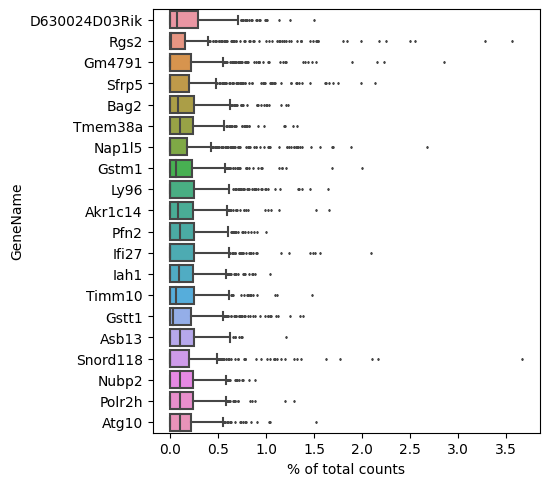

In [55]:
sc.pl.highest_expr_genes(adata, n_top=20)

## Use preprocess method provided by Psupertime

In [56]:
preprocessing_params = {"select_genes": "all", "log": True}
import anndata
from examples.pypsupertime import Psupertime

print(f"Input Data: n_genes={adata.n_vars}, n_cells={adata.n_obs}")
# ------------------preprocess adata here
tp = Psupertime(n_jobs=5, n_folds=5,
                preprocessing_params=preprocessing_params
                )  # if for Acinar cell "select_genes": "all"

adata = tp.preprocessing.fit_transform(adata.copy())
del tp


Input Data: n_genes=3737, n_cells=575


In [57]:
adata

AnnData object with n_obs × n_vars = 575 × 3737
    obs: 'time'
    var: 'GeneName', 'n_cells', 'mean', 'std'
    uns: 'log1p'

## Train TemporalVAE with TemporalVAE

In [58]:
method = "tvae"
time_standard_type = "embryoneg5to5"  #
print(f"time standard type: {time_standard_type}")
if not os.path.exists(f'{os.getcwd()}/{method}_results'):
    os.makedirs(f'{os.getcwd()}/{method}_results')

time standard type: embryoneg5to5


In [59]:
import TemporalVAE
print(TemporalVAE.__version__)


0.0.1


## Set model config and logger config

In [60]:
os.getcwd()

'/mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main'

In [61]:
# ------- set config and logger ------
train_epoch_num = 60
import yaml
with open("TemporalVAE/embryoBetaCell_toyDataset.yaml", 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

In [62]:
import logging
from TemporalVAE.utils.logging_system  import  LogHelper
logger_file = f'{os.getcwd()}/examples/{method}_results/exp2_{dataset}.log'
LogHelper.setup(log_path=logger_file, level='INFO')
_logger = logging.getLogger(__name__)
print("Finished setting up the logger at: {}.".format(logger_file))

Finished setting up the logger at: /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta.log.
Finished setting up the logger at: /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta.log.


In [63]:
print(f"Epoch number: {train_epoch_num}")
donor_list = list(np.unique(adata.obs["time"]))
donor_list

Epoch number: 60
Epoch number: 60


[-1, 0, 3, 9, 15, 18, 60]

[-1, 0, 3, 9, 15, 18, 60]

In [64]:
kFold_test_result_df = pd.DataFrame(columns=['time', 'pseudotime', 'trans_label'])

save_path = _logger.root.handlers[0].baseFilename.replace(".log", "")
save_path

'/mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta'

'/mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta'

## 1. If you want to do train on all donors and check the umap of latent space.


### Import necessary methods

In [66]:
from TemporalVAE.utils.GPU_manager_pytorch import auto_select_gpu_and_cpu, check_memory
from TemporalVAE.utils.utils_project import trans_time, plot_training_loss_for_tags
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pathlib import Path

import numpy as np
from TemporalVAE.model_master.experiment_temporalVAE import temporalVAEExperiment
from TemporalVAE.model_master.dataset import  SupervisedVAEDataset_onlyPredict
from TemporalVAE.model_master import vae_models

### Define the save path of results

In [67]:
subFold_save_file_path = "{}/vae_results/all/".format(save_path)
if not os.path.exists(subFold_save_file_path):
    os.makedirs(subFold_save_file_path)
subFold_save_file_path

'/mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/all/'

'/mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/all/'

### Transpose adata to tensor type for model training

In [68]:
# we need to transpose data to correct its shape
x_sc_train = torch.tensor(adata.X, dtype=torch.get_default_dtype()).t()
print("Set x_sc_train data with shape (gene, cells): {}".format(x_sc_train.shape))
y_time_train = x_sc_train.new_tensor(np.array(adata.obs["time"]).astype(int))
y_time_train

Set x_sc_train data with shape (gene, cells): torch.Size([3737, 575])
Set x_sc_train data with shape (gene, cells): torch.Size([3737, 575])


tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  

tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  

### Normalized the time of each cell.

In [69]:
# for classification model with discrete time cannot use sigmoid and logit time type
y_time_nor_train, label_dic = trans_time(y_time_train, time_standard_type)
print("label dictionary: {}".format(label_dic))
print("Normalize train y_time_nor_train type: {}, with y_time_nor_train lable: {}, shape: {}, \ndetail: {}"
      .format(time_standard_type, np.unique(y_time_train), y_time_train.shape, np.unique(y_time_nor_train)))
y_time_nor_train

label dictionary: {-1: -5.0, 0: -4.836, 3: -4.344, 9: -3.361, 15: -2.377, 18: -1.885, 60: 5.0}
Normalize train y_time_nor_train type: embryoneg5to5, with y_time_nor_train lable: [-1.  0.  3.  9. 15. 18. 60.], shape: torch.Size([575]), 
detail: [-5.    -4.836 -4.344 -3.361 -2.377 -1.885  5.   ]
label dictionary: {-1: -5.0, 0: -4.836, 3: -4.344, 9: -3.361, 15: -2.377, 18: -1.885, 60: 5.0}
Normalize train y_time_nor_train type: embryoneg5to5, with y_time_nor_train lable: [-1.  0.  3.  9. 15. 18. 60.], shape: torch.Size([575]), 
detail: [-5.    -4.836 -4.344 -3.361 -2.377 -1.885  5.   ]


tensor([-5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000,
        -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000,
        -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000,
        -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000,
        -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000,
        -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000,
        -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000,
        -5.0000, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360,
        -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360,
        -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360,
        -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360,
        -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360,
        -4.8360, -4.8360, -4.8360, -4.83

tensor([-5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000,
        -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000,
        -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000,
        -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000,
        -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000,
        -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000,
        -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000,
        -5.0000, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360,
        -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360,
        -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360,
        -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360,
        -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360, -4.8360,
        -4.8360, -4.8360, -4.8360, -4.83

### Set up structure of VAE model and Start train process

In [70]:
# ------------------------------------------- Set up VAE model and Start train process -------------------------------------------------
print("Start training with epoch: {}. ".format(train_epoch_num))

# if int(config['model_params']['in_channels']) == 0:
config['model_params']['in_channels'] = x_sc_train.shape[0]
tb_logger = TensorBoardLogger(save_dir=subFold_save_file_path,
                              name=config['model_params']['name'], )

# For reproducibility
seed_everything(config['exp_params']['manual_seed'], True)
MyVAEModel = vae_models[config['model_params']['name']](**config['model_params'])
MyVAEModel

2025-03-16 03:51:39,879 INFO - lightning_fabric.utilities.seed - Global seed set to 1265 
2025-03-16 03:51:39,879 INFO - lightning_fabric.utilities.seed - Global seed set to 1265 
2025-03-16 03:51:39,879 INFO - lightning_fabric.utilities.seed - Global seed set to 1265 
2025-03-16 03:51:39,879 INFO - lightning_fabric.utilities.seed - Global seed set to 1265 
2025-03-16 03:51:39,879 INFO - lightning_fabric.utilities.seed - Global seed set to 1265 
2025-03-16 03:51:39,879 INFO - lightning_fabric.utilities.seed - Global seed set to 1265 


Start training with epoch: 60. 
Start training with epoch: 60. 


SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=3737, out_features=3737, bias=True)
      (1): BatchNorm1d(3737, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=3737, out_features=3737, bias=True)
      (1): BatchNorm1d(3737, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=3737, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequential(
      (0)

SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=3737, out_features=3737, bias=True)
      (1): BatchNorm1d(3737, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=3737, out_features=3737, bias=True)
      (1): BatchNorm1d(3737, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=3737, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequential(
      (0)

### Set up training process parameters

In [72]:
train_data = [[x_sc_train[:, i], y_time_nor_train[i], y_time_train[i]] for i in range(x_sc_train.shape[1])]
from TemporalVAE.model_master.dataset import SupervisedVAEDataset_onlyTrain
data = SupervisedVAEDataset_onlyTrain(train_data=train_data, train_batch_size=len(train_data))

# data.setup("train")
experiment = temporalVAEExperiment(MyVAEModel, config['exp_params'])

lr_monitor = LearningRateMonitor()
check_memory()
device = auto_select_gpu_and_cpu()
print("Auto select run on {}".format(device))

runner = Trainer(logger=tb_logger, log_every_n_steps=1,
                 callbacks=[
                     lr_monitor,
                     ModelCheckpoint(save_top_k=2,
                                     dirpath=os.path.join(tb_logger.log_dir, "checkpoints"),
                                     monitor="val_loss",
                                     save_last=True),
                 ],
                 # check_val_every_n_epoch=1, val_check_interval=1,
                 devices=[int(device.split(":")[-1])] if device!="cpu" else "auto",
                 accelerator="gpu" if device!="cpu" else "cpu", max_epochs=train_epoch_num
                 )

Path(f"{tb_logger.log_dir}/Samples").mkdir(exist_ok=True, parents=True)
Path(f"{tb_logger.log_dir}/Reconstructions").mkdir(exist_ok=True, parents=True)

2025-03-16 03:51:47,125 INFO - pytorch_lightning.utilities.rank_zero - GPU available: True (cuda), used: True 
2025-03-16 03:51:47,125 INFO - pytorch_lightning.utilities.rank_zero - GPU available: True (cuda), used: True 
2025-03-16 03:51:47,125 INFO - pytorch_lightning.utilities.rank_zero - GPU available: True (cuda), used: True 
2025-03-16 03:51:47,125 INFO - pytorch_lightning.utilities.rank_zero - GPU available: True (cuda), used: True 
2025-03-16 03:51:47,126 INFO - pytorch_lightning.utilities.rank_zero - TPU available: False, using: 0 TPU cores 
2025-03-16 03:51:47,126 INFO - pytorch_lightning.utilities.rank_zero - TPU available: False, using: 0 TPU cores 
2025-03-16 03:51:47,125 INFO - pytorch_lightning.utilities.rank_zero - GPU available: True (cuda), used: True 
2025-03-16 03:51:47,125 INFO - pytorch_lightning.utilities.rank_zero - GPU available: True (cuda), used: True 
2025-03-16 03:51:47,126 INFO - pytorch_lightning.utilities.rank_zero - TPU available: False, using: 0 TPU co

Free Memory Percentage: 68.95%
[INFO] GPU device 2 - total: 40.0GB; - memory free: 38.337GB.
[INFO] GPU device 1 - total: 40.0GB; - memory free: 38.819GB.
[INFO] GPU device 0 - total: 40.0GB; - memory free: 37.325GB.

[INFO] more than 5% free memory, Auto select GPU device 1,- memory free: 38.819GB
Auto select run on cuda:1


### Starting training.

In [73]:

print(f"======= Training {config['model_params']['name']} =======")
runner.fit(experiment, data)

# test the model
data_predict = SupervisedVAEDataset_onlyPredict(predict_data=train_data, predict_batch_size=len(train_data))
train_result = runner.predict(experiment, data_predict)
train_clf_result, train_latent_mu_result, train_latent_log_var_result = train_result[0][0], train_result[0][1], \
    train_result[0][2]

/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
2025-03-16 03:51:52,376 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-16 03:51:52,376 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pyto

======= Training SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial =======
======= Training SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial =======


/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(87.9330, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.3852, device='cuda:1'), 'train_KLD_step': tensor(-6.0102, device='cuda:1'), 'train_clf_loss_step': tensor(17.3092, device='cuda:1'), 'train_loss_epoch': tensor(87.9330, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.3852, device='cuda:1'), 'train_KLD_epoch': tensor(-6.0102, device='cuda:1'), 'train_clf_loss_epoch': tensor(17.3092, device='cuda:1')}
Epoch train loss: {'train_loss_step': tensor(87.9330, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.3852, device='cuda:1'), 'train_KLD_step': tensor(-6.0102, device='cuda:1'), 'train_clf_loss_step': tensor(17.3092, device='cuda:1'), 'train_loss_epoch': tensor(87.9330, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.3852, device='cuda:1'), 'train_KLD_epoch': tensor(-6.0102, device='cuda:1'), 'train_clf_loss_epoch': tensor(17.3092, device='cuda:1')}
Epoch train loss: {'train_loss_step': 

2025-03-16 03:53:59,507 INFO - pytorch_lightning.utilities.rank_zero - `Trainer.fit` stopped: `max_epochs=60` reached. 
2025-03-16 03:53:59,507 INFO - pytorch_lightning.utilities.rank_zero - `Trainer.fit` stopped: `max_epochs=60` reached. 
2025-03-16 03:53:59,507 INFO - pytorch_lightning.utilities.rank_zero - `Trainer.fit` stopped: `max_epochs=60` reached. 
2025-03-16 03:53:59,507 INFO - pytorch_lightning.utilities.rank_zero - `Trainer.fit` stopped: `max_epochs=60` reached. 
2025-03-16 03:53:59,507 INFO - pytorch_lightning.utilities.rank_zero - `Trainer.fit` stopped: `max_epochs=60` reached. 
2025-03-16 03:53:59,507 INFO - pytorch_lightning.utilities.rank_zero - `Trainer.fit` stopped: `max_epochs=60` reached. 
2025-03-16 03:53:59,904 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for 

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

### Clear cache

In [74]:
del runner
del experiment
# 清除CUDA缓存
torch.cuda.empty_cache()

In [75]:
MyVAEModel

SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=3737, out_features=3737, bias=True)
      (1): BatchNorm1d(3737, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=3737, out_features=3737, bias=True)
      (1): BatchNorm1d(3737, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=3737, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequential(
      (0)

SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=3737, out_features=3737, bias=True)
      (1): BatchNorm1d(3737, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=3737, out_features=3737, bias=True)
      (1): BatchNorm1d(3737, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=3737, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequential(
      (0)

In [81]:
adata

AnnData object with n_obs × n_vars = 575 × 3737
    obs: 'time'
    var: 'GeneName', 'n_cells', 'mean', 'std'
    uns: 'log1p'

AnnData object with n_obs × n_vars = 575 × 3737
    obs: 'time'
    var: 'GeneName', 'n_cells', 'mean', 'std'
    uns: 'log1p'

... storing 'time_group' as categorical
... storing 'time_group' as categorical
/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


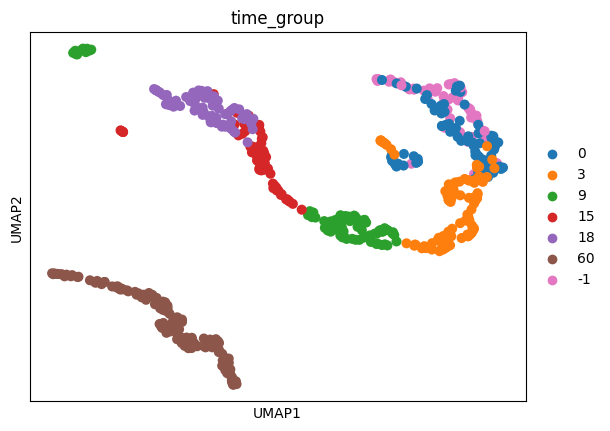

In [79]:
#train_clf_result, train_latent_mu_result
adata1 = adata.copy()
adata1.obsm['X_pca'] = train_latent_mu_result.cpu().data.numpy()
adata1.obs["time_group"] = adata1.obs['time'].values.astype('str')

sc.pp.neighbors(adata1, n_neighbors=5, n_pcs=10,random_state=0)
sc.tl.umap(adata1,random_state=0)

sc.pl.umap(adata1, color=["time_group"])

## If you want to do multiple loop calculations: test on one donor and train on other donors.


## Define a function: test on one donor and train on other donors.

In [18]:
def process_fold_toyDataset(fold, donor_list, adata, time_standard_type, config, save_path, train_epoch_num):
    from TemporalVAE.utils.GPU_manager_pytorch import auto_select_gpu_and_cpu, check_memory
    from TemporalVAE.utils.utils_project import trans_time, plot_training_loss_for_tags
    import torch
    from pytorch_lightning import Trainer
    from pytorch_lightning.loggers import TensorBoardLogger
    from pytorch_lightning import seed_everything
    from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
    from pathlib import Path

    import numpy as np
    from TemporalVAE.model_master.experiment_temporalVAE import temporalVAEExperiment
    from TemporalVAE.model_master.dataset import SupervisedVAEDataset, SupervisedVAEDataset_onlyPredict
    from TemporalVAE.model_master import vae_models
    # _logger = logging.getLogger(__name__)
    # time.sleep(random.randint(5, 20))
    print("the {}/{} fold train, use donor-{} as test set".format(fold + 1, len(donor_list), donor_list[fold]))

    train_adata = adata[adata.obs["time"] != donor_list[fold]].copy()
    test_adata = adata[adata.obs["time"] == donor_list[fold]].copy()
    # move one cell from test to train to occupy the test time
    one_test_cell = test_adata[:5].copy()
    test_adata = test_adata[5:].copy()
    train_adata = anndata.concat([train_adata.copy(), one_test_cell.copy()], axis=0)

    # ----------------------------------------split Train and Test dataset-----------------------------------------------------
    print("the {}/{} fold train, use donor-{} as test set".format(fold + 1, len(donor_list), donor_list[fold]))
    subFold_save_file_path = "{}/vae_results/{}/".format(save_path,
                                                         donor_list[fold])

    if not os.path.exists(subFold_save_file_path):
        os.makedirs(subFold_save_file_path)
    # we need to transpose data to correct its shape
    x_sc_train = torch.tensor(train_adata.X, dtype=torch.get_default_dtype()).t()
    x_sc_test = torch.tensor(test_adata.X, dtype=torch.get_default_dtype()).t()
    print("Set x_sc_train data with shape (gene, cells): {}".format(x_sc_train.shape))
    print("Set x_sc_test data with shape (gene, cells): {}".format(x_sc_test.shape))

    # trans y_time

    y_time_train = x_sc_train.new_tensor(np.array(train_adata.obs["time"]).astype(int))
    y_time_test = x_sc_test.new_tensor(np.array(test_adata.obs["time"]).astype(int))

    # for classification model with discrete time cannot use sigmoid and logit time type
    y_time_nor_train, label_dic = trans_time(y_time_train, time_standard_type, capture_time_other=y_time_test)
    y_time_nor_test, label_dic = trans_time(y_time_test, time_standard_type, label_dic_train=label_dic)
    print("label dictionary: {}".format(label_dic))
    print("Normalize train y_time_nor_train type: {}, with y_time_nor_train lable: {}, shape: {}, \ndetail: {}"
          .format(time_standard_type, np.unique(y_time_train), y_time_train.shape, np.unique(y_time_nor_train)))
    print("Normalize test y_time_nor_train type: {}, with y_time_nor_train lable: {}, shape: {}, \ndetail: {}"
          .format(time_standard_type, np.unique(y_time_test), y_time_test.shape, np.unique(y_time_nor_test)))

    # ------------------------------------------- Set up VAE model and Start train process -------------------------------------------------
    print("Start training with epoch: {}. ".format(train_epoch_num))

    # if int(config['model_params']['in_channels']) == 0:
    config['model_params']['in_channels'] = x_sc_train.shape[0]
    tb_logger = TensorBoardLogger(save_dir=subFold_save_file_path,
                                  name=config['model_params']['name'], )

    # For reproducibility
    seed_everything(config['exp_params']['manual_seed'], True)

    MyVAEModel = vae_models[config['model_params']['name']](**config['model_params'])

    ## print parameters of model
    # for name, param in MyVAEModel.named_parameters():
    #     print(name, param)
    train_data = [[x_sc_train[:, i], y_time_nor_train[i], y_time_train[i]] for i in range(x_sc_train.shape[1])]
    test_data = [[x_sc_test[:, i], y_time_nor_test[i], y_time_test[i]] for i in range(x_sc_test.shape[1])]
    print("don't set batch")
    data = SupervisedVAEDataset(train_data=train_data, val_data=test_data, test_data=test_data, predict_data=test_data,
                                train_batch_size=len(train_data), val_batch_size=len(test_data),
                                test_batch_size=len(test_data), predict_batch_size=len(test_data),
                                label_dic=label_dic)

    # data.setup("train")
    experiment = temporalVAEExperiment(MyVAEModel, config['exp_params'])

    # 创建一个 LearningRateMonitor 回调实例
    lr_monitor = LearningRateMonitor()
    # 2023-09-07 20:34:25 add check memory
    check_memory()
    device = auto_select_gpu_and_cpu()
    print("Auto select run on {}".format(device))

    runner = Trainer(logger=tb_logger, log_every_n_steps=1,
                     callbacks=[
                         lr_monitor,
                         ModelCheckpoint(save_top_k=2,
                                         dirpath=os.path.join(tb_logger.log_dir, "checkpoints"),
                                         monitor="val_loss",
                                         save_last=True),
                     ],
                     # check_val_every_n_epoch=1, val_check_interval=1,
                     devices=[int(device.split(":")[-1])],
                     accelerator="gpu", max_epochs=train_epoch_num
                     )

    Path(f"{tb_logger.log_dir}/Samples").mkdir(exist_ok=True, parents=True)
    Path(f"{tb_logger.log_dir}/Reconstructions").mkdir(exist_ok=True, parents=True)

    print(f"======= Training {config['model_params']['name']} =======")
    runner.fit(experiment, data)

    # test the model
    print("this epoch final, on test data:{}".format(runner.test(experiment, data)))
    # predict on train data
    data_predict = SupervisedVAEDataset_onlyPredict(predict_data=train_data, predict_batch_size=len(train_data))
    train_result = runner.predict(experiment, data_predict)
    train_clf_result, train_latent_mu_result, train_latent_log_var_result = train_result[0][0], train_result[0][1], \
        train_result[0][2]
    # predict on test data
    data_test = SupervisedVAEDataset_onlyPredict(predict_data=test_data, predict_batch_size=len(test_data))
    test_result = runner.predict(experiment, data_test)
    test_clf_result, test_latent_mu_result, test_latent_log_var_result = test_result[0][0], test_result[0][1], \
        test_result[0][2]
    if (np.isnan(np.squeeze(test_clf_result)).any()):
        print("The Array contain NaN values")
    else:
        print("The Array does not contain NaN values")
    print("predicted time of test donor is continuous.")

    _result_df = pd.DataFrame({'time': donor_list[fold],  # First column with a constant value of 1
                               'pseudotime': np.squeeze(test_clf_result, axis=1)})
    # _result_df['pseudotime'] = _result_df['pseudotime_normalized'].apply(denormalize, args=(min(label_dic.keys()), max(label_dic.keys()), min(label_dic.values()), max(label_dic.values())))
    _result_df["trans_label"] = _result_df["time"].map(label_dic)
    print("Plot training loss line for check.")

    from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
    tags = EventAccumulator(tb_logger.log_dir).Reload().Tags()['scalars']
    print("All tags in logger: {}".format(tags))
    # Retrieve and print the metric results
    plot_tag_list = list(set(["train_clf_loss_epoch", "val_clf_loss", "test_clf_loss_epoch"]) & set(tags))
    print(f"plot tags {plot_tag_list}")
    plot_training_loss_for_tags(tb_logger, plot_tag_list, special_str=donor_list[fold], title=donor_list[fold])

    # ---------------------------------------------- save sub model parameters for check  --------------------------------------------------
    print("encoder and decoder structure: {}".format({"encoder": MyVAEModel.encoder, "decoder": MyVAEModel.decoder}))
    print("clf-decoder structure: {}".format({"encoder": MyVAEModel.clf_decoder}))
    torch.save(MyVAEModel, tb_logger.root_dir + "/version_" + str(tb_logger.version) + '/model.pth')
    print("detail information about structure save at： {}".format(
        tb_logger.root_dir + "/version_" + str(tb_logger.version) + '/model.pth'))


    del runner
    del experiment
    # 清除CUDA缓存
    torch.cuda.empty_cache()
    return _result_df,MyVAEModel,test_latent_mu_result

2025-03-09 11:18:33,201 INFO - lightning_fabric.utilities.seed - Global seed set to 1265 


the 1/7 fold train, use donor--1 as test set
the 1/7 fold train, use donor--1 as test set
Set x_sc_train data with shape (gene, cells): torch.Size([3737, 519])
Set x_sc_test data with shape (gene, cells): torch.Size([3737, 56])
label dictionary: {-1: -5.0, 0: -4.836, 3: -4.344, 9: -3.361, 15: -2.377, 18: -1.885, 60: 5.0}
Normalize train y_time_nor_train type: embryoneg5to5, with y_time_nor_train lable: [-1.  0.  3.  9. 15. 18. 60.], shape: torch.Size([519]), 
detail: [-5.    -4.836 -4.344 -3.361 -2.377 -1.885  5.   ]
Normalize test y_time_nor_train type: embryoneg5to5, with y_time_nor_train lable: [-1.], shape: torch.Size([56]), 
detail: [-5.]
Start training with epoch: 60. 


2025-03-09 11:18:33,519 INFO - pytorch_lightning.utilities.rank_zero - GPU available: True (cuda), used: True 
2025-03-09 11:18:33,519 INFO - pytorch_lightning.utilities.rank_zero - TPU available: False, using: 0 TPU cores 
2025-03-09 11:18:33,520 INFO - pytorch_lightning.utilities.rank_zero - IPU available: False, using: 0 IPUs 
2025-03-09 11:18:33,520 INFO - pytorch_lightning.utilities.rank_zero - HPU available: False, using: 0 HPUs 
2025-03-09 11:18:33,524 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 


don't set batch
Free Memory Percentage: 73.06%
[INFO] GPU device 2 - total: 40.0GB; - memory free: 39.377GB.
[INFO] GPU device 1 - total: 40.0GB; - memory free: 38.819GB.
[INFO] GPU device 0 - total: 40.0GB; - memory free: 39.377GB.

[INFO] more than 5% free memory, Auto select GPU device 0,- memory free: 39.377GB
Auto select run on cuda:0
======= Training SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial =======


2025-03-09 11:18:34,749 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 
2025-03-09 11:18:34,752 INFO - pytorch_lightning.callbacks.model_summary - 
  | Name  | Type                                                         | Params
---------------------------------------------------------------------------------------
0 | model | SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial | 44.0 M
---------------------------------------------------------------------------------------
44.0 M    Trainable params
0         Non-trainable params
44.0 M    Total params
175.829   Total estimated model params size (MB) 


Sanity Checking: 0it [00:00, ?it/s]

/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(83.9067, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.3162, device='cuda:0'), 'train_KLD_step': tensor(-6.0058, device='cuda:0'), 'train_clf_loss_step': tensor(16.5178, device='cuda:0'), 'val_loss': tensor(121.0284, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.6132, device='cuda:0'), 'val_KLD': tensor(-0.3577, device='cuda:0'), 'val_clf_loss': tensor(23.8830, device='cuda:0'), 'train_loss_epoch': tensor(83.9067, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.3162, device='cuda:0'), 'train_KLD_epoch': tensor(-6.0058, device='cuda:0'), 'train_clf_loss_epoch': tensor(16.5178, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(82.0061, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.3054, device='cuda:0'), 'train_KLD_step': tensor(-6.4301, device='cuda:0'), 'train_clf_loss_step': tensor(16.1398, device='cuda:0'), 'val_loss': tensor(114.6124, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.6607, device='cuda:0'), 'val_KLD': tensor(-26.9474, device='cuda:0'), 'val_clf_loss': tensor(22.5890, device='cuda:0'), 'train_loss_epoch': tensor(82.0061, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.3054, device='cuda:0'), 'train_KLD_epoch': tensor(-6.4301, device='cuda:0'), 'train_clf_loss_epoch': tensor(16.1398, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(76.9191, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.2401, device='cuda:0'), 'train_KLD_step': tensor(-7.4323, device='cuda:0'), 'train_clf_loss_step': tensor(15.1354, device='cuda:0'), 'val_loss': tensor(100.6034, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.1244, device='cuda:0'), 'val_KLD': tensor(-301.8065, device='cuda:0'), 'val_clf_loss': tensor(19.6807, device='cuda:0'), 'train_loss_epoch': tensor(76.9191, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.2401, device='cuda:0'), 'train_KLD_epoch': tensor(-7.4323, device='cuda:0'), 'train_clf_loss_epoch': tensor(15.1354, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(71.1615, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.1635, device='cuda:0'), 'train_KLD_step': tensor(-8.8417, device='cuda:0'), 'train_clf_loss_step': tensor(13.9992, device='cuda:0'), 'val_loss': tensor(90.3673, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.2506, device='cuda:0'), 'val_KLD': tensor(-1997.4951, device='cuda:0'), 'val_clf_loss': tensor(17.5235, device='cuda:0'), 'train_loss_epoch': tensor(71.1615, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.1635, device='cuda:0'), 'train_KLD_epoch': tensor(-8.8417, device='cuda:0'), 'train_clf_loss_epoch': tensor(13.9992, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(65.4323, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.1287, device='cuda:0'), 'train_KLD_step': tensor(-10.6341, device='cuda:0'), 'train_clf_loss_step': tensor(12.8602, device='cuda:0'), 'val_loss': tensor(83.0038, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.2561, device='cuda:0'), 'val_KLD': tensor(-2413.9075, device='cuda:0'), 'val_clf_loss': tensor(16.0288, device='cuda:0'), 'train_loss_epoch': tensor(65.4323, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.1287, device='cuda:0'), 'train_KLD_epoch': tensor(-10.6341, device='cuda:0'), 'train_clf_loss_epoch': tensor(12.8602, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(61.4601, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0956, device='cuda:0'), 'train_KLD_step': tensor(-12.6540, device='cuda:0'), 'train_clf_loss_step': tensor(12.0723, device='cuda:0'), 'val_loss': tensor(69.7995, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.2172, device='cuda:0'), 'val_KLD': tensor(-879.4157, device='cuda:0'), 'val_clf_loss': tensor(13.4725, device='cuda:0'), 'train_loss_epoch': tensor(61.4601, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0956, device='cuda:0'), 'train_KLD_epoch': tensor(-12.6540, device='cuda:0'), 'train_clf_loss_epoch': tensor(12.0723, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(55.6631, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0803, device='cuda:0'), 'train_KLD_step': tensor(-14.9580, device='cuda:0'), 'train_clf_loss_step': tensor(10.9158, device='cuda:0'), 'val_loss': tensor(61.5048, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.2195, device='cuda:0'), 'val_KLD': tensor(-444.6590, device='cuda:0'), 'val_clf_loss': tensor(11.8348, device='cuda:0'), 'train_loss_epoch': tensor(55.6631, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0803, device='cuda:0'), 'train_KLD_epoch': tensor(-14.9580, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.9158, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(50.6672, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0764, device='cuda:0'), 'train_KLD_step': tensor(-17.4439, device='cuda:0'), 'train_clf_loss_step': tensor(9.9173, device='cuda:0'), 'val_loss': tensor(55.0718, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.2221, device='cuda:0'), 'val_KLD': tensor(-296.0010, device='cuda:0'), 'val_clf_loss': tensor(10.5551, device='cuda:0'), 'train_loss_epoch': tensor(50.6672, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0764, device='cuda:0'), 'train_KLD_epoch': tensor(-17.4439, device='cuda:0'), 'train_clf_loss_epoch': tensor(9.9173, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(47.2163, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0517, device='cuda:0'), 'train_KLD_step': tensor(-20.0615, device='cuda:0'), 'train_clf_loss_step': tensor(9.2319, device='cuda:0'), 'val_loss': tensor(48.0937, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.2237, device='cuda:0'), 'val_KLD': tensor(-230.8743, device='cuda:0'), 'val_clf_loss': tensor(9.1625, device='cuda:0'), 'train_loss_epoch': tensor(47.2163, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0517, device='cuda:0'), 'train_KLD_epoch': tensor(-20.0615, device='cuda:0'), 'train_clf_loss_epoch': tensor(9.2319, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(43.8541, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0626, device='cuda:0'), 'train_KLD_step': tensor(-22.7897, device='cuda:0'), 'train_clf_loss_step': tensor(8.5571, device='cuda:0'), 'val_loss': tensor(41.9639, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.2125, device='cuda:0'), 'val_KLD': tensor(-205.6781, device='cuda:0'), 'val_clf_loss': tensor(7.9400, device='cuda:0'), 'train_loss_epoch': tensor(43.8541, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0626, device='cuda:0'), 'train_KLD_epoch': tensor(-22.7897, device='cuda:0'), 'train_clf_loss_epoch': tensor(8.5571, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(40.0723, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0524, device='cuda:0'), 'train_KLD_step': tensor(-25.6747, device='cuda:0'), 'train_clf_loss_step': tensor(7.8027, device='cuda:0'), 'val_loss': tensor(36.4030, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.2039, device='cuda:0'), 'val_KLD': tensor(-198.1269, device='cuda:0'), 'val_clf_loss': tensor(6.8299, device='cuda:0'), 'train_loss_epoch': tensor(40.0723, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0524, device='cuda:0'), 'train_KLD_epoch': tensor(-25.6747, device='cuda:0'), 'train_clf_loss_epoch': tensor(7.8027, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(37.3583, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0434, device='cuda:0'), 'train_KLD_step': tensor(-28.6360, device='cuda:0'), 'train_clf_loss_step': tensor(7.2616, device='cuda:0'), 'val_loss': tensor(31.5242, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.1919, device='cuda:0'), 'val_KLD': tensor(-198.2536, device='cuda:0'), 'val_clf_loss': tensor(5.8566, device='cuda:0'), 'train_loss_epoch': tensor(37.3583, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0434, device='cuda:0'), 'train_KLD_epoch': tensor(-28.6360, device='cuda:0'), 'train_clf_loss_epoch': tensor(7.2616, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(35.0878, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0287, device='cuda:0'), 'train_KLD_step': tensor(-31.5207, device='cuda:0'), 'train_clf_loss_step': tensor(6.8102, device='cuda:0'), 'val_loss': tensor(27.4220, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.1728, device='cuda:0'), 'val_KLD': tensor(-188.3986, device='cuda:0'), 'val_clf_loss': tensor(5.0404, device='cuda:0'), 'train_loss_epoch': tensor(35.0878, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0287, device='cuda:0'), 'train_KLD_epoch': tensor(-31.5207, device='cuda:0'), 'train_clf_loss_epoch': tensor(6.8102, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(33.1764, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0225, device='cuda:0'), 'train_KLD_step': tensor(-34.1425, device='cuda:0'), 'train_clf_loss_step': tensor(6.4291, device='cuda:0'), 'val_loss': tensor(23.7953, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.1563, device='cuda:0'), 'val_KLD': tensor(-173.0436, device='cuda:0'), 'val_clf_loss': tensor(4.3191, device='cuda:0'), 'train_loss_epoch': tensor(33.1764, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0225, device='cuda:0'), 'train_KLD_epoch': tensor(-34.1425, device='cuda:0'), 'train_clf_loss_epoch': tensor(6.4291, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(31.7447, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0275, device='cuda:0'), 'train_KLD_step': tensor(-36.4872, device='cuda:0'), 'train_clf_loss_step': tensor(6.1416, device='cuda:0'), 'val_loss': tensor(20.7057, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.1492, device='cuda:0'), 'val_KLD': tensor(-160.8000, device='cuda:0'), 'val_clf_loss': tensor(3.7033, device='cuda:0'), 'train_loss_epoch': tensor(31.7447, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0275, device='cuda:0'), 'train_KLD_epoch': tensor(-36.4872, device='cuda:0'), 'train_clf_loss_epoch': tensor(6.1416, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(30.1530, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0283, device='cuda:0'), 'train_KLD_step': tensor(-38.6532, device='cuda:0'), 'train_clf_loss_step': tensor(5.8230, device='cuda:0'), 'val_loss': tensor(18.0280, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.1429, device='cuda:0'), 'val_KLD': tensor(-149.8650, device='cuda:0'), 'val_clf_loss': tensor(3.1695, device='cuda:0'), 'train_loss_epoch': tensor(30.1530, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0283, device='cuda:0'), 'train_KLD_epoch': tensor(-38.6532, device='cuda:0'), 'train_clf_loss_epoch': tensor(5.8230, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(29.3787, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0207, device='cuda:0'), 'train_KLD_step': tensor(-40.6390, device='cuda:0'), 'train_clf_loss_step': tensor(5.6696, device='cuda:0'), 'val_loss': tensor(15.8105, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.1253, device='cuda:0'), 'val_KLD': tensor(-141.9251, device='cuda:0'), 'val_clf_loss': tensor(2.7299, device='cuda:0'), 'train_loss_epoch': tensor(29.3787, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0207, device='cuda:0'), 'train_KLD_epoch': tensor(-40.6390, device='cuda:0'), 'train_clf_loss_epoch': tensor(5.6696, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(27.4606, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0173, device='cuda:0'), 'train_KLD_step': tensor(-42.4916, device='cuda:0'), 'train_clf_loss_step': tensor(5.2865, device='cuda:0'), 'val_loss': tensor(14.1452, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.1039, device='cuda:0'), 'val_KLD': tensor(-134.6663, device='cuda:0'), 'val_clf_loss': tensor(2.4015, device='cuda:0'), 'train_loss_epoch': tensor(27.4606, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0173, device='cuda:0'), 'train_KLD_epoch': tensor(-42.4916, device='cuda:0'), 'train_clf_loss_epoch': tensor(5.2865, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(26.1783, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0042, device='cuda:0'), 'train_KLD_step': tensor(-44.2105, device='cuda:0'), 'train_clf_loss_step': tensor(5.0326, device='cuda:0'), 'val_loss': tensor(12.8661, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.0895, device='cuda:0'), 'val_KLD': tensor(-126.4994, device='cuda:0'), 'val_clf_loss': tensor(2.1490, device='cuda:0'), 'train_loss_epoch': tensor(26.1783, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0042, device='cuda:0'), 'train_KLD_epoch': tensor(-44.2105, device='cuda:0'), 'train_clf_loss_epoch': tensor(5.0326, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(24.9762, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9948, device='cuda:0'), 'train_KLD_step': tensor(-45.7442, device='cuda:0'), 'train_clf_loss_step': tensor(4.7940, device='cuda:0'), 'val_loss': tensor(12.0480, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.0932, device='cuda:0'), 'val_KLD': tensor(-118.1582, device='cuda:0'), 'val_clf_loss': tensor(1.9851, device='cuda:0'), 'train_loss_epoch': tensor(24.9762, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9948, device='cuda:0'), 'train_KLD_epoch': tensor(-45.7442, device='cuda:0'), 'train_clf_loss_epoch': tensor(4.7940, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(24.5787, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0105, device='cuda:0'), 'train_KLD_step': tensor(-47.1193, device='cuda:0'), 'train_clf_loss_step': tensor(4.7113, device='cuda:0'), 'val_loss': tensor(11.2685, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.0754, device='cuda:0'), 'val_KLD': tensor(-110.2707, device='cuda:0'), 'val_clf_loss': tensor(1.8331, device='cuda:0'), 'train_loss_epoch': tensor(24.5787, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0105, device='cuda:0'), 'train_KLD_epoch': tensor(-47.1193, device='cuda:0'), 'train_clf_loss_epoch': tensor(4.7113, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(23.3354, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9879, device='cuda:0'), 'train_KLD_step': tensor(-48.3703, device='cuda:0'), 'train_clf_loss_step': tensor(4.4671, device='cuda:0'), 'val_loss': tensor(10.7180, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.0631, device='cuda:0'), 'val_KLD': tensor(-104.1940, device='cuda:0'), 'val_clf_loss': tensor(1.7258, device='cuda:0'), 'train_loss_epoch': tensor(23.3354, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9879, device='cuda:0'), 'train_KLD_epoch': tensor(-48.3703, device='cuda:0'), 'train_clf_loss_epoch': tensor(4.4671, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(23.1456, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9979, device='cuda:0'), 'train_KLD_step': tensor(-49.5065, device='cuda:0'), 'train_clf_loss_step': tensor(4.4271, device='cuda:0'), 'val_loss': tensor(10.3648, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.0477, device='cuda:0'), 'val_KLD': tensor(-100.5190, device='cuda:0'), 'val_clf_loss': tensor(1.6584, device='cuda:0'), 'train_loss_epoch': tensor(23.1456, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9979, device='cuda:0'), 'train_KLD_epoch': tensor(-49.5065, device='cuda:0'), 'train_clf_loss_epoch': tensor(4.4271, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(22.1545, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9921, device='cuda:0'), 'train_KLD_step': tensor(-50.5964, device='cuda:0'), 'train_clf_loss_step': tensor(4.2300, device='cuda:0'), 'val_loss': tensor(10.1932, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.0206, device='cuda:0'), 'val_KLD': tensor(-97.3052, device='cuda:0'), 'val_clf_loss': tensor(1.6297, device='cuda:0'), 'train_loss_epoch': tensor(22.1545, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9921, device='cuda:0'), 'train_KLD_epoch': tensor(-50.5964, device='cuda:0'), 'train_clf_loss_epoch': tensor(4.2300, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(21.5437, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9882, device='cuda:0'), 'train_KLD_step': tensor(-51.5741, device='cuda:0'), 'train_clf_loss_step': tensor(4.1085, device='cuda:0'), 'val_loss': tensor(10.0889, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.0258, device='cuda:0'), 'val_KLD': tensor(-95.3833, device='cuda:0'), 'val_clf_loss': tensor(1.6079, device='cuda:0'), 'train_loss_epoch': tensor(21.5437, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9882, device='cuda:0'), 'train_KLD_epoch': tensor(-51.5741, device='cuda:0'), 'train_clf_loss_epoch': tensor(4.1085, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.8629, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9836, device='cuda:0'), 'train_KLD_step': tensor(-52.4925, device='cuda:0'), 'train_clf_loss_step': tensor(3.9732, device='cuda:0'), 'val_loss': tensor(9.8699, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.0202, device='cuda:0'), 'val_KLD': tensor(-93.9059, device='cuda:0'), 'val_clf_loss': tensor(1.5653, device='cuda:0'), 'train_loss_epoch': tensor(20.8629, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9836, device='cuda:0'), 'train_KLD_epoch': tensor(-52.4925, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.9732, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.4132, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9769, device='cuda:0'), 'train_KLD_step': tensor(-53.3180, device='cuda:0'), 'train_clf_loss_step': tensor(3.8846, device='cuda:0'), 'val_loss': tensor(9.9467, device='cuda:0'), 'val_Reconstruction_loss': tensor(2.0173, device='cuda:0'), 'val_KLD': tensor(-91.9590, device='cuda:0'), 'val_clf_loss': tensor(1.5813, device='cuda:0'), 'train_loss_epoch': tensor(20.4132, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9769, device='cuda:0'), 'train_KLD_epoch': tensor(-53.3180, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.8846, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(19.7764, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9762, device='cuda:0'), 'train_KLD_step': tensor(-54.0842, device='cuda:0'), 'train_clf_loss_step': tensor(3.7573, device='cuda:0'), 'val_loss': tensor(10.2838, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.9999, device='cuda:0'), 'val_KLD': tensor(-91.2308, device='cuda:0'), 'val_clf_loss': tensor(1.6522, device='cuda:0'), 'train_loss_epoch': tensor(19.7764, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9762, device='cuda:0'), 'train_KLD_epoch': tensor(-54.0842, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.7573, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(18.7791, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9728, device='cuda:0'), 'train_KLD_step': tensor(-54.8087, device='cuda:0'), 'train_clf_loss_step': tensor(3.5585, device='cuda:0'), 'val_loss': tensor(10.4295, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.9488, device='cuda:0'), 'val_KLD': tensor(-91.1343, device='cuda:0'), 'val_clf_loss': tensor(1.6916, device='cuda:0'), 'train_loss_epoch': tensor(18.7791, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9728, device='cuda:0'), 'train_KLD_epoch': tensor(-54.8087, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.5585, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(18.6269, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9694, device='cuda:0'), 'train_KLD_step': tensor(-55.4674, device='cuda:0'), 'train_clf_loss_step': tensor(3.5287, device='cuda:0'), 'val_loss': tensor(10.4686, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.9412, device='cuda:0'), 'val_KLD': tensor(-90.9266, device='cuda:0'), 'val_clf_loss': tensor(1.7009, device='cuda:0'), 'train_loss_epoch': tensor(18.6269, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9694, device='cuda:0'), 'train_KLD_epoch': tensor(-55.4674, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.5287, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(18.0494, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9634, device='cuda:0'), 'train_KLD_step': tensor(-56.0583, device='cuda:0'), 'train_clf_loss_step': tensor(3.4144, device='cuda:0'), 'val_loss': tensor(10.4758, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.9218, device='cuda:0'), 'val_KLD': tensor(-91.5896, device='cuda:0'), 'val_clf_loss': tensor(1.7062, device='cuda:0'), 'train_loss_epoch': tensor(18.0494, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9634, device='cuda:0'), 'train_KLD_epoch': tensor(-56.0583, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.4144, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(18.0342, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9752, device='cuda:0'), 'train_KLD_step': tensor(-56.5964, device='cuda:0'), 'train_clf_loss_step': tensor(3.4090, device='cuda:0'), 'val_loss': tensor(10.7027, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.9034, device='cuda:0'), 'val_KLD': tensor(-92.6684, device='cuda:0'), 'val_clf_loss': tensor(1.7552, device='cuda:0'), 'train_loss_epoch': tensor(18.0342, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9752, device='cuda:0'), 'train_KLD_epoch': tensor(-56.5964, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.4090, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(17.5322, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9669, device='cuda:0'), 'train_KLD_step': tensor(-57.0902, device='cuda:0'), 'train_clf_loss_step': tensor(3.3102, device='cuda:0'), 'val_loss': tensor(10.5656, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.8492, device='cuda:0'), 'val_KLD': tensor(-93.9610, device='cuda:0'), 'val_clf_loss': tensor(1.7386, device='cuda:0'), 'train_loss_epoch': tensor(17.5322, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9669, device='cuda:0'), 'train_KLD_epoch': tensor(-57.0902, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.3102, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(17.4558, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9651, device='cuda:0'), 'train_KLD_step': tensor(-57.5563, device='cuda:0'), 'train_clf_loss_step': tensor(3.2953, device='cuda:0'), 'val_loss': tensor(10.2590, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.8597, device='cuda:0'), 'val_KLD': tensor(-95.1960, device='cuda:0'), 'val_clf_loss': tensor(1.6751, device='cuda:0'), 'train_loss_epoch': tensor(17.4558, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9651, device='cuda:0'), 'train_KLD_epoch': tensor(-57.5563, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.2953, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.6995, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9681, device='cuda:0'), 'train_KLD_step': tensor(-57.9912, device='cuda:0'), 'train_clf_loss_step': tensor(3.1434, device='cuda:0'), 'val_loss': tensor(10.5841, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.8218, device='cuda:0'), 'val_KLD': tensor(-97.0272, device='cuda:0'), 'val_clf_loss': tensor(1.7476, device='cuda:0'), 'train_loss_epoch': tensor(16.6995, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9681, device='cuda:0'), 'train_KLD_epoch': tensor(-57.9912, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.1434, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.8414, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9578, device='cuda:0'), 'train_KLD_step': tensor(-58.4172, device='cuda:0'), 'train_clf_loss_step': tensor(3.1738, device='cuda:0'), 'val_loss': tensor(10.6322, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.7631, device='cuda:0'), 'val_KLD': tensor(-97.2913, device='cuda:0'), 'val_clf_loss': tensor(1.7690, device='cuda:0'), 'train_loss_epoch': tensor(16.8414, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9578, device='cuda:0'), 'train_KLD_epoch': tensor(-58.4172, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.1738, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.4356, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9596, device='cuda:0'), 'train_KLD_step': tensor(-58.7713, device='cuda:0'), 'train_clf_loss_step': tensor(3.0923, device='cuda:0'), 'val_loss': tensor(10.6772, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.7502, device='cuda:0'), 'val_KLD': tensor(-96.3799, device='cuda:0'), 'val_clf_loss': tensor(1.7806, device='cuda:0'), 'train_loss_epoch': tensor(16.4356, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9596, device='cuda:0'), 'train_KLD_epoch': tensor(-58.7713, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.0923, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.1179, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9629, device='cuda:0'), 'train_KLD_step': tensor(-59.0714, device='cuda:0'), 'train_clf_loss_step': tensor(3.0280, device='cuda:0'), 'val_loss': tensor(10.8789, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.7161, device='cuda:0'), 'val_KLD': tensor(-94.5279, device='cuda:0'), 'val_clf_loss': tensor(1.8278, device='cuda:0'), 'train_loss_epoch': tensor(16.1179, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9629, device='cuda:0'), 'train_KLD_epoch': tensor(-59.0714, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.0280, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(15.7331, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9518, device='cuda:0'), 'train_KLD_step': tensor(-59.3334, device='cuda:0'), 'train_clf_loss_step': tensor(2.9533, device='cuda:0'), 'val_loss': tensor(11.3577, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.7151, device='cuda:0'), 'val_KLD': tensor(-91.6191, device='cuda:0'), 'val_clf_loss': tensor(1.9239, device='cuda:0'), 'train_loss_epoch': tensor(15.7331, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9518, device='cuda:0'), 'train_KLD_epoch': tensor(-59.3334, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.9533, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(15.5600, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9607, device='cuda:0'), 'train_KLD_step': tensor(-59.5326, device='cuda:0'), 'train_clf_loss_step': tensor(2.9169, device='cuda:0'), 'val_loss': tensor(12.1999, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.6697, device='cuda:0'), 'val_KLD': tensor(-88.0360, device='cuda:0'), 'val_clf_loss': tensor(2.1016, device='cuda:0'), 'train_loss_epoch': tensor(15.5600, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9607, device='cuda:0'), 'train_KLD_epoch': tensor(-59.5326, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.9169, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(15.8740, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9508, device='cuda:0'), 'train_KLD_step': tensor(-59.6881, device='cuda:0'), 'train_clf_loss_step': tensor(2.9816, device='cuda:0'), 'val_loss': tensor(12.6412, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.6806, device='cuda:0'), 'val_KLD': tensor(-85.1299, device='cuda:0'), 'val_clf_loss': tensor(2.1879, device='cuda:0'), 'train_loss_epoch': tensor(15.8740, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9508, device='cuda:0'), 'train_KLD_epoch': tensor(-59.6881, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.9816, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.8130, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9575, device='cuda:0'), 'train_KLD_step': tensor(-59.8400, device='cuda:0'), 'train_clf_loss_step': tensor(2.7681, device='cuda:0'), 'val_loss': tensor(13.1615, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.6565, device='cuda:0'), 'val_KLD': tensor(-82.3687, device='cuda:0'), 'val_clf_loss': tensor(2.2969, device='cuda:0'), 'train_loss_epoch': tensor(14.8130, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9575, device='cuda:0'), 'train_KLD_epoch': tensor(-59.8400, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.7681, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(15.5457, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9556, device='cuda:0'), 'train_KLD_step': tensor(-59.9763, device='cuda:0'), 'train_clf_loss_step': tensor(2.9150, device='cuda:0'), 'val_loss': tensor(13.7722, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.6407, device='cuda:0'), 'val_KLD': tensor(-79.8756, device='cuda:0'), 'val_clf_loss': tensor(2.4223, device='cuda:0'), 'train_loss_epoch': tensor(15.5457, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9556, device='cuda:0'), 'train_KLD_epoch': tensor(-59.9763, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.9150, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.9116, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9492, device='cuda:0'), 'train_KLD_step': tensor(-60.1060, device='cuda:0'), 'train_clf_loss_step': tensor(2.7895, device='cuda:0'), 'val_loss': tensor(13.9321, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.6349, device='cuda:0'), 'val_KLD': tensor(-78.5048, device='cuda:0'), 'val_clf_loss': tensor(2.4555, device='cuda:0'), 'train_loss_epoch': tensor(14.9116, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9492, device='cuda:0'), 'train_KLD_epoch': tensor(-60.1060, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.7895, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(15.2374, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9433, device='cuda:0'), 'train_KLD_step': tensor(-60.2447, device='cuda:0'), 'train_clf_loss_step': tensor(2.8558, device='cuda:0'), 'val_loss': tensor(14.7230, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.6292, device='cuda:0'), 'val_KLD': tensor(-77.4524, device='cuda:0'), 'val_clf_loss': tensor(2.6149, device='cuda:0'), 'train_loss_epoch': tensor(15.2374, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9433, device='cuda:0'), 'train_KLD_epoch': tensor(-60.2447, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.8558, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.3250, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9462, device='cuda:0'), 'train_KLD_step': tensor(-60.3760, device='cuda:0'), 'train_clf_loss_step': tensor(2.6727, device='cuda:0'), 'val_loss': tensor(14.4070, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.6237, device='cuda:0'), 'val_KLD': tensor(-76.3800, device='cuda:0'), 'val_clf_loss': tensor(2.5528, device='cuda:0'), 'train_loss_epoch': tensor(14.3250, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9462, device='cuda:0'), 'train_KLD_epoch': tensor(-60.3760, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.6727, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.4557, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9440, device='cuda:0'), 'train_KLD_step': tensor(-60.5019, device='cuda:0'), 'train_clf_loss_step': tensor(2.6993, device='cuda:0'), 'val_loss': tensor(14.9442, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.6183, device='cuda:0'), 'val_KLD': tensor(-75.5950, device='cuda:0'), 'val_clf_loss': tensor(2.6614, device='cuda:0'), 'train_loss_epoch': tensor(14.4557, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9440, device='cuda:0'), 'train_KLD_epoch': tensor(-60.5019, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.6993, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.4008, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9458, device='cuda:0'), 'train_KLD_step': tensor(-60.6207, device='cuda:0'), 'train_clf_loss_step': tensor(2.6880, device='cuda:0'), 'val_loss': tensor(15.1633, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.6226, device='cuda:0'), 'val_KLD': tensor(-74.9143, device='cuda:0'), 'val_clf_loss': tensor(2.7044, device='cuda:0'), 'train_loss_epoch': tensor(14.4008, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9458, device='cuda:0'), 'train_KLD_epoch': tensor(-60.6207, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.6880, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.3851, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9423, device='cuda:0'), 'train_KLD_step': tensor(-60.7279, device='cuda:0'), 'train_clf_loss_step': tensor(2.6855, device='cuda:0'), 'val_loss': tensor(15.1517, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.6141, device='cuda:0'), 'val_KLD': tensor(-74.4475, device='cuda:0'), 'val_clf_loss': tensor(2.7038, device='cuda:0'), 'train_loss_epoch': tensor(14.3851, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9423, device='cuda:0'), 'train_KLD_epoch': tensor(-60.7279, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.6855, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.0534, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9481, device='cuda:0'), 'train_KLD_step': tensor(-60.8345, device='cuda:0'), 'train_clf_loss_step': tensor(2.6180, device='cuda:0'), 'val_loss': tensor(15.2530, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.6195, device='cuda:0'), 'val_KLD': tensor(-74.0538, device='cuda:0'), 'val_clf_loss': tensor(2.7230, device='cuda:0'), 'train_loss_epoch': tensor(14.0534, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9481, device='cuda:0'), 'train_KLD_epoch': tensor(-60.8345, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.6180, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.1988, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9420, device='cuda:0'), 'train_KLD_step': tensor(-60.9500, device='cuda:0'), 'train_clf_loss_step': tensor(2.6483, device='cuda:0'), 'val_loss': tensor(15.7656, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.6088, device='cuda:0'), 'val_KLD': tensor(-73.4000, device='cuda:0'), 'val_clf_loss': tensor(2.8277, device='cuda:0'), 'train_loss_epoch': tensor(14.1988, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9420, device='cuda:0'), 'train_KLD_epoch': tensor(-60.9500, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.6483, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.2476, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9395, device='cuda:0'), 'train_KLD_step': tensor(-61.0539, device='cuda:0'), 'train_clf_loss_step': tensor(2.6586, device='cuda:0'), 'val_loss': tensor(16.0554, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.6128, device='cuda:0'), 'val_KLD': tensor(-72.6599, device='cuda:0'), 'val_clf_loss': tensor(2.8849, device='cuda:0'), 'train_loss_epoch': tensor(14.2476, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9395, device='cuda:0'), 'train_KLD_epoch': tensor(-61.0539, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.6586, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(13.9204, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9417, device='cuda:0'), 'train_KLD_step': tensor(-61.1447, device='cuda:0'), 'train_clf_loss_step': tensor(2.5927, device='cuda:0'), 'val_loss': tensor(16.1940, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5836, device='cuda:0'), 'val_KLD': tensor(-72.1813, device='cuda:0'), 'val_clf_loss': tensor(2.9185, device='cuda:0'), 'train_loss_epoch': tensor(13.9204, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9417, device='cuda:0'), 'train_KLD_epoch': tensor(-61.1447, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.5927, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(13.8713, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9382, device='cuda:0'), 'train_KLD_step': tensor(-61.2359, device='cuda:0'), 'train_clf_loss_step': tensor(2.5836, device='cuda:0'), 'val_loss': tensor(16.2260, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5936, device='cuda:0'), 'val_KLD': tensor(-71.9510, device='cuda:0'), 'val_clf_loss': tensor(2.9229, device='cuda:0'), 'train_loss_epoch': tensor(13.8713, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9382, device='cuda:0'), 'train_KLD_epoch': tensor(-61.2359, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.5836, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(13.5788, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9411, device='cuda:0'), 'train_KLD_step': tensor(-61.3302, device='cuda:0'), 'train_clf_loss_step': tensor(2.5245, device='cuda:0'), 'val_loss': tensor(16.3803, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5996, device='cuda:0'), 'val_KLD': tensor(-71.7431, device='cuda:0'), 'val_clf_loss': tensor(2.9525, device='cuda:0'), 'train_loss_epoch': tensor(13.5788, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9411, device='cuda:0'), 'train_KLD_epoch': tensor(-61.3302, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.5245, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(13.9178, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9455, device='cuda:0'), 'train_KLD_step': tensor(-61.4182, device='cuda:0'), 'train_clf_loss_step': tensor(2.5914, device='cuda:0'), 'val_loss': tensor(15.8383, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5995, device='cuda:0'), 'val_KLD': tensor(-71.7255, device='cuda:0'), 'val_clf_loss': tensor(2.8442, device='cuda:0'), 'train_loss_epoch': tensor(13.9178, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9455, device='cuda:0'), 'train_KLD_epoch': tensor(-61.4182, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.5914, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(13.7075, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9356, device='cuda:0'), 'train_KLD_step': tensor(-61.5085, device='cuda:0'), 'train_clf_loss_step': tensor(2.5513, device='cuda:0'), 'val_loss': tensor(16.3137, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5957, device='cuda:0'), 'val_KLD': tensor(-71.3065, device='cuda:0'), 'val_clf_loss': tensor(2.9401, device='cuda:0'), 'train_loss_epoch': tensor(13.7075, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9356, device='cuda:0'), 'train_KLD_epoch': tensor(-61.5085, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.5513, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(13.8042, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9387, device='cuda:0'), 'train_KLD_step': tensor(-61.5769, device='cuda:0'), 'train_clf_loss_step': tensor(2.5700, device='cuda:0'), 'val_loss': tensor(16.4086, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.6021, device='cuda:0'), 'val_KLD': tensor(-71.0396, device='cuda:0'), 'val_clf_loss': tensor(2.9577, device='cuda:0'), 'train_loss_epoch': tensor(13.8042, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9387, device='cuda:0'), 'train_KLD_epoch': tensor(-61.5769, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.5700, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(13.3672, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9438, device='cuda:0'), 'train_KLD_step': tensor(-61.6450, device='cuda:0'), 'train_clf_loss_step': tensor(2.4816, device='cuda:0'), 'val_loss': tensor(16.6688, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5895, device='cuda:0'), 'val_KLD': tensor(-71.1606, device='cuda:0'), 'val_clf_loss': tensor(3.0123, device='cuda:0'), 'train_loss_epoch': tensor(13.3672, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9438, device='cuda:0'), 'train_KLD_epoch': tensor(-61.6450, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.4816, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(13.2459, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(0.9338, device='cuda:0'), 'train_KLD_step': tensor(-61.7141, device='cuda:0'), 'train_clf_loss_step': tensor(2.4593, device='cuda:0'), 'val_loss': tensor(16.6673, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5865, device='cuda:0'), 'val_KLD': tensor(-71.2742, device='cuda:0'), 'val_clf_loss': tensor(3.0126, device='cuda:0'), 'train_loss_epoch': tensor(13.2459, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(0.9338, device='cuda:0'), 'train_KLD_epoch': tensor(-61.7141, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.4593, device='cuda:0')}


2025-03-09 11:21:46,380 INFO - pytorch_lightning.utilities.rank_zero - `Trainer.fit` stopped: `max_epochs=60` reached. 
2025-03-09 11:21:46,695 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:21:46,764 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 
/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on 

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_KLD_epoch         │        -71.274169921875        │
│ test_Reconstruction_loss_epoch │       1.585788369178772        │
│      test_clf_loss_epoch       │       2.921170949935913        │
│        test_loss_epoch         │       16.209461212158203       │
└────────────────────────────────┴────────────────────────────────┘

2025-03-09 11:21:47,164 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:21:47,215 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 


this epoch final, on test data:[{'test_loss_epoch': 16.209461212158203, 'test_Reconstruction_loss_epoch': 1.585788369178772, 'test_KLD_epoch': -71.274169921875, 'test_clf_loss_epoch': 2.921170949935913}]


/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

2025-03-09 11:21:47,610 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:21:47,666 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 


Predicting: 0it [00:00, ?it/s]

2025-03-09 11:21:48,088 INFO - tensorboard - Directory watcher advancing from /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/-1/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_2/events.out.tfevents.1741537114.GPU2.1181448.1 to /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/-1/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_2/events.out.tfevents.1741537306.GPU2.1181448.2 
2025-03-09 11:21:48,089 INFO - tensorboard - No path found after /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/-1/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_2/events.out.tfevents.1741537306.GPU2.1181448.2 
2025-03-09 11:21:48,090 INFO - TemporalVAE.utils.utils_Dandan_plot - plot training process. 
2025-03-09 11:21:48,102 INFO - tensorboard

The Array does not contain NaN values
predicted time of test donor is continuous.
Plot training loss line for check.
All tags in logger: ['lr-Adam', 'train_loss_step', 'train_Reconstruction_loss_step', 'train_KLD_step', 'train_clf_loss_step', 'epoch', 'val_loss', 'val_Reconstruction_loss', 'val_KLD', 'val_clf_loss', 'train_loss_epoch', 'train_Reconstruction_loss_epoch', 'train_KLD_epoch', 'train_clf_loss_epoch', 'test_loss_step', 'test_Reconstruction_loss_step', 'test_KLD_step', 'test_clf_loss_step', 'test_loss_epoch', 'test_Reconstruction_loss_epoch', 'test_KLD_epoch', 'test_clf_loss_epoch']
plot tags ['val_clf_loss', 'test_clf_loss_epoch', 'train_clf_loss_epoch']


2025-03-09 11:21:48,293 INFO - TemporalVAE.utils.utils_Dandan_plot - Finish save images at: /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/-1/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_2/trainingLoss_val_clf_loss_test_clf_loss_epoch_train_clf_loss_epoch_-1.png 


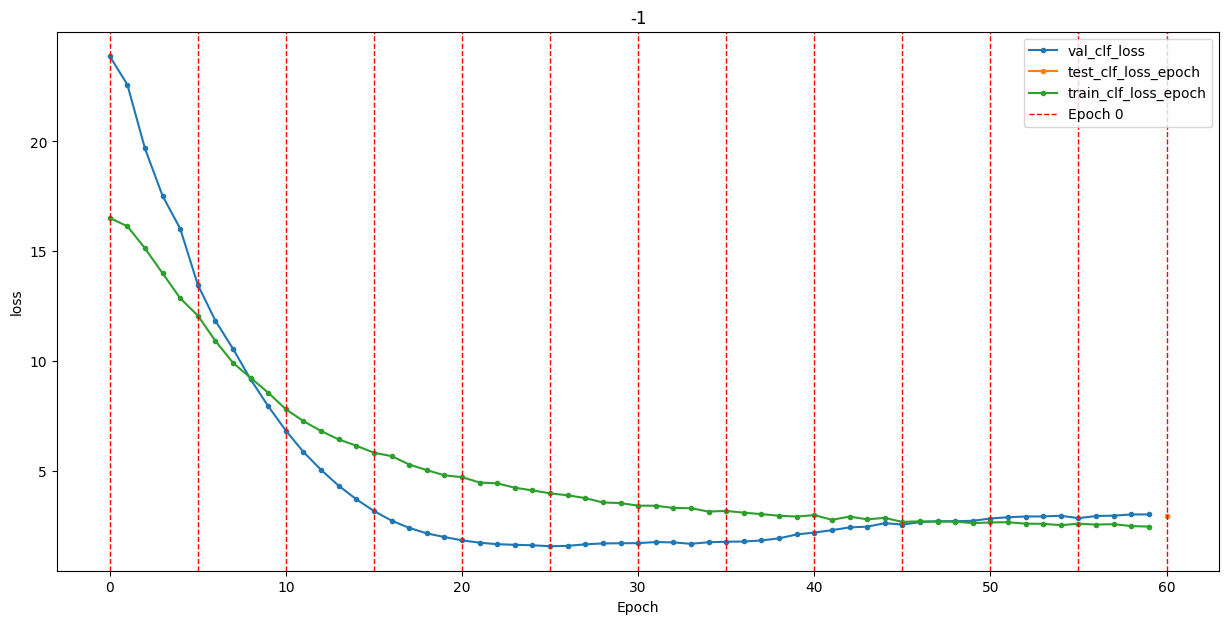

encoder and decoder structure: {'encoder': Sequential(
  (0): Sequential(
    (0): Linear(in_features=3737, out_features=3737, bias=True)
    (1): BatchNorm1d(3737, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
  )
  (1): Sequential(
    (0): Linear(in_features=3737, out_features=3737, bias=True)
    (1): BatchNorm1d(3737, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (2): Sequential(
    (0): Linear(in_features=3737, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (4): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(6

2025-03-09 11:21:48,943 INFO - lightning_fabric.utilities.seed - Global seed set to 1265 


detail information about structure save at： /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/-1/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_2/model.pth
the 2/7 fold train, use donor-0 as test set
the 2/7 fold train, use donor-0 as test set
Set x_sc_train data with shape (gene, cells): torch.Size([3737, 496])
Set x_sc_test data with shape (gene, cells): torch.Size([3737, 79])
label dictionary: {-1: -5.0, 0: -4.836, 3: -4.344, 9: -3.361, 15: -2.377, 18: -1.885, 60: 5.0}
Normalize train y_time_nor_train type: embryoneg5to5, with y_time_nor_train lable: [-1.  0.  3.  9. 15. 18. 60.], shape: torch.Size([496]), 
detail: [-5.    -4.836 -4.344 -3.361 -2.377 -1.885  5.   ]
Normalize test y_time_nor_train type: embryoneg5to5, with y_time_nor_train lable: [0.], shape: torch.Size([79]), 
detail: [-4.836]
Start training with epoch: 60. 


2025-03-09 11:21:49,300 INFO - pytorch_lightning.utilities.rank_zero - GPU available: True (cuda), used: True 
2025-03-09 11:21:49,300 INFO - pytorch_lightning.utilities.rank_zero - TPU available: False, using: 0 TPU cores 
2025-03-09 11:21:49,301 INFO - pytorch_lightning.utilities.rank_zero - IPU available: False, using: 0 IPUs 
2025-03-09 11:21:49,301 INFO - pytorch_lightning.utilities.rank_zero - HPU available: False, using: 0 HPUs 
2025-03-09 11:21:49,305 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 


don't set batch
Free Memory Percentage: 72.76%
[INFO] GPU device 2 - total: 40.0GB; - memory free: 39.377GB.
[INFO] GPU device 1 - total: 40.0GB; - memory free: 38.819GB.
[INFO] GPU device 0 - total: 40.0GB; - memory free: 38.817GB.

[INFO] more than 5% free memory, Auto select GPU device 2,- memory free: 39.377GB
Auto select run on cuda:2
======= Training SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial =======


2025-03-09 11:21:50,442 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 
2025-03-09 11:21:50,445 INFO - pytorch_lightning.callbacks.model_summary - 
  | Name  | Type                                                         | Params
---------------------------------------------------------------------------------------
0 | model | SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial | 44.0 M
---------------------------------------------------------------------------------------
44.0 M    Trainable params
0         Non-trainable params
44.0 M    Total params
175.829   Total estimated model params size (MB) 


Sanity Checking: 0it [00:00, ?it/s]

/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(82.5746, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.3201, device='cuda:2'), 'train_KLD_step': tensor(-6.0260, device='cuda:2'), 'train_clf_loss_step': tensor(16.2506, device='cuda:2'), 'val_loss': tensor(112.9765, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4134, device='cuda:2'), 'val_KLD': tensor(-0.3681, device='cuda:2'), 'val_clf_loss': tensor(22.3126, device='cuda:2'), 'train_loss_epoch': tensor(82.5746, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.3201, device='cuda:2'), 'train_KLD_epoch': tensor(-6.0260, device='cuda:2'), 'train_clf_loss_epoch': tensor(16.2506, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(80.9675, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.2941, device='cuda:2'), 'train_KLD_step': tensor(-6.6586, device='cuda:2'), 'train_clf_loss_step': tensor(15.9343, device='cuda:2'), 'val_loss': tensor(108.0747, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.5048, device='cuda:2'), 'val_KLD': tensor(-15.3537, device='cuda:2'), 'val_clf_loss': tensor(21.3132, device='cuda:2'), 'train_loss_epoch': tensor(80.9675, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.2941, device='cuda:2'), 'train_KLD_epoch': tensor(-6.6586, device='cuda:2'), 'train_clf_loss_epoch': tensor(15.9343, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(76.1150, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.2085, device='cuda:2'), 'train_KLD_step': tensor(-7.1987, device='cuda:2'), 'train_clf_loss_step': tensor(14.9809, device='cuda:2'), 'val_loss': tensor(98.5387, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.8851, device='cuda:2'), 'val_KLD': tensor(-87.5706, device='cuda:2'), 'val_clf_loss': tensor(19.3263, device='cuda:2'), 'train_loss_epoch': tensor(76.1150, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.2085, device='cuda:2'), 'train_KLD_epoch': tensor(-7.1987, device='cuda:2'), 'train_clf_loss_epoch': tensor(14.9809, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(69.8418, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.1517, device='cuda:2'), 'train_KLD_step': tensor(-8.9077, device='cuda:2'), 'train_clf_loss_step': tensor(13.7376, device='cuda:2'), 'val_loss': tensor(85.5474, device='cuda:2'), 'val_Reconstruction_loss': tensor(2.0772, device='cuda:2'), 'val_KLD': tensor(-194.9976, device='cuda:2'), 'val_clf_loss': tensor(16.6843, device='cuda:2'), 'train_loss_epoch': tensor(69.8418, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.1517, device='cuda:2'), 'train_KLD_epoch': tensor(-8.9077, device='cuda:2'), 'train_clf_loss_epoch': tensor(13.7376, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(64.7628, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.1197, device='cuda:2'), 'train_KLD_step': tensor(-10.7319, device='cuda:2'), 'train_clf_loss_step': tensor(12.7281, device='cuda:2'), 'val_loss': tensor(73.7033, device='cuda:2'), 'val_Reconstruction_loss': tensor(2.1018, device='cuda:2'), 'val_KLD': tensor(-230.0879, device='cuda:2'), 'val_clf_loss': tensor(14.3088, device='cuda:2'), 'train_loss_epoch': tensor(64.7628, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.1197, device='cuda:2'), 'train_KLD_epoch': tensor(-10.7319, device='cuda:2'), 'train_clf_loss_epoch': tensor(12.7281, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(59.5550, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0981, device='cuda:2'), 'train_KLD_step': tensor(-12.8327, device='cuda:2'), 'train_clf_loss_step': tensor(11.6907, device='cuda:2'), 'val_loss': tensor(64.5889, device='cuda:2'), 'val_Reconstruction_loss': tensor(2.1199, device='cuda:2'), 'val_KLD': tensor(-222.0988, device='cuda:2'), 'val_clf_loss': tensor(12.4827, device='cuda:2'), 'train_loss_epoch': tensor(59.5550, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0981, device='cuda:2'), 'train_KLD_epoch': tensor(-12.8327, device='cuda:2'), 'train_clf_loss_epoch': tensor(11.6907, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(54.2686, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0908, device='cuda:2'), 'train_KLD_step': tensor(-15.2525, device='cuda:2'), 'train_clf_loss_step': tensor(10.6348, device='cuda:2'), 'val_loss': tensor(56.5168, device='cuda:2'), 'val_Reconstruction_loss': tensor(2.1267, device='cuda:2'), 'val_KLD': tensor(-207.4007, device='cuda:2'), 'val_clf_loss': tensor(10.8676, device='cuda:2'), 'train_loss_epoch': tensor(54.2686, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0908, device='cuda:2'), 'train_KLD_epoch': tensor(-15.2525, device='cuda:2'), 'train_clf_loss_epoch': tensor(10.6348, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(50.8134, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0849, device='cuda:2'), 'train_KLD_step': tensor(-17.8548, device='cuda:2'), 'train_clf_loss_step': tensor(9.9448, device='cuda:2'), 'val_loss': tensor(50.1908, device='cuda:2'), 'val_Reconstruction_loss': tensor(2.1271, device='cuda:2'), 'val_KLD': tensor(-198.8379, device='cuda:2'), 'val_clf_loss': tensor(9.6028, device='cuda:2'), 'train_loss_epoch': tensor(50.8134, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0849, device='cuda:2'), 'train_KLD_epoch': tensor(-17.8548, device='cuda:2'), 'train_clf_loss_epoch': tensor(9.9448, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(46.8080, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0763, device='cuda:2'), 'train_KLD_step': tensor(-20.5470, device='cuda:2'), 'train_clf_loss_step': tensor(9.1453, device='cuda:2'), 'val_loss': tensor(44.1775, device='cuda:2'), 'val_Reconstruction_loss': tensor(2.1192, device='cuda:2'), 'val_KLD': tensor(-202.2484, device='cuda:2'), 'val_clf_loss': tensor(8.4015, device='cuda:2'), 'train_loss_epoch': tensor(46.8080, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0763, device='cuda:2'), 'train_KLD_epoch': tensor(-20.5470, device='cuda:2'), 'train_clf_loss_epoch': tensor(9.1453, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(43.1950, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0643, device='cuda:2'), 'train_KLD_step': tensor(-23.3070, device='cuda:2'), 'train_clf_loss_step': tensor(8.4250, device='cuda:2'), 'val_loss': tensor(38.8050, device='cuda:2'), 'val_Reconstruction_loss': tensor(2.1232, device='cuda:2'), 'val_KLD': tensor(-211.5722, device='cuda:2'), 'val_clf_loss': tensor(7.3258, device='cuda:2'), 'train_loss_epoch': tensor(43.1950, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0643, device='cuda:2'), 'train_KLD_epoch': tensor(-23.3070, device='cuda:2'), 'train_clf_loss_epoch': tensor(8.4250, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(41.2690, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0600, device='cuda:2'), 'train_KLD_step': tensor(-26.0552, device='cuda:2'), 'train_clf_loss_step': tensor(8.0405, device='cuda:2'), 'val_loss': tensor(34.0654, device='cuda:2'), 'val_Reconstruction_loss': tensor(2.1124, device='cuda:2'), 'val_KLD': tensor(-203.5023, device='cuda:2'), 'val_clf_loss': tensor(6.3804, device='cuda:2'), 'train_loss_epoch': tensor(41.2690, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0600, device='cuda:2'), 'train_KLD_epoch': tensor(-26.0552, device='cuda:2'), 'train_clf_loss_epoch': tensor(8.0405, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(38.4371, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0449, device='cuda:2'), 'train_KLD_step': tensor(-28.8016, device='cuda:2'), 'train_clf_loss_step': tensor(7.4770, device='cuda:2'), 'val_loss': tensor(29.6565, device='cuda:2'), 'val_Reconstruction_loss': tensor(2.0916, device='cuda:2'), 'val_KLD': tensor(-192.2301, device='cuda:2'), 'val_clf_loss': tensor(5.5034, device='cuda:2'), 'train_loss_epoch': tensor(38.4371, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0449, device='cuda:2'), 'train_KLD_epoch': tensor(-28.8016, device='cuda:2'), 'train_clf_loss_epoch': tensor(7.4770, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(36.1352, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0385, device='cuda:2'), 'train_KLD_step': tensor(-31.5126, device='cuda:2'), 'train_clf_loss_step': tensor(7.0178, device='cuda:2'), 'val_loss': tensor(25.4914, device='cuda:2'), 'val_Reconstruction_loss': tensor(2.0698, device='cuda:2'), 'val_KLD': tensor(-178.6837, device='cuda:2'), 'val_clf_loss': tensor(4.6754, device='cuda:2'), 'train_loss_epoch': tensor(36.1352, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0385, device='cuda:2'), 'train_KLD_epoch': tensor(-31.5126, device='cuda:2'), 'train_clf_loss_epoch': tensor(7.0178, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(33.9580, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0475, device='cuda:2'), 'train_KLD_step': tensor(-34.1321, device='cuda:2'), 'train_clf_loss_step': tensor(6.5804, device='cuda:2'), 'val_loss': tensor(21.7969, device='cuda:2'), 'val_Reconstruction_loss': tensor(2.0598, device='cuda:2'), 'val_KLD': tensor(-163.1584, device='cuda:2'), 'val_clf_loss': tensor(3.9393, device='cuda:2'), 'train_loss_epoch': tensor(33.9580, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0475, device='cuda:2'), 'train_KLD_epoch': tensor(-34.1321, device='cuda:2'), 'train_clf_loss_epoch': tensor(6.5804, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(31.4385, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0350, device='cuda:2'), 'train_KLD_step': tensor(-36.5768, device='cuda:2'), 'train_clf_loss_step': tensor(6.0789, device='cuda:2'), 'val_loss': tensor(18.9724, device='cuda:2'), 'val_Reconstruction_loss': tensor(2.0497, device='cuda:2'), 'val_KLD': tensor(-144.8149, device='cuda:2'), 'val_clf_loss': tensor(3.3773, device='cuda:2'), 'train_loss_epoch': tensor(31.4385, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0350, device='cuda:2'), 'train_KLD_epoch': tensor(-36.5768, device='cuda:2'), 'train_clf_loss_epoch': tensor(6.0789, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(30.5189, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0208, device='cuda:2'), 'train_KLD_step': tensor(-38.7653, device='cuda:2'), 'train_clf_loss_step': tensor(5.8977, device='cuda:2'), 'val_loss': tensor(16.4210, device='cuda:2'), 'val_Reconstruction_loss': tensor(2.0460, device='cuda:2'), 'val_KLD': tensor(-133.3613, device='cuda:2'), 'val_clf_loss': tensor(2.8683, device='cuda:2'), 'train_loss_epoch': tensor(30.5189, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0208, device='cuda:2'), 'train_KLD_epoch': tensor(-38.7653, device='cuda:2'), 'train_clf_loss_epoch': tensor(5.8977, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(29.0981, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0183, device='cuda:2'), 'train_KLD_step': tensor(-40.7285, device='cuda:2'), 'train_clf_loss_step': tensor(5.6139, device='cuda:2'), 'val_loss': tensor(13.8953, device='cuda:2'), 'val_Reconstruction_loss': tensor(2.0418, device='cuda:2'), 'val_KLD': tensor(-130.8809, device='cuda:2'), 'val_clf_loss': tensor(2.3642, device='cuda:2'), 'train_loss_epoch': tensor(29.0981, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0183, device='cuda:2'), 'train_KLD_epoch': tensor(-40.7285, device='cuda:2'), 'train_clf_loss_epoch': tensor(5.6139, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(27.7064, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0035, device='cuda:2'), 'train_KLD_step': tensor(-42.6403, device='cuda:2'), 'train_clf_loss_step': tensor(5.3385, device='cuda:2'), 'val_loss': tensor(11.8729, device='cuda:2'), 'val_Reconstruction_loss': tensor(2.0167, device='cuda:2'), 'val_KLD': tensor(-132.5219, device='cuda:2'), 'val_clf_loss': tensor(1.9646, device='cuda:2'), 'train_loss_epoch': tensor(27.7064, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0035, device='cuda:2'), 'train_KLD_epoch': tensor(-42.6403, device='cuda:2'), 'train_clf_loss_epoch': tensor(5.3385, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(26.1329, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0041, device='cuda:2'), 'train_KLD_step': tensor(-44.4729, device='cuda:2'), 'train_clf_loss_step': tensor(5.0235, device='cuda:2'), 'val_loss': tensor(10.4848, device='cuda:2'), 'val_Reconstruction_loss': tensor(2.0041, device='cuda:2'), 'val_KLD': tensor(-129.4381, device='cuda:2'), 'val_clf_loss': tensor(1.6897, device='cuda:2'), 'train_loss_epoch': tensor(26.1329, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0041, device='cuda:2'), 'train_KLD_epoch': tensor(-44.4729, device='cuda:2'), 'train_clf_loss_epoch': tensor(5.0235, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(24.8703, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9982, device='cuda:2'), 'train_KLD_step': tensor(-46.1071, device='cuda:2'), 'train_clf_loss_step': tensor(4.7721, device='cuda:2'), 'val_loss': tensor(9.5645, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.9728, device='cuda:2'), 'val_KLD': tensor(-122.8637, device='cuda:2'), 'val_clf_loss': tensor(1.5122, device='cuda:2'), 'train_loss_epoch': tensor(24.8703, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9982, device='cuda:2'), 'train_KLD_epoch': tensor(-46.1071, device='cuda:2'), 'train_clf_loss_epoch': tensor(4.7721, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(24.2515, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9999, device='cuda:2'), 'train_KLD_step': tensor(-47.5113, device='cuda:2'), 'train_clf_loss_step': tensor(4.6480, device='cuda:2'), 'val_loss': tensor(8.8713, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.9533, device='cuda:2'), 'val_KLD': tensor(-114.6176, device='cuda:2'), 'val_clf_loss': tensor(1.3779, device='cuda:2'), 'train_loss_epoch': tensor(24.2515, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9999, device='cuda:2'), 'train_KLD_epoch': tensor(-47.5113, device='cuda:2'), 'train_clf_loss_epoch': tensor(4.6480, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(22.9083, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0037, device='cuda:2'), 'train_KLD_step': tensor(-48.7440, device='cuda:2'), 'train_clf_loss_step': tensor(4.3785, device='cuda:2'), 'val_loss': tensor(8.3019, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.9238, device='cuda:2'), 'val_KLD': tensor(-107.0224, device='cuda:2'), 'val_clf_loss': tensor(1.2703, device='cuda:2'), 'train_loss_epoch': tensor(22.9083, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0037, device='cuda:2'), 'train_KLD_epoch': tensor(-48.7440, device='cuda:2'), 'train_clf_loss_epoch': tensor(4.3785, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(22.3837, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9942, device='cuda:2'), 'train_KLD_step': tensor(-49.8004, device='cuda:2'), 'train_clf_loss_step': tensor(4.2754, device='cuda:2'), 'val_loss': tensor(7.9507, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.9097, device='cuda:2'), 'val_KLD': tensor(-101.4163, device='cuda:2'), 'val_clf_loss': tensor(1.2031, device='cuda:2'), 'train_loss_epoch': tensor(22.3837, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9942, device='cuda:2'), 'train_KLD_epoch': tensor(-49.8004, device='cuda:2'), 'train_clf_loss_epoch': tensor(4.2754, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(21.5020, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9830, device='cuda:2'), 'train_KLD_step': tensor(-50.7791, device='cuda:2'), 'train_clf_loss_step': tensor(4.1013, device='cuda:2'), 'val_loss': tensor(7.4447, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.8837, device='cuda:2'), 'val_KLD': tensor(-99.9580, device='cuda:2'), 'val_clf_loss': tensor(1.1072, device='cuda:2'), 'train_loss_epoch': tensor(21.5020, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9830, device='cuda:2'), 'train_KLD_epoch': tensor(-50.7791, device='cuda:2'), 'train_clf_loss_epoch': tensor(4.1013, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.8371, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9805, device='cuda:2'), 'train_KLD_step': tensor(-51.8258, device='cuda:2'), 'train_clf_loss_step': tensor(3.9687, device='cuda:2'), 'val_loss': tensor(7.4318, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.8492, device='cuda:2'), 'val_KLD': tensor(-96.5999, device='cuda:2'), 'val_clf_loss': tensor(1.1117, device='cuda:2'), 'train_loss_epoch': tensor(20.8371, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9805, device='cuda:2'), 'train_KLD_epoch': tensor(-51.8258, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.9687, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.3305, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9781, device='cuda:2'), 'train_KLD_step': tensor(-52.7490, device='cuda:2'), 'train_clf_loss_step': tensor(3.8678, device='cuda:2'), 'val_loss': tensor(7.4348, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.8116, device='cuda:2'), 'val_KLD': tensor(-91.8269, device='cuda:2'), 'val_clf_loss': tensor(1.1200, device='cuda:2'), 'train_loss_epoch': tensor(20.3305, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9781, device='cuda:2'), 'train_KLD_epoch': tensor(-52.7490, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.8678, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(19.6097, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9802, device='cuda:2'), 'train_KLD_step': tensor(-53.5649, device='cuda:2'), 'train_clf_loss_step': tensor(3.7232, device='cuda:2'), 'val_loss': tensor(7.6991, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.7341, device='cuda:2'), 'val_KLD': tensor(-85.8871, device='cuda:2'), 'val_clf_loss': tensor(1.1887, device='cuda:2'), 'train_loss_epoch': tensor(19.6097, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9802, device='cuda:2'), 'train_KLD_epoch': tensor(-53.5649, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.7232, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(19.0147, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9810, device='cuda:2'), 'train_KLD_step': tensor(-54.3020, device='cuda:2'), 'train_clf_loss_step': tensor(3.6040, device='cuda:2'), 'val_loss': tensor(8.2431, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.7055, device='cuda:2'), 'val_KLD': tensor(-81.5431, device='cuda:2'), 'val_clf_loss': tensor(1.3035, device='cuda:2'), 'train_loss_epoch': tensor(19.0147, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9810, device='cuda:2'), 'train_KLD_epoch': tensor(-54.3020, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.6040, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(18.1584, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9725, device='cuda:2'), 'train_KLD_step': tensor(-55.0207, device='cuda:2'), 'train_clf_loss_step': tensor(3.4344, device='cuda:2'), 'val_loss': tensor(8.6878, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.6564, device='cuda:2'), 'val_KLD': tensor(-78.0392, device='cuda:2'), 'val_clf_loss': tensor(1.4024, device='cuda:2'), 'train_loss_epoch': tensor(18.1584, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9725, device='cuda:2'), 'train_KLD_epoch': tensor(-55.0207, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.4344, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(17.9236, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9645, device='cuda:2'), 'train_KLD_step': tensor(-55.6991, device='cuda:2'), 'train_clf_loss_step': tensor(3.3891, device='cuda:2'), 'val_loss': tensor(8.8997, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.6636, device='cuda:2'), 'val_KLD': tensor(-76.3473, device='cuda:2'), 'val_clf_loss': tensor(1.4434, device='cuda:2'), 'train_loss_epoch': tensor(17.9236, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9645, device='cuda:2'), 'train_KLD_epoch': tensor(-55.6991, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.3891, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(17.7556, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9564, device='cuda:2'), 'train_KLD_step': tensor(-56.3799, device='cuda:2'), 'train_clf_loss_step': tensor(3.3570, device='cuda:2'), 'val_loss': tensor(9.0835, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.6310, device='cuda:2'), 'val_KLD': tensor(-75.1103, device='cuda:2'), 'val_clf_loss': tensor(1.4868, device='cuda:2'), 'train_loss_epoch': tensor(17.7556, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9564, device='cuda:2'), 'train_KLD_epoch': tensor(-56.3799, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.3570, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(17.6836, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9623, device='cuda:2'), 'train_KLD_step': tensor(-56.9872, device='cuda:2'), 'train_clf_loss_step': tensor(3.3414, device='cuda:2'), 'val_loss': tensor(9.5273, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.5979, device='cuda:2'), 'val_KLD': tensor(-73.0783, device='cuda:2'), 'val_clf_loss': tensor(1.5822, device='cuda:2'), 'train_loss_epoch': tensor(17.6836, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9623, device='cuda:2'), 'train_KLD_epoch': tensor(-56.9872, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.3414, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.8570, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9616, device='cuda:2'), 'train_KLD_step': tensor(-57.5124, device='cuda:2'), 'train_clf_loss_step': tensor(3.1762, device='cuda:2'), 'val_loss': tensor(9.7317, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.6064, device='cuda:2'), 'val_KLD': tensor(-71.7803, device='cuda:2'), 'val_clf_loss': tensor(1.6215, device='cuda:2'), 'train_loss_epoch': tensor(16.8570, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9616, device='cuda:2'), 'train_KLD_epoch': tensor(-57.5124, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.1762, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.8586, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9571, device='cuda:2'), 'train_KLD_step': tensor(-58.0105, device='cuda:2'), 'train_clf_loss_step': tensor(3.1774, device='cuda:2'), 'val_loss': tensor(9.7165, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.6028, device='cuda:2'), 'val_KLD': tensor(-70.1445, device='cuda:2'), 'val_clf_loss': tensor(1.6192, device='cuda:2'), 'train_loss_epoch': tensor(16.8586, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9571, device='cuda:2'), 'train_KLD_epoch': tensor(-58.0105, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.1774, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.0265, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9538, device='cuda:2'), 'train_KLD_step': tensor(-58.4510, device='cuda:2'), 'train_clf_loss_step': tensor(3.0116, device='cuda:2'), 'val_loss': tensor(10.4608, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.5459, device='cuda:2'), 'val_KLD': tensor(-69.2720, device='cuda:2'), 'val_clf_loss': tensor(1.7795, device='cuda:2'), 'train_loss_epoch': tensor(16.0265, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9538, device='cuda:2'), 'train_KLD_epoch': tensor(-58.4510, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.0116, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.2470, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9452, device='cuda:2'), 'train_KLD_step': tensor(-58.8702, device='cuda:2'), 'train_clf_loss_step': tensor(3.0574, device='cuda:2'), 'val_loss': tensor(10.4107, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.5738, device='cuda:2'), 'val_KLD': tensor(-68.3557, device='cuda:2'), 'val_clf_loss': tensor(1.7640, device='cuda:2'), 'train_loss_epoch': tensor(16.2470, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9452, device='cuda:2'), 'train_KLD_epoch': tensor(-58.8702, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.0574, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(15.3821, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9498, device='cuda:2'), 'train_KLD_step': tensor(-59.2151, device='cuda:2'), 'train_clf_loss_step': tensor(2.8835, device='cuda:2'), 'val_loss': tensor(11.0328, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.5848, device='cuda:2'), 'val_KLD': tensor(-67.3094, device='cuda:2'), 'val_clf_loss': tensor(1.8862, device='cuda:2'), 'train_loss_epoch': tensor(15.3821, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9498, device='cuda:2'), 'train_KLD_epoch': tensor(-59.2151, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.8835, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(15.2094, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9447, device='cuda:2'), 'train_KLD_step': tensor(-59.5383, device='cuda:2'), 'train_clf_loss_step': tensor(2.8500, device='cuda:2'), 'val_loss': tensor(11.1558, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.5455, device='cuda:2'), 'val_KLD': tensor(-66.4319, device='cuda:2'), 'val_clf_loss': tensor(1.9187, device='cuda:2'), 'train_loss_epoch': tensor(15.2094, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9447, device='cuda:2'), 'train_KLD_epoch': tensor(-59.5383, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.8500, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(15.2433, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9517, device='cuda:2'), 'train_KLD_step': tensor(-59.8298, device='cuda:2'), 'train_clf_loss_step': tensor(2.8553, device='cuda:2'), 'val_loss': tensor(11.3592, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.5357, device='cuda:2'), 'val_KLD': tensor(-65.3810, device='cuda:2'), 'val_clf_loss': tensor(1.9614, device='cuda:2'), 'train_loss_epoch': tensor(15.2433, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9517, device='cuda:2'), 'train_KLD_epoch': tensor(-59.8298, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.8553, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.8837, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9504, device='cuda:2'), 'train_KLD_step': tensor(-60.1146, device='cuda:2'), 'train_clf_loss_step': tensor(2.7837, device='cuda:2'), 'val_loss': tensor(12.0657, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4946, device='cuda:2'), 'val_KLD': tensor(-63.9801, device='cuda:2'), 'val_clf_loss': tensor(2.1110, device='cuda:2'), 'train_loss_epoch': tensor(14.8837, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9504, device='cuda:2'), 'train_KLD_epoch': tensor(-60.1146, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.7837, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(15.2313, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9450, device='cuda:2'), 'train_KLD_step': tensor(-60.3770, device='cuda:2'), 'train_clf_loss_step': tensor(2.8542, device='cuda:2'), 'val_loss': tensor(12.8090, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4854, device='cuda:2'), 'val_KLD': tensor(-62.5696, device='cuda:2'), 'val_clf_loss': tensor(2.2616, device='cuda:2'), 'train_loss_epoch': tensor(15.2313, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9450, device='cuda:2'), 'train_KLD_epoch': tensor(-60.3770, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.8542, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.5722, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9463, device='cuda:2'), 'train_KLD_step': tensor(-60.6268, device='cuda:2'), 'train_clf_loss_step': tensor(2.7221, device='cuda:2'), 'val_loss': tensor(12.7889, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4950, device='cuda:2'), 'val_KLD': tensor(-60.8644, device='cuda:2'), 'val_clf_loss': tensor(2.2558, device='cuda:2'), 'train_loss_epoch': tensor(14.5722, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9463, device='cuda:2'), 'train_KLD_epoch': tensor(-60.6268, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.7221, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.6843, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9497, device='cuda:2'), 'train_KLD_step': tensor(-60.8485, device='cuda:2'), 'train_clf_loss_step': tensor(2.7439, device='cuda:2'), 'val_loss': tensor(12.9220, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4739, device='cuda:2'), 'val_KLD': tensor(-59.5173, device='cuda:2'), 'val_clf_loss': tensor(2.2866, device='cuda:2'), 'train_loss_epoch': tensor(14.6843, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9497, device='cuda:2'), 'train_KLD_epoch': tensor(-60.8485, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.7439, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.6316, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9402, device='cuda:2'), 'train_KLD_step': tensor(-61.0388, device='cuda:2'), 'train_clf_loss_step': tensor(2.7352, device='cuda:2'), 'val_loss': tensor(13.5033, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.5197, device='cuda:2'), 'val_KLD': tensor(-58.1992, device='cuda:2'), 'val_clf_loss': tensor(2.3938, device='cuda:2'), 'train_loss_epoch': tensor(14.6316, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9402, device='cuda:2'), 'train_KLD_epoch': tensor(-61.0388, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.7352, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.4851, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9365, device='cuda:2'), 'train_KLD_step': tensor(-61.1912, device='cuda:2'), 'train_clf_loss_step': tensor(2.7067, device='cuda:2'), 'val_loss': tensor(14.1883, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4566, device='cuda:2'), 'val_KLD': tensor(-57.3703, device='cuda:2'), 'val_clf_loss': tensor(2.5435, device='cuda:2'), 'train_loss_epoch': tensor(14.4851, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9365, device='cuda:2'), 'train_KLD_epoch': tensor(-61.1912, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.7067, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(13.8962, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9464, device='cuda:2'), 'train_KLD_step': tensor(-61.3318, device='cuda:2'), 'train_clf_loss_step': tensor(2.5869, device='cuda:2'), 'val_loss': tensor(14.4190, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4724, device='cuda:2'), 'val_KLD': tensor(-56.3835, device='cuda:2'), 'val_clf_loss': tensor(2.5865, device='cuda:2'), 'train_loss_epoch': tensor(13.8962, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9464, device='cuda:2'), 'train_KLD_epoch': tensor(-61.3318, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.5869, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(13.7596, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9341, device='cuda:2'), 'train_KLD_step': tensor(-61.4329, device='cuda:2'), 'train_clf_loss_step': tensor(2.5620, device='cuda:2'), 'val_loss': tensor(14.8504, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4691, device='cuda:2'), 'val_KLD': tensor(-55.8711, device='cuda:2'), 'val_clf_loss': tensor(2.6735, device='cuda:2'), 'train_loss_epoch': tensor(13.7596, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9341, device='cuda:2'), 'train_KLD_epoch': tensor(-61.4329, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.5620, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(13.2527, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9351, device='cuda:2'), 'train_KLD_step': tensor(-61.5356, device='cuda:2'), 'train_clf_loss_step': tensor(2.4605, device='cuda:2'), 'val_loss': tensor(14.6808, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4702, device='cuda:2'), 'val_KLD': tensor(-55.6295, device='cuda:2'), 'val_clf_loss': tensor(2.6393, device='cuda:2'), 'train_loss_epoch': tensor(13.2527, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9351, device='cuda:2'), 'train_KLD_epoch': tensor(-61.5356, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.4605, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.0903, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9436, device='cuda:2'), 'train_KLD_step': tensor(-61.6377, device='cuda:2'), 'train_clf_loss_step': tensor(2.6263, device='cuda:2'), 'val_loss': tensor(15.1015, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4791, device='cuda:2'), 'val_KLD': tensor(-55.8198, device='cuda:2'), 'val_clf_loss': tensor(2.7217, device='cuda:2'), 'train_loss_epoch': tensor(14.0903, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9436, device='cuda:2'), 'train_KLD_epoch': tensor(-61.6377, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.6263, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(13.2820, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9288, device='cuda:2'), 'train_KLD_step': tensor(-61.7797, device='cuda:2'), 'train_clf_loss_step': tensor(2.4676, device='cuda:2'), 'val_loss': tensor(14.7731, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4594, device='cuda:2'), 'val_KLD': tensor(-56.3859, device='cuda:2'), 'val_clf_loss': tensor(2.6599, device='cuda:2'), 'train_loss_epoch': tensor(13.2820, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9288, device='cuda:2'), 'train_KLD_epoch': tensor(-61.7797, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.4676, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(13.7611, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9251, device='cuda:2'), 'train_KLD_step': tensor(-61.9237, device='cuda:2'), 'train_clf_loss_step': tensor(2.5641, device='cuda:2'), 'val_loss': tensor(14.5839, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4381, device='cuda:2'), 'val_KLD': tensor(-56.9549, device='cuda:2'), 'val_clf_loss': tensor(2.6263, device='cuda:2'), 'train_loss_epoch': tensor(13.7611, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9251, device='cuda:2'), 'train_KLD_epoch': tensor(-61.9237, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.5641, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(13.2034, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9341, device='cuda:2'), 'train_KLD_step': tensor(-62.0408, device='cuda:2'), 'train_clf_loss_step': tensor(2.4508, device='cuda:2'), 'val_loss': tensor(14.7614, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4479, device='cuda:2'), 'val_KLD': tensor(-57.5321, device='cuda:2'), 'val_clf_loss': tensor(2.6598, device='cuda:2'), 'train_loss_epoch': tensor(13.2034, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9341, device='cuda:2'), 'train_KLD_epoch': tensor(-62.0408, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.4508, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(13.1101, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9253, device='cuda:2'), 'train_KLD_step': tensor(-62.1473, device='cuda:2'), 'train_clf_loss_step': tensor(2.4338, device='cuda:2'), 'val_loss': tensor(14.7472, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4329, device='cuda:2'), 'val_KLD': tensor(-57.8309, device='cuda:2'), 'val_clf_loss': tensor(2.6600, device='cuda:2'), 'train_loss_epoch': tensor(13.1101, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9253, device='cuda:2'), 'train_KLD_epoch': tensor(-62.1473, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.4338, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(12.8848, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9262, device='cuda:2'), 'train_KLD_step': tensor(-62.2398, device='cuda:2'), 'train_clf_loss_step': tensor(2.3886, device='cuda:2'), 'val_loss': tensor(14.8261, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4316, device='cuda:2'), 'val_KLD': tensor(-57.6885, device='cuda:2'), 'val_clf_loss': tensor(2.6760, device='cuda:2'), 'train_loss_epoch': tensor(12.8848, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9262, device='cuda:2'), 'train_KLD_epoch': tensor(-62.2398, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.3886, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(13.1501, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9308, device='cuda:2'), 'train_KLD_step': tensor(-62.3099, device='cuda:2'), 'train_clf_loss_step': tensor(2.4407, device='cuda:2'), 'val_loss': tensor(14.7118, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4378, device='cuda:2'), 'val_KLD': tensor(-57.4530, device='cuda:2'), 'val_clf_loss': tensor(2.6519, device='cuda:2'), 'train_loss_epoch': tensor(13.1501, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9308, device='cuda:2'), 'train_KLD_epoch': tensor(-62.3099, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.4407, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(12.8097, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9267, device='cuda:2'), 'train_KLD_step': tensor(-62.3860, device='cuda:2'), 'train_clf_loss_step': tensor(2.3735, device='cuda:2'), 'val_loss': tensor(14.4857, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4351, device='cuda:2'), 'val_KLD': tensor(-57.0903, device='cuda:2'), 'val_clf_loss': tensor(2.6073, device='cuda:2'), 'train_loss_epoch': tensor(12.8097, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9267, device='cuda:2'), 'train_KLD_epoch': tensor(-62.3860, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.3735, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(12.7609, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9349, device='cuda:2'), 'train_KLD_step': tensor(-62.4392, device='cuda:2'), 'train_clf_loss_step': tensor(2.3621, device='cuda:2'), 'val_loss': tensor(14.6942, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4256, device='cuda:2'), 'val_KLD': tensor(-56.6947, device='cuda:2'), 'val_clf_loss': tensor(2.6509, device='cuda:2'), 'train_loss_epoch': tensor(12.7609, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9349, device='cuda:2'), 'train_KLD_epoch': tensor(-62.4392, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.3621, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(12.9364, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9302, device='cuda:2'), 'train_KLD_step': tensor(-62.4918, device='cuda:2'), 'train_clf_loss_step': tensor(2.3981, device='cuda:2'), 'val_loss': tensor(14.9850, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4262, device='cuda:2'), 'val_KLD': tensor(-56.1588, device='cuda:2'), 'val_clf_loss': tensor(2.7090, device='cuda:2'), 'train_loss_epoch': tensor(12.9364, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9302, device='cuda:2'), 'train_KLD_epoch': tensor(-62.4918, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.3981, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(12.4113, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9296, device='cuda:2'), 'train_KLD_step': tensor(-62.5217, device='cuda:2'), 'train_clf_loss_step': tensor(2.2932, device='cuda:2'), 'val_loss': tensor(15.6331, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4092, device='cuda:2'), 'val_KLD': tensor(-55.7054, device='cuda:2'), 'val_clf_loss': tensor(2.8420, device='cuda:2'), 'train_loss_epoch': tensor(12.4113, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9296, device='cuda:2'), 'train_KLD_epoch': tensor(-62.5217, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.2932, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(12.7630, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(0.9311, device='cuda:2'), 'train_KLD_step': tensor(-62.5447, device='cuda:2'), 'train_clf_loss_step': tensor(2.3632, device='cuda:2'), 'val_loss': tensor(15.9026, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4410, device='cuda:2'), 'val_KLD': tensor(-55.1792, device='cuda:2'), 'val_clf_loss': tensor(2.8896, device='cuda:2'), 'train_loss_epoch': tensor(12.7630, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(0.9311, device='cuda:2'), 'train_KLD_epoch': tensor(-62.5447, device='cuda:2'), 'train_clf_loss_epoch': tensor(2.3632, device='cuda:2')}


2025-03-09 11:24:54,989 INFO - pytorch_lightning.utilities.rank_zero - `Trainer.fit` stopped: `max_epochs=60` reached. 
2025-03-09 11:24:55,299 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:24:55,366 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 
/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on 

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_KLD_epoch         │       -55.1791877746582        │
│ test_Reconstruction_loss_epoch │       1.4260082244873047       │
│      test_clf_loss_epoch       │       2.848827362060547        │
│        test_loss_epoch         │       15.683939933776855       │
└────────────────────────────────┴────────────────────────────────┘

2025-03-09 11:24:55,770 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:24:55,817 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 


this epoch final, on test data:[{'test_loss_epoch': 15.683939933776855, 'test_Reconstruction_loss_epoch': 1.4260082244873047, 'test_KLD_epoch': -55.1791877746582, 'test_clf_loss_epoch': 2.848827362060547}]


/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

2025-03-09 11:24:56,224 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:24:56,279 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 


Predicting: 0it [00:00, ?it/s]

2025-03-09 11:24:56,680 INFO - tensorboard - Directory watcher advancing from /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/0/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_2/events.out.tfevents.1741537310.GPU2.1181448.3 to /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/0/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_2/events.out.tfevents.1741537495.GPU2.1181448.4 
2025-03-09 11:24:56,682 INFO - tensorboard - No path found after /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/0/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_2/events.out.tfevents.1741537495.GPU2.1181448.4 
2025-03-09 11:24:56,682 INFO - TemporalVAE.utils.utils_Dandan_plot - plot training process. 
2025-03-09 11:24:56,695 INFO - tensorboard - 

The Array does not contain NaN values
predicted time of test donor is continuous.
Plot training loss line for check.
All tags in logger: ['lr-Adam', 'train_loss_step', 'train_Reconstruction_loss_step', 'train_KLD_step', 'train_clf_loss_step', 'epoch', 'val_loss', 'val_Reconstruction_loss', 'val_KLD', 'val_clf_loss', 'train_loss_epoch', 'train_Reconstruction_loss_epoch', 'train_KLD_epoch', 'train_clf_loss_epoch', 'test_loss_step', 'test_Reconstruction_loss_step', 'test_KLD_step', 'test_clf_loss_step', 'test_loss_epoch', 'test_Reconstruction_loss_epoch', 'test_KLD_epoch', 'test_clf_loss_epoch']
plot tags ['val_clf_loss', 'test_clf_loss_epoch', 'train_clf_loss_epoch']


2025-03-09 11:24:56,913 INFO - TemporalVAE.utils.utils_Dandan_plot - Finish save images at: /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/0/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_2/trainingLoss_val_clf_loss_test_clf_loss_epoch_train_clf_loss_epoch_0.png 


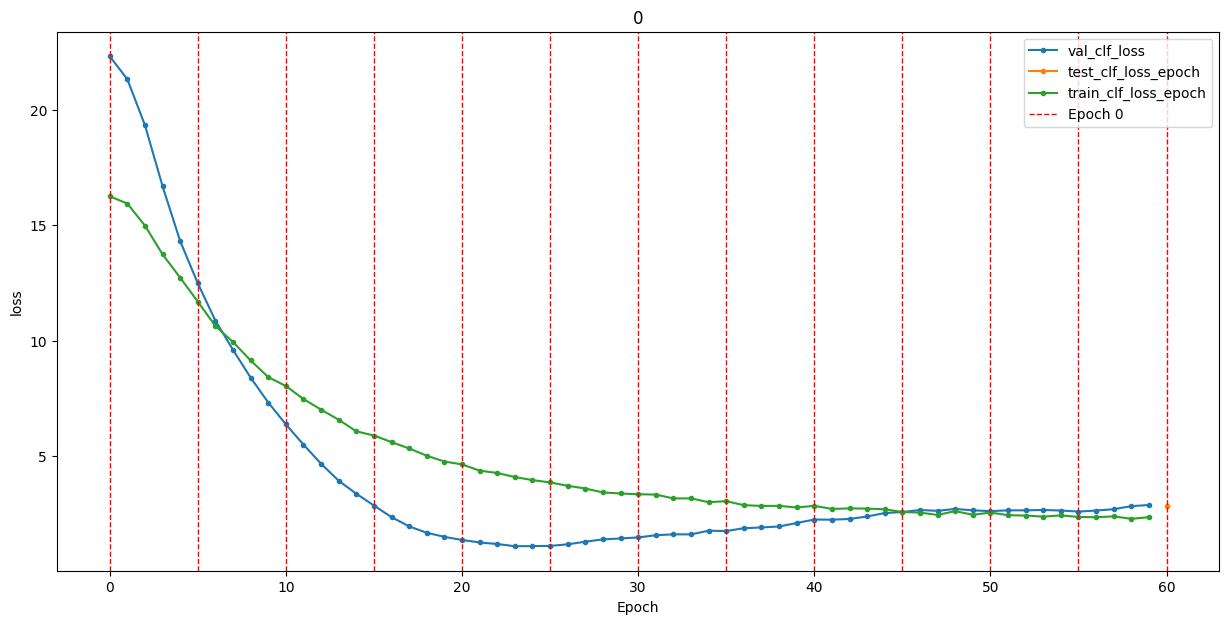

encoder and decoder structure: {'encoder': Sequential(
  (0): Sequential(
    (0): Linear(in_features=3737, out_features=3737, bias=True)
    (1): BatchNorm1d(3737, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
  )
  (1): Sequential(
    (0): Linear(in_features=3737, out_features=3737, bias=True)
    (1): BatchNorm1d(3737, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (2): Sequential(
    (0): Linear(in_features=3737, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (4): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(6

2025-03-09 11:24:57,531 INFO - lightning_fabric.utilities.seed - Global seed set to 1265 


detail information about structure save at： /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/0/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_2/model.pth
the 3/7 fold train, use donor-3 as test set
the 3/7 fold train, use donor-3 as test set
Set x_sc_train data with shape (gene, cells): torch.Size([3737, 492])
Set x_sc_test data with shape (gene, cells): torch.Size([3737, 83])
label dictionary: {-1: -5.0, 0: -4.836, 3: -4.344, 9: -3.361, 15: -2.377, 18: -1.885, 60: 5.0}
Normalize train y_time_nor_train type: embryoneg5to5, with y_time_nor_train lable: [-1.  0.  3.  9. 15. 18. 60.], shape: torch.Size([492]), 
detail: [-5.    -4.836 -4.344 -3.361 -2.377 -1.885  5.   ]
Normalize test y_time_nor_train type: embryoneg5to5, with y_time_nor_train lable: [3.], shape: torch.Size([83]), 
detail: [-4.344]
Start training with epoch: 60. 


2025-03-09 11:24:57,882 INFO - pytorch_lightning.utilities.rank_zero - GPU available: True (cuda), used: True 
2025-03-09 11:24:57,882 INFO - pytorch_lightning.utilities.rank_zero - TPU available: False, using: 0 TPU cores 
2025-03-09 11:24:57,883 INFO - pytorch_lightning.utilities.rank_zero - IPU available: False, using: 0 IPUs 
2025-03-09 11:24:57,883 INFO - pytorch_lightning.utilities.rank_zero - HPU available: False, using: 0 HPUs 
2025-03-09 11:24:57,896 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:24:57,932 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 
2025-03-09

don't set batch
Free Memory Percentage: 72.47%
[INFO] GPU device 2 - total: 40.0GB; - memory free: 38.815GB.
[INFO] GPU device 1 - total: 40.0GB; - memory free: 38.819GB.
[INFO] GPU device 0 - total: 40.0GB; - memory free: 38.817GB.

[INFO] more than 5% free memory, Auto select GPU device 1,- memory free: 38.819GB
Auto select run on cuda:1
======= Training SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial =======


Sanity Checking: 0it [00:00, ?it/s]

/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(86.4882, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.3696, device='cuda:1'), 'train_KLD_step': tensor(-6.0245, device='cuda:1'), 'train_clf_loss_step': tensor(17.0234, device='cuda:1'), 'val_loss': tensor(90.6036, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1037, device='cuda:1'), 'val_KLD': tensor(-0.3586, device='cuda:1'), 'val_clf_loss': tensor(17.9000, device='cuda:1'), 'train_loss_epoch': tensor(86.4882, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.3696, device='cuda:1'), 'train_KLD_epoch': tensor(-6.0245, device='cuda:1'), 'train_clf_loss_epoch': tensor(17.0234, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(84.4769, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.3668, device='cuda:1'), 'train_KLD_step': tensor(-6.4059, device='cuda:1'), 'train_clf_loss_step': tensor(16.6217, device='cuda:1'), 'val_loss': tensor(88.0359, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1379, device='cuda:1'), 'val_KLD': tensor(-6.8936, device='cuda:1'), 'val_clf_loss': tensor(17.3793, device='cuda:1'), 'train_loss_epoch': tensor(84.4769, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.3668, device='cuda:1'), 'train_KLD_epoch': tensor(-6.4059, device='cuda:1'), 'train_clf_loss_epoch': tensor(16.6217, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(80.3757, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.2850, device='cuda:1'), 'train_KLD_step': tensor(-7.5107, device='cuda:1'), 'train_clf_loss_step': tensor(15.8178, device='cuda:1'), 'val_loss': tensor(83.0273, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.3111, device='cuda:1'), 'val_KLD': tensor(-44.8346, device='cuda:1'), 'val_clf_loss': tensor(16.3410, device='cuda:1'), 'train_loss_epoch': tensor(80.3757, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.2850, device='cuda:1'), 'train_KLD_epoch': tensor(-7.5107, device='cuda:1'), 'train_clf_loss_epoch': tensor(15.8178, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(73.0419, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1874, device='cuda:1'), 'train_KLD_step': tensor(-9.5740, device='cuda:1'), 'train_clf_loss_step': tensor(14.3704, device='cuda:1'), 'val_loss': tensor(77.1034, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.5676, device='cuda:1'), 'val_KLD': tensor(-117.5811, device='cuda:1'), 'val_clf_loss': tensor(15.1013, device='cuda:1'), 'train_loss_epoch': tensor(73.0419, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1874, device='cuda:1'), 'train_KLD_epoch': tensor(-9.5740, device='cuda:1'), 'train_clf_loss_epoch': tensor(14.3704, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(66.9531, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1516, device='cuda:1'), 'train_KLD_step': tensor(-11.4826, device='cuda:1'), 'train_clf_loss_step': tensor(13.1597, device='cuda:1'), 'val_loss': tensor(72.9455, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.7094, device='cuda:1'), 'val_KLD': tensor(-147.4507, device='cuda:1'), 'val_clf_loss': tensor(14.2399, device='cuda:1'), 'train_loss_epoch': tensor(66.9531, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1516, device='cuda:1'), 'train_KLD_epoch': tensor(-11.4826, device='cuda:1'), 'train_clf_loss_epoch': tensor(13.1597, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(62.4665, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1194, device='cuda:1'), 'train_KLD_step': tensor(-13.6373, device='cuda:1'), 'train_clf_loss_step': tensor(12.2687, device='cuda:1'), 'val_loss': tensor(68.2678, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.7534, device='cuda:1'), 'val_KLD': tensor(-139.9322, device='cuda:1'), 'val_clf_loss': tensor(13.2959, device='cuda:1'), 'train_loss_epoch': tensor(62.4665, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1194, device='cuda:1'), 'train_KLD_epoch': tensor(-13.6373, device='cuda:1'), 'train_clf_loss_epoch': tensor(12.2687, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(57.7188, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1221, device='cuda:1'), 'train_KLD_step': tensor(-16.2718, device='cuda:1'), 'train_clf_loss_step': tensor(11.3185, device='cuda:1'), 'val_loss': tensor(61.6601, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.7673, device='cuda:1'), 'val_KLD': tensor(-122.8909, device='cuda:1'), 'val_clf_loss': tensor(11.9724, device='cuda:1'), 'train_loss_epoch': tensor(57.7188, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1221, device='cuda:1'), 'train_KLD_epoch': tensor(-16.2718, device='cuda:1'), 'train_clf_loss_epoch': tensor(11.3185, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(52.0013, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1128, device='cuda:1'), 'train_KLD_step': tensor(-19.0512, device='cuda:1'), 'train_clf_loss_step': tensor(10.1767, device='cuda:1'), 'val_loss': tensor(57.6521, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.7625, device='cuda:1'), 'val_KLD': tensor(-103.6398, device='cuda:1'), 'val_clf_loss': tensor(11.1727, device='cuda:1'), 'train_loss_epoch': tensor(52.0013, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1128, device='cuda:1'), 'train_KLD_epoch': tensor(-19.0512, device='cuda:1'), 'train_clf_loss_epoch': tensor(10.1767, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(49.0032, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1058, device='cuda:1'), 'train_KLD_step': tensor(-21.8085, device='cuda:1'), 'train_clf_loss_step': tensor(9.5784, device='cuda:1'), 'val_loss': tensor(50.7166, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.7314, device='cuda:1'), 'val_KLD': tensor(-94.5264, device='cuda:1'), 'val_clf_loss': tensor(9.7923, device='cuda:1'), 'train_loss_epoch': tensor(49.0032, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1058, device='cuda:1'), 'train_KLD_epoch': tensor(-21.8085, device='cuda:1'), 'train_clf_loss_epoch': tensor(9.5784, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(45.0431, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1099, device='cuda:1'), 'train_KLD_step': tensor(-24.5932, device='cuda:1'), 'train_clf_loss_step': tensor(8.7854, device='cuda:1'), 'val_loss': tensor(48.8825, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.7205, device='cuda:1'), 'val_KLD': tensor(-88.8786, device='cuda:1'), 'val_clf_loss': tensor(9.4279, device='cuda:1'), 'train_loss_epoch': tensor(45.0431, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1099, device='cuda:1'), 'train_KLD_epoch': tensor(-24.5932, device='cuda:1'), 'train_clf_loss_epoch': tensor(8.7854, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(42.3262, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0822, device='cuda:1'), 'train_KLD_step': tensor(-27.3772, device='cuda:1'), 'train_clf_loss_step': tensor(8.2474, device='cuda:1'), 'val_loss': tensor(44.1678, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.7063, device='cuda:1'), 'val_KLD': tensor(-81.7889, device='cuda:1'), 'val_clf_loss': tensor(8.4882, device='cuda:1'), 'train_loss_epoch': tensor(42.3262, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0822, device='cuda:1'), 'train_KLD_epoch': tensor(-27.3772, device='cuda:1'), 'train_clf_loss_epoch': tensor(8.2474, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(40.1982, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0884, device='cuda:1'), 'train_KLD_step': tensor(-30.0783, device='cuda:1'), 'train_clf_loss_step': tensor(7.8205, device='cuda:1'), 'val_loss': tensor(40.6194, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.6454, device='cuda:1'), 'val_KLD': tensor(-75.0938, device='cuda:1'), 'val_clf_loss': tensor(7.7910, device='cuda:1'), 'train_loss_epoch': tensor(40.1982, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0884, device='cuda:1'), 'train_KLD_epoch': tensor(-30.0783, device='cuda:1'), 'train_clf_loss_epoch': tensor(7.8205, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(37.1827, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0824, device='cuda:1'), 'train_KLD_step': tensor(-32.6604, device='cuda:1'), 'train_clf_loss_step': tensor(7.2184, device='cuda:1'), 'val_loss': tensor(35.8097, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.6049, device='cuda:1'), 'val_KLD': tensor(-69.9472, device='cuda:1'), 'val_clf_loss': tensor(6.8375, device='cuda:1'), 'train_loss_epoch': tensor(37.1827, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0824, device='cuda:1'), 'train_KLD_epoch': tensor(-32.6604, device='cuda:1'), 'train_clf_loss_epoch': tensor(7.2184, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(35.3778, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0799, device='cuda:1'), 'train_KLD_step': tensor(-35.2294, device='cuda:1'), 'train_clf_loss_step': tensor(6.8578, device='cuda:1'), 'val_loss': tensor(32.9297, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.5824, device='cuda:1'), 'val_KLD': tensor(-63.5940, device='cuda:1'), 'val_clf_loss': tensor(6.2663, device='cuda:1'), 'train_loss_epoch': tensor(35.3778, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0799, device='cuda:1'), 'train_KLD_epoch': tensor(-35.2294, device='cuda:1'), 'train_clf_loss_epoch': tensor(6.8578, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(33.0787, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0659, device='cuda:1'), 'train_KLD_step': tensor(-37.6748, device='cuda:1'), 'train_clf_loss_step': tensor(6.4007, device='cuda:1'), 'val_loss': tensor(28.6174, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.5789, device='cuda:1'), 'val_KLD': tensor(-56.8790, device='cuda:1'), 'val_clf_loss': tensor(5.4049, device='cuda:1'), 'train_loss_epoch': tensor(33.0787, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0659, device='cuda:1'), 'train_KLD_epoch': tensor(-37.6748, device='cuda:1'), 'train_clf_loss_epoch': tensor(6.4007, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(31.8391, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0706, device='cuda:1'), 'train_KLD_step': tensor(-39.8970, device='cuda:1'), 'train_clf_loss_step': tensor(6.1517, device='cuda:1'), 'val_loss': tensor(26.9433, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.5316, device='cuda:1'), 'val_KLD': tensor(-50.7689, device='cuda:1'), 'val_clf_loss': tensor(5.0798, device='cuda:1'), 'train_loss_epoch': tensor(31.8391, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0706, device='cuda:1'), 'train_KLD_epoch': tensor(-39.8970, device='cuda:1'), 'train_clf_loss_epoch': tensor(6.1517, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(30.0912, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0746, device='cuda:1'), 'train_KLD_step': tensor(-41.8807, device='cuda:1'), 'train_clf_loss_step': tensor(5.8012, device='cuda:1'), 'val_loss': tensor(23.7541, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.4977, device='cuda:1'), 'val_KLD': tensor(-46.7916, device='cuda:1'), 'val_clf_loss': tensor(4.4489, device='cuda:1'), 'train_loss_epoch': tensor(30.0912, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0746, device='cuda:1'), 'train_KLD_epoch': tensor(-41.8807, device='cuda:1'), 'train_clf_loss_epoch': tensor(5.8012, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(28.5384, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0556, device='cuda:1'), 'train_KLD_step': tensor(-43.6672, device='cuda:1'), 'train_clf_loss_step': tensor(5.4944, device='cuda:1'), 'val_loss': tensor(21.6912, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.4461, device='cuda:1'), 'val_KLD': tensor(-44.3441, device='cuda:1'), 'val_clf_loss': tensor(4.0468, device='cuda:1'), 'train_loss_epoch': tensor(28.5384, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0556, device='cuda:1'), 'train_KLD_epoch': tensor(-43.6672, device='cuda:1'), 'train_clf_loss_epoch': tensor(5.4944, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(27.1148, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0479, device='cuda:1'), 'train_KLD_step': tensor(-45.3291, device='cuda:1'), 'train_clf_loss_step': tensor(5.2111, device='cuda:1'), 'val_loss': tensor(18.3954, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.4067, device='cuda:1'), 'val_KLD': tensor(-41.9707, device='cuda:1'), 'val_clf_loss': tensor(3.3956, device='cuda:1'), 'train_loss_epoch': tensor(27.1148, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0479, device='cuda:1'), 'train_KLD_epoch': tensor(-45.3291, device='cuda:1'), 'train_clf_loss_epoch': tensor(5.2111, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(25.7312, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0517, device='cuda:1'), 'train_KLD_step': tensor(-46.8173, device='cuda:1'), 'train_clf_loss_step': tensor(4.9335, device='cuda:1'), 'val_loss': tensor(21.1269, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.3314, device='cuda:1'), 'val_KLD': tensor(-39.5758, device='cuda:1'), 'val_clf_loss': tensor(3.9571, device='cuda:1'), 'train_loss_epoch': tensor(25.7312, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0517, device='cuda:1'), 'train_KLD_epoch': tensor(-46.8173, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.9335, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(25.0850, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0462, device='cuda:1'), 'train_KLD_step': tensor(-48.1655, device='cuda:1'), 'train_clf_loss_step': tensor(4.8054, device='cuda:1'), 'val_loss': tensor(19.0927, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.3172, device='cuda:1'), 'val_KLD': tensor(-37.2275, device='cuda:1'), 'val_clf_loss': tensor(3.5532, device='cuda:1'), 'train_loss_epoch': tensor(25.0850, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0462, device='cuda:1'), 'train_KLD_epoch': tensor(-48.1655, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.8054, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(24.6508, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0379, device='cuda:1'), 'train_KLD_step': tensor(-49.3962, device='cuda:1'), 'train_clf_loss_step': tensor(4.7201, device='cuda:1'), 'val_loss': tensor(15.9529, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.2797, device='cuda:1'), 'val_KLD': tensor(-35.6571, device='cuda:1'), 'val_clf_loss': tensor(2.9328, device='cuda:1'), 'train_loss_epoch': tensor(24.6508, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0379, device='cuda:1'), 'train_KLD_epoch': tensor(-49.3962, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.7201, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(23.4112, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0324, device='cuda:1'), 'train_KLD_step': tensor(-50.5675, device='cuda:1'), 'train_clf_loss_step': tensor(4.4732, device='cuda:1'), 'val_loss': tensor(18.2220, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.2556, device='cuda:1'), 'val_KLD': tensor(-34.0590, device='cuda:1'), 'val_clf_loss': tensor(3.3916, device='cuda:1'), 'train_loss_epoch': tensor(23.4112, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0324, device='cuda:1'), 'train_KLD_epoch': tensor(-50.5675, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.4732, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(22.3295, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0288, device='cuda:1'), 'train_KLD_step': tensor(-51.6234, device='cuda:1'), 'train_clf_loss_step': tensor(4.2576, device='cuda:1'), 'val_loss': tensor(18.1024, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.2474, device='cuda:1'), 'val_KLD': tensor(-32.7958, device='cuda:1'), 'val_clf_loss': tensor(3.3694, device='cuda:1'), 'train_loss_epoch': tensor(22.3295, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0288, device='cuda:1'), 'train_KLD_epoch': tensor(-51.6234, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.2576, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(22.1013, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0242, device='cuda:1'), 'train_KLD_step': tensor(-52.5967, device='cuda:1'), 'train_clf_loss_step': tensor(4.2128, device='cuda:1'), 'val_loss': tensor(16.8059, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.2360, device='cuda:1'), 'val_KLD': tensor(-31.5505, device='cuda:1'), 'val_clf_loss': tensor(3.1124, device='cuda:1'), 'train_loss_epoch': tensor(22.1013, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0242, device='cuda:1'), 'train_KLD_epoch': tensor(-52.5967, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.2128, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(21.4553, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0178, device='cuda:1'), 'train_KLD_step': tensor(-53.4404, device='cuda:1'), 'train_clf_loss_step': tensor(4.0848, device='cuda:1'), 'val_loss': tensor(17.1656, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.2358, device='cuda:1'), 'val_KLD': tensor(-30.7876, device='cuda:1'), 'val_clf_loss': tensor(3.1844, device='cuda:1'), 'train_loss_epoch': tensor(21.4553, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0178, device='cuda:1'), 'train_KLD_epoch': tensor(-53.4404, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.0848, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.6453, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0211, device='cuda:1'), 'train_KLD_step': tensor(-54.2430, device='cuda:1'), 'train_clf_loss_step': tensor(3.9221, device='cuda:1'), 'val_loss': tensor(16.7335, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1977, device='cuda:1'), 'val_KLD': tensor(-29.8578, device='cuda:1'), 'val_clf_loss': tensor(3.1057, device='cuda:1'), 'train_loss_epoch': tensor(20.6453, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0211, device='cuda:1'), 'train_KLD_epoch': tensor(-54.2430, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.9221, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.5306, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0125, device='cuda:1'), 'train_KLD_step': tensor(-54.9724, device='cuda:1'), 'train_clf_loss_step': tensor(3.9009, device='cuda:1'), 'val_loss': tensor(16.7454, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1916, device='cuda:1'), 'val_KLD': tensor(-28.7646, device='cuda:1'), 'val_clf_loss': tensor(3.1093, device='cuda:1'), 'train_loss_epoch': tensor(20.5306, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0125, device='cuda:1'), 'train_KLD_epoch': tensor(-54.9724, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.9009, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(19.4645, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0064, device='cuda:1'), 'train_KLD_step': tensor(-55.6175, device='cuda:1'), 'train_clf_loss_step': tensor(3.6888, device='cuda:1'), 'val_loss': tensor(17.8538, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1880, device='cuda:1'), 'val_KLD': tensor(-27.5649, device='cuda:1'), 'val_clf_loss': tensor(3.3318, device='cuda:1'), 'train_loss_epoch': tensor(19.4645, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0064, device='cuda:1'), 'train_KLD_epoch': tensor(-55.6175, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.6888, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(19.0364, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0023, device='cuda:1'), 'train_KLD_step': tensor(-56.1665, device='cuda:1'), 'train_clf_loss_step': tensor(3.6040, device='cuda:1'), 'val_loss': tensor(18.5323, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1799, device='cuda:1'), 'val_KLD': tensor(-26.7546, device='cuda:1'), 'val_clf_loss': tensor(3.4691, device='cuda:1'), 'train_loss_epoch': tensor(19.0364, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0023, device='cuda:1'), 'train_KLD_epoch': tensor(-56.1665, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.6040, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(18.6533, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9945, device='cuda:1'), 'train_KLD_step': tensor(-56.6804, device='cuda:1'), 'train_clf_loss_step': tensor(3.5289, device='cuda:1'), 'val_loss': tensor(18.7704, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1752, device='cuda:1'), 'val_KLD': tensor(-26.3816, device='cuda:1'), 'val_clf_loss': tensor(3.5177, device='cuda:1'), 'train_loss_epoch': tensor(18.6533, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9945, device='cuda:1'), 'train_KLD_epoch': tensor(-56.6804, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.5289, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(18.3902, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0039, device='cuda:1'), 'train_KLD_step': tensor(-57.1827, device='cuda:1'), 'train_clf_loss_step': tensor(3.4744, device='cuda:1'), 'val_loss': tensor(19.3447, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1841, device='cuda:1'), 'val_KLD': tensor(-26.1735, device='cuda:1'), 'val_clf_loss': tensor(3.6308, device='cuda:1'), 'train_loss_epoch': tensor(18.3902, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0039, device='cuda:1'), 'train_KLD_epoch': tensor(-57.1827, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.4744, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(17.9009, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9935, device='cuda:1'), 'train_KLD_step': tensor(-57.6424, device='cuda:1'), 'train_clf_loss_step': tensor(3.3786, device='cuda:1'), 'val_loss': tensor(19.2480, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1687, device='cuda:1'), 'val_KLD': tensor(-25.9538, device='cuda:1'), 'val_clf_loss': tensor(3.6145, device='cuda:1'), 'train_loss_epoch': tensor(17.9009, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9935, device='cuda:1'), 'train_KLD_epoch': tensor(-57.6424, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.3786, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(17.9616, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9935, device='cuda:1'), 'train_KLD_step': tensor(-58.0402, device='cuda:1'), 'train_clf_loss_step': tensor(3.3907, device='cuda:1'), 'val_loss': tensor(18.7965, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1547, device='cuda:1'), 'val_KLD': tensor(-26.0927, device='cuda:1'), 'val_clf_loss': tensor(3.5270, device='cuda:1'), 'train_loss_epoch': tensor(17.9616, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9935, device='cuda:1'), 'train_KLD_epoch': tensor(-58.0402, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.3907, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(17.1740, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9907, device='cuda:1'), 'train_KLD_step': tensor(-58.4595, device='cuda:1'), 'train_clf_loss_step': tensor(3.2337, device='cuda:1'), 'val_loss': tensor(19.3109, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1518, device='cuda:1'), 'val_KLD': tensor(-26.1550, device='cuda:1'), 'val_clf_loss': tensor(3.6305, device='cuda:1'), 'train_loss_epoch': tensor(17.1740, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9907, device='cuda:1'), 'train_KLD_epoch': tensor(-58.4595, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.2337, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.9928, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9850, device='cuda:1'), 'train_KLD_step': tensor(-58.8442, device='cuda:1'), 'train_clf_loss_step': tensor(3.1986, device='cuda:1'), 'val_loss': tensor(19.4282, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1452, device='cuda:1'), 'val_KLD': tensor(-25.9729, device='cuda:1'), 'val_clf_loss': tensor(3.6553, device='cuda:1'), 'train_loss_epoch': tensor(16.9928, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9850, device='cuda:1'), 'train_KLD_epoch': tensor(-58.8442, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.1986, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.6618, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9919, device='cuda:1'), 'train_KLD_step': tensor(-59.1962, device='cuda:1'), 'train_clf_loss_step': tensor(3.1310, device='cuda:1'), 'val_loss': tensor(20.6443, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1689, device='cuda:1'), 'val_KLD': tensor(-25.5713, device='cuda:1'), 'val_clf_loss': tensor(3.8938, device='cuda:1'), 'train_loss_epoch': tensor(16.6618, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9919, device='cuda:1'), 'train_KLD_epoch': tensor(-59.1962, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.1310, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.4390, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9859, device='cuda:1'), 'train_KLD_step': tensor(-59.4774, device='cuda:1'), 'train_clf_loss_step': tensor(3.0876, device='cuda:1'), 'val_loss': tensor(20.4460, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1461, device='cuda:1'), 'val_KLD': tensor(-25.3670, device='cuda:1'), 'val_clf_loss': tensor(3.8587, device='cuda:1'), 'train_loss_epoch': tensor(16.4390, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9859, device='cuda:1'), 'train_KLD_epoch': tensor(-59.4774, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.0876, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.1012, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9838, device='cuda:1'), 'train_KLD_step': tensor(-59.7501, device='cuda:1'), 'train_clf_loss_step': tensor(3.0205, device='cuda:1'), 'val_loss': tensor(20.2845, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1430, device='cuda:1'), 'val_KLD': tensor(-25.0958, device='cuda:1'), 'val_clf_loss': tensor(3.8271, device='cuda:1'), 'train_loss_epoch': tensor(16.1012, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9838, device='cuda:1'), 'train_KLD_epoch': tensor(-59.7501, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.0205, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.0679, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9804, device='cuda:1'), 'train_KLD_step': tensor(-59.9875, device='cuda:1'), 'train_clf_loss_step': tensor(3.0145, device='cuda:1'), 'val_loss': tensor(21.5282, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1415, device='cuda:1'), 'val_KLD': tensor(-24.7298, device='cuda:1'), 'val_clf_loss': tensor(4.0761, device='cuda:1'), 'train_loss_epoch': tensor(16.0679, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9804, device='cuda:1'), 'train_KLD_epoch': tensor(-59.9875, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.0145, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.3264, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9814, device='cuda:1'), 'train_KLD_step': tensor(-60.1921, device='cuda:1'), 'train_clf_loss_step': tensor(3.0660, device='cuda:1'), 'val_loss': tensor(21.3130, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1302, device='cuda:1'), 'val_KLD': tensor(-24.2430, device='cuda:1'), 'val_clf_loss': tensor(4.0354, device='cuda:1'), 'train_loss_epoch': tensor(16.3264, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9814, device='cuda:1'), 'train_KLD_epoch': tensor(-60.1921, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.0660, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.9981, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9809, device='cuda:1'), 'train_KLD_step': tensor(-60.3552, device='cuda:1'), 'train_clf_loss_step': tensor(2.8004, device='cuda:1'), 'val_loss': tensor(21.4782, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1341, device='cuda:1'), 'val_KLD': tensor(-23.7992, device='cuda:1'), 'val_clf_loss': tensor(4.0676, device='cuda:1'), 'train_loss_epoch': tensor(14.9981, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9809, device='cuda:1'), 'train_KLD_epoch': tensor(-60.3552, device='cuda:1'), 'train_clf_loss_epoch': tensor(2.8004, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(15.3847, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9793, device='cuda:1'), 'train_KLD_step': tensor(-60.5054, device='cuda:1'), 'train_clf_loss_step': tensor(2.8781, device='cuda:1'), 'val_loss': tensor(21.2431, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1322, device='cuda:1'), 'val_KLD': tensor(-23.4440, device='cuda:1'), 'val_clf_loss': tensor(4.0210, device='cuda:1'), 'train_loss_epoch': tensor(15.3847, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9793, device='cuda:1'), 'train_KLD_epoch': tensor(-60.5054, device='cuda:1'), 'train_clf_loss_epoch': tensor(2.8781, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(15.4531, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9719, device='cuda:1'), 'train_KLD_step': tensor(-60.6401, device='cuda:1'), 'train_clf_loss_step': tensor(2.8932, device='cuda:1'), 'val_loss': tensor(22.0230, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1358, device='cuda:1'), 'val_KLD': tensor(-23.2377, device='cuda:1'), 'val_clf_loss': tensor(4.1763, device='cuda:1'), 'train_loss_epoch': tensor(15.4531, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9719, device='cuda:1'), 'train_KLD_epoch': tensor(-60.6401, device='cuda:1'), 'train_clf_loss_epoch': tensor(2.8932, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.9009, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9751, device='cuda:1'), 'train_KLD_step': tensor(-60.7690, device='cuda:1'), 'train_clf_loss_step': tensor(2.7821, device='cuda:1'), 'val_loss': tensor(22.6832, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1413, device='cuda:1'), 'val_KLD': tensor(-23.1347, device='cuda:1'), 'val_clf_loss': tensor(4.3072, device='cuda:1'), 'train_loss_epoch': tensor(14.9009, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9751, device='cuda:1'), 'train_KLD_epoch': tensor(-60.7690, device='cuda:1'), 'train_clf_loss_epoch': tensor(2.7821, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(15.1554, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9726, device='cuda:1'), 'train_KLD_step': tensor(-60.9095, device='cuda:1'), 'train_clf_loss_step': tensor(2.8335, device='cuda:1'), 'val_loss': tensor(21.5412, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1273, device='cuda:1'), 'val_KLD': tensor(-23.2109, device='cuda:1'), 'val_clf_loss': tensor(4.0816, device='cuda:1'), 'train_loss_epoch': tensor(15.1554, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9726, device='cuda:1'), 'train_KLD_epoch': tensor(-60.9095, device='cuda:1'), 'train_clf_loss_epoch': tensor(2.8335, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.4464, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9793, device='cuda:1'), 'train_KLD_step': tensor(-61.0671, device='cuda:1'), 'train_clf_loss_step': tensor(2.6904, device='cuda:1'), 'val_loss': tensor(22.3594, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1337, device='cuda:1'), 'val_KLD': tensor(-23.4065, device='cuda:1'), 'val_clf_loss': tensor(4.2440, device='cuda:1'), 'train_loss_epoch': tensor(14.4464, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9793, device='cuda:1'), 'train_KLD_epoch': tensor(-61.0671, device='cuda:1'), 'train_clf_loss_epoch': tensor(2.6904, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.2194, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9723, device='cuda:1'), 'train_KLD_step': tensor(-61.2379, device='cuda:1'), 'train_clf_loss_step': tensor(2.6464, device='cuda:1'), 'val_loss': tensor(22.3695, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1463, device='cuda:1'), 'val_KLD': tensor(-23.5682, device='cuda:1'), 'val_clf_loss': tensor(4.2435, device='cuda:1'), 'train_loss_epoch': tensor(14.2194, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9723, device='cuda:1'), 'train_KLD_epoch': tensor(-61.2379, device='cuda:1'), 'train_clf_loss_epoch': tensor(2.6464, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(15.0179, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9763, device='cuda:1'), 'train_KLD_step': tensor(-61.4036, device='cuda:1'), 'train_clf_loss_step': tensor(2.8052, device='cuda:1'), 'val_loss': tensor(22.7681, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1324, device='cuda:1'), 'val_KLD': tensor(-23.7178, device='cuda:1'), 'val_clf_loss': tensor(4.3260, device='cuda:1'), 'train_loss_epoch': tensor(15.0179, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9763, device='cuda:1'), 'train_KLD_epoch': tensor(-61.4036, device='cuda:1'), 'train_clf_loss_epoch': tensor(2.8052, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.3873, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9758, device='cuda:1'), 'train_KLD_step': tensor(-61.5606, device='cuda:1'), 'train_clf_loss_step': tensor(2.6792, device='cuda:1'), 'val_loss': tensor(22.1819, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1350, device='cuda:1'), 'val_KLD': tensor(-23.8288, device='cuda:1'), 'val_clf_loss': tensor(4.2082, device='cuda:1'), 'train_loss_epoch': tensor(14.3873, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9758, device='cuda:1'), 'train_KLD_epoch': tensor(-61.5606, device='cuda:1'), 'train_clf_loss_epoch': tensor(2.6792, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.4409, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9706, device='cuda:1'), 'train_KLD_step': tensor(-61.7122, device='cuda:1'), 'train_clf_loss_step': tensor(2.6910, device='cuda:1'), 'val_loss': tensor(22.6784, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1304, device='cuda:1'), 'val_KLD': tensor(-23.9191, device='cuda:1'), 'val_clf_loss': tensor(4.3084, device='cuda:1'), 'train_loss_epoch': tensor(14.4409, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9706, device='cuda:1'), 'train_KLD_epoch': tensor(-61.7122, device='cuda:1'), 'train_clf_loss_epoch': tensor(2.6910, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.2870, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9725, device='cuda:1'), 'train_KLD_step': tensor(-61.8632, device='cuda:1'), 'train_clf_loss_step': tensor(2.6598, device='cuda:1'), 'val_loss': tensor(22.6925, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1372, device='cuda:1'), 'val_KLD': tensor(-23.9977, device='cuda:1'), 'val_clf_loss': tensor(4.3099, device='cuda:1'), 'train_loss_epoch': tensor(14.2870, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9725, device='cuda:1'), 'train_KLD_epoch': tensor(-61.8632, device='cuda:1'), 'train_clf_loss_epoch': tensor(2.6598, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(13.7695, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9720, device='cuda:1'), 'train_KLD_step': tensor(-62.0120, device='cuda:1'), 'train_clf_loss_step': tensor(2.5564, device='cuda:1'), 'val_loss': tensor(22.8862, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1321, device='cuda:1'), 'val_KLD': tensor(-24.0669, device='cuda:1'), 'val_clf_loss': tensor(4.3496, device='cuda:1'), 'train_loss_epoch': tensor(13.7695, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9720, device='cuda:1'), 'train_KLD_epoch': tensor(-62.0120, device='cuda:1'), 'train_clf_loss_epoch': tensor(2.5564, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.1664, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9626, device='cuda:1'), 'train_KLD_step': tensor(-62.1382, device='cuda:1'), 'train_clf_loss_step': tensor(2.6377, device='cuda:1'), 'val_loss': tensor(23.1286, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1249, device='cuda:1'), 'val_KLD': tensor(-24.0858, device='cuda:1'), 'val_clf_loss': tensor(4.3995, device='cuda:1'), 'train_loss_epoch': tensor(14.1664, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9626, device='cuda:1'), 'train_KLD_epoch': tensor(-62.1382, device='cuda:1'), 'train_clf_loss_epoch': tensor(2.6377, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.0991, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9691, device='cuda:1'), 'train_KLD_step': tensor(-62.2498, device='cuda:1'), 'train_clf_loss_step': tensor(2.6229, device='cuda:1'), 'val_loss': tensor(22.6065, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1313, device='cuda:1'), 'val_KLD': tensor(-24.0445, device='cuda:1'), 'val_clf_loss': tensor(4.2938, device='cuda:1'), 'train_loss_epoch': tensor(14.0991, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9691, device='cuda:1'), 'train_KLD_epoch': tensor(-62.2498, device='cuda:1'), 'train_clf_loss_epoch': tensor(2.6229, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(13.6626, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9703, device='cuda:1'), 'train_KLD_step': tensor(-62.3442, device='cuda:1'), 'train_clf_loss_step': tensor(2.5353, device='cuda:1'), 'val_loss': tensor(22.0946, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1224, device='cuda:1'), 'val_KLD': tensor(-24.0029, device='cuda:1'), 'val_clf_loss': tensor(4.1932, device='cuda:1'), 'train_loss_epoch': tensor(13.6626, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9703, device='cuda:1'), 'train_KLD_epoch': tensor(-62.3442, device='cuda:1'), 'train_clf_loss_epoch': tensor(2.5353, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.0598, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9639, device='cuda:1'), 'train_KLD_step': tensor(-62.4307, device='cuda:1'), 'train_clf_loss_step': tensor(2.6161, device='cuda:1'), 'val_loss': tensor(21.9799, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1254, device='cuda:1'), 'val_KLD': tensor(-23.9434, device='cuda:1'), 'val_clf_loss': tensor(4.1697, device='cuda:1'), 'train_loss_epoch': tensor(14.0598, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9639, device='cuda:1'), 'train_KLD_epoch': tensor(-62.4307, device='cuda:1'), 'train_clf_loss_epoch': tensor(2.6161, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(14.2308, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9681, device='cuda:1'), 'train_KLD_step': tensor(-62.5063, device='cuda:1'), 'train_clf_loss_step': tensor(2.6494, device='cuda:1'), 'val_loss': tensor(22.6827, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1270, device='cuda:1'), 'val_KLD': tensor(-23.9073, device='cuda:1'), 'val_clf_loss': tensor(4.3099, device='cuda:1'), 'train_loss_epoch': tensor(14.2308, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9681, device='cuda:1'), 'train_KLD_epoch': tensor(-62.5063, device='cuda:1'), 'train_clf_loss_epoch': tensor(2.6494, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(13.5619, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9674, device='cuda:1'), 'train_KLD_step': tensor(-62.5742, device='cuda:1'), 'train_clf_loss_step': tensor(2.5158, device='cuda:1'), 'val_loss': tensor(23.3164, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1285, device='cuda:1'), 'val_KLD': tensor(-23.8805, device='cuda:1'), 'val_clf_loss': tensor(4.4364, device='cuda:1'), 'train_loss_epoch': tensor(13.5619, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9674, device='cuda:1'), 'train_KLD_epoch': tensor(-62.5742, device='cuda:1'), 'train_clf_loss_epoch': tensor(2.5158, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(13.5519, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(0.9652, device='cuda:1'), 'train_KLD_step': tensor(-62.6380, device='cuda:1'), 'train_clf_loss_step': tensor(2.5142, device='cuda:1'), 'val_loss': tensor(23.9325, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1269, device='cuda:1'), 'val_KLD': tensor(-23.8381, device='cuda:1'), 'val_clf_loss': tensor(4.5599, device='cuda:1'), 'train_loss_epoch': tensor(13.5519, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(0.9652, device='cuda:1'), 'train_KLD_epoch': tensor(-62.6380, device='cuda:1'), 'train_clf_loss_epoch': tensor(2.5142, device='cuda:1')}


2025-03-09 11:28:08,224 INFO - pytorch_lightning.utilities.rank_zero - `Trainer.fit` stopped: `max_epochs=60` reached. 
2025-03-09 11:28:08,532 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:28:08,603 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 
/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on 

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_KLD_epoch         │      -23.838106155395508       │
│ test_Reconstruction_loss_epoch │       1.1174370050430298       │
│      test_clf_loss_epoch       │       4.377535343170166        │
│        test_loss_epoch         │       23.011072158813477       │
└────────────────────────────────┴────────────────────────────────┘

2025-03-09 11:28:08,997 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:28:09,048 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 


this epoch final, on test data:[{'test_loss_epoch': 23.011072158813477, 'test_Reconstruction_loss_epoch': 1.1174370050430298, 'test_KLD_epoch': -23.838106155395508, 'test_clf_loss_epoch': 4.377535343170166}]


/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

2025-03-09 11:28:09,432 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:28:09,487 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 


Predicting: 0it [00:00, ?it/s]

2025-03-09 11:28:09,883 INFO - tensorboard - Directory watcher advancing from /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/3/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1741537497.GPU2.1181448.5 to /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/3/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1741537688.GPU2.1181448.6 
2025-03-09 11:28:09,884 INFO - tensorboard - No path found after /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/3/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1741537688.GPU2.1181448.6 
2025-03-09 11:28:09,885 INFO - TemporalVAE.utils.utils_Dandan_plot - plot training process. 
2025-03-09 11:28:09,897 INFO - tensorboard - 

The Array does not contain NaN values
predicted time of test donor is continuous.
Plot training loss line for check.
All tags in logger: ['lr-Adam', 'train_loss_step', 'train_Reconstruction_loss_step', 'train_KLD_step', 'train_clf_loss_step', 'epoch', 'val_loss', 'val_Reconstruction_loss', 'val_KLD', 'val_clf_loss', 'train_loss_epoch', 'train_Reconstruction_loss_epoch', 'train_KLD_epoch', 'train_clf_loss_epoch', 'test_loss_step', 'test_Reconstruction_loss_step', 'test_KLD_step', 'test_clf_loss_step', 'test_loss_epoch', 'test_Reconstruction_loss_epoch', 'test_KLD_epoch', 'test_clf_loss_epoch']
plot tags ['val_clf_loss', 'test_clf_loss_epoch', 'train_clf_loss_epoch']


2025-03-09 11:28:10,104 INFO - TemporalVAE.utils.utils_Dandan_plot - Finish save images at: /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/3/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/trainingLoss_val_clf_loss_test_clf_loss_epoch_train_clf_loss_epoch_3.png 


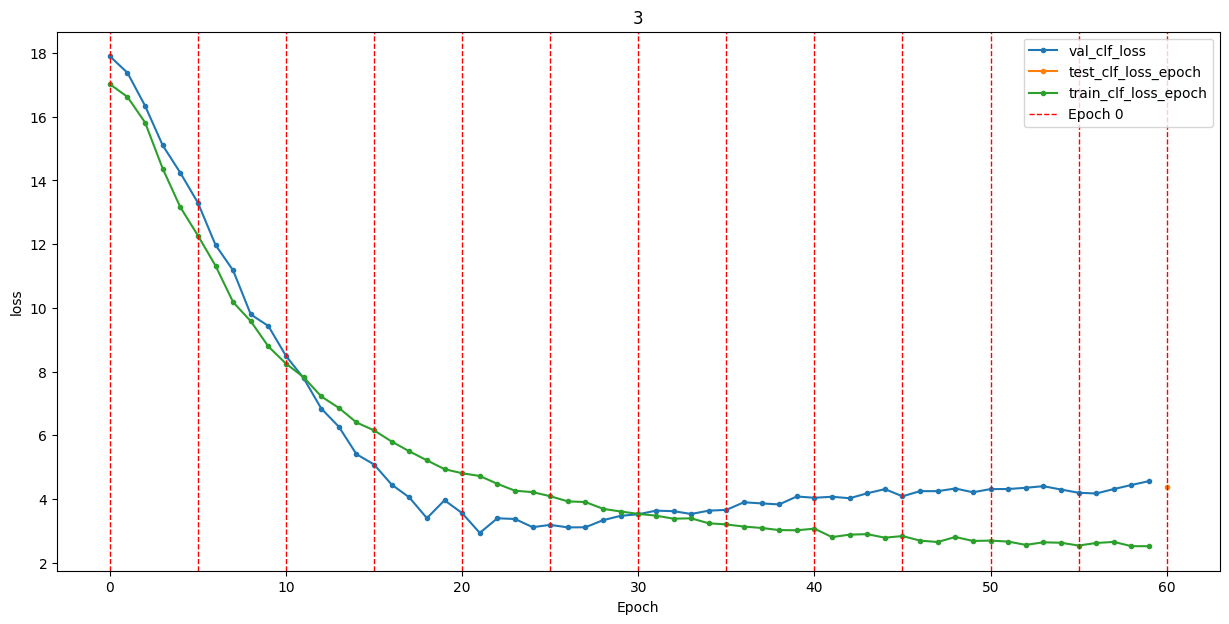

encoder and decoder structure: {'encoder': Sequential(
  (0): Sequential(
    (0): Linear(in_features=3737, out_features=3737, bias=True)
    (1): BatchNorm1d(3737, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
  )
  (1): Sequential(
    (0): Linear(in_features=3737, out_features=3737, bias=True)
    (1): BatchNorm1d(3737, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (2): Sequential(
    (0): Linear(in_features=3737, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (4): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(6

2025-03-09 11:28:10,752 INFO - lightning_fabric.utilities.seed - Global seed set to 1265 


detail information about structure save at： /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/3/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/model.pth
the 4/7 fold train, use donor-9 as test set
the 4/7 fold train, use donor-9 as test set
Set x_sc_train data with shape (gene, cells): torch.Size([3737, 499])
Set x_sc_test data with shape (gene, cells): torch.Size([3737, 76])
label dictionary: {-1: -5.0, 0: -4.836, 3: -4.344, 9: -3.361, 15: -2.377, 18: -1.885, 60: 5.0}
Normalize train y_time_nor_train type: embryoneg5to5, with y_time_nor_train lable: [-1.  0.  3.  9. 15. 18. 60.], shape: torch.Size([499]), 
detail: [-5.    -4.836 -4.344 -3.361 -2.377 -1.885  5.   ]
Normalize test y_time_nor_train type: embryoneg5to5, with y_time_nor_train lable: [9.], shape: torch.Size([76]), 
detail: [-3.361]
Start training with epoch: 60. 


2025-03-09 11:28:11,095 INFO - pytorch_lightning.utilities.rank_zero - GPU available: True (cuda), used: True 
2025-03-09 11:28:11,095 INFO - pytorch_lightning.utilities.rank_zero - TPU available: False, using: 0 TPU cores 
2025-03-09 11:28:11,096 INFO - pytorch_lightning.utilities.rank_zero - IPU available: False, using: 0 IPUs 
2025-03-09 11:28:11,096 INFO - pytorch_lightning.utilities.rank_zero - HPU available: False, using: 0 HPUs 
2025-03-09 11:28:11,100 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:28:11,132 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 
2025-03-09

don't set batch
Free Memory Percentage: 72.57%
[INFO] GPU device 2 - total: 40.0GB; - memory free: 38.819GB.
[INFO] GPU device 1 - total: 40.0GB; - memory free: 38.817GB.
[INFO] GPU device 0 - total: 40.0GB; - memory free: 38.819GB.

[INFO] more than 5% free memory, Auto select GPU device 0,- memory free: 38.819GB
Auto select run on cuda:0
======= Training SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial =======


Sanity Checking: 0it [00:00, ?it/s]

/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(92.2765, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.3944, device='cuda:0'), 'train_KLD_step': tensor(-5.9885, device='cuda:0'), 'train_clf_loss_step': tensor(18.1761, device='cuda:0'), 'val_loss': tensor(53.4119, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9464, device='cuda:0'), 'val_KLD': tensor(-0.3306, device='cuda:0'), 'val_clf_loss': tensor(10.4931, device='cuda:0'), 'train_loss_epoch': tensor(92.2765, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.3944, device='cuda:0'), 'train_KLD_epoch': tensor(-5.9885, device='cuda:0'), 'train_clf_loss_epoch': tensor(18.1761, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(90.1255, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.3923, device='cuda:0'), 'train_KLD_step': tensor(-6.5412, device='cuda:0'), 'train_clf_loss_step': tensor(17.7463, device='cuda:0'), 'val_loss': tensor(52.7880, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9713, device='cuda:0'), 'val_KLD': tensor(-3.8514, device='cuda:0'), 'val_clf_loss': tensor(10.3631, device='cuda:0'), 'train_loss_epoch': tensor(90.1255, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.3923, device='cuda:0'), 'train_KLD_epoch': tensor(-6.5412, device='cuda:0'), 'train_clf_loss_epoch': tensor(17.7463, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(84.5864, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.3214, device='cuda:0'), 'train_KLD_step': tensor(-7.8820, device='cuda:0'), 'train_clf_loss_step': tensor(16.6526, device='cuda:0'), 'val_loss': tensor(56.3275, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.1190, device='cuda:0'), 'val_KLD': tensor(-30.6345, device='cuda:0'), 'val_clf_loss': tensor(11.0402, device='cuda:0'), 'train_loss_epoch': tensor(84.5864, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.3214, device='cuda:0'), 'train_KLD_epoch': tensor(-7.8820, device='cuda:0'), 'train_clf_loss_epoch': tensor(16.6526, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(77.5101, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.2367, device='cuda:0'), 'train_KLD_step': tensor(-9.3956, device='cuda:0'), 'train_clf_loss_step': tensor(15.2542, device='cuda:0'), 'val_loss': tensor(62.5222, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.3491, device='cuda:0'), 'val_KLD': tensor(-61.0859, device='cuda:0'), 'val_clf_loss': tensor(12.2316, device='cuda:0'), 'train_loss_epoch': tensor(77.5101, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.2367, device='cuda:0'), 'train_KLD_epoch': tensor(-9.3956, device='cuda:0'), 'train_clf_loss_epoch': tensor(15.2542, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(70.8676, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.2019, device='cuda:0'), 'train_KLD_step': tensor(-11.2681, device='cuda:0'), 'train_clf_loss_step': tensor(13.9326, device='cuda:0'), 'val_loss': tensor(68.2075, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.4602, device='cuda:0'), 'val_KLD': tensor(-58.6176, device='cuda:0'), 'val_clf_loss': tensor(13.3465, device='cuda:0'), 'train_loss_epoch': tensor(70.8676, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.2019, device='cuda:0'), 'train_KLD_epoch': tensor(-11.2681, device='cuda:0'), 'train_clf_loss_epoch': tensor(13.9326, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(65.6229, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.1736, device='cuda:0'), 'train_KLD_step': tensor(-13.4916, device='cuda:0'), 'train_clf_loss_step': tensor(12.8892, device='cuda:0'), 'val_loss': tensor(72.3946, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.4950, device='cuda:0'), 'val_KLD': tensor(-71.6675, device='cuda:0'), 'val_clf_loss': tensor(14.1763, device='cuda:0'), 'train_loss_epoch': tensor(65.6229, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.1736, device='cuda:0'), 'train_KLD_epoch': tensor(-13.4916, device='cuda:0'), 'train_clf_loss_epoch': tensor(12.8892, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(60.5172, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.1644, device='cuda:0'), 'train_KLD_step': tensor(-15.8999, device='cuda:0'), 'train_clf_loss_step': tensor(11.8698, device='cuda:0'), 'val_loss': tensor(76.3378, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.4974, device='cuda:0'), 'val_KLD': tensor(-81.8823, device='cuda:0'), 'val_clf_loss': tensor(14.9640, device='cuda:0'), 'train_loss_epoch': tensor(60.5172, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.1644, device='cuda:0'), 'train_KLD_epoch': tensor(-15.8999, device='cuda:0'), 'train_clf_loss_epoch': tensor(11.8698, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(56.7118, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.1441, device='cuda:0'), 'train_KLD_step': tensor(-18.6711, device='cuda:0'), 'train_clf_loss_step': tensor(11.1126, device='cuda:0'), 'val_loss': tensor(81.5206, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.4499, device='cuda:0'), 'val_KLD': tensor(-76.8690, device='cuda:0'), 'val_clf_loss': tensor(16.0103, device='cuda:0'), 'train_loss_epoch': tensor(56.7118, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.1441, device='cuda:0'), 'train_KLD_epoch': tensor(-18.6711, device='cuda:0'), 'train_clf_loss_epoch': tensor(11.1126, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(52.9055, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.1421, device='cuda:0'), 'train_KLD_step': tensor(-21.5676, device='cuda:0'), 'train_clf_loss_step': tensor(10.3516, device='cuda:0'), 'val_loss': tensor(85.8883, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.4034, device='cuda:0'), 'val_KLD': tensor(-67.1448, device='cuda:0'), 'val_clf_loss': tensor(16.8936, device='cuda:0'), 'train_loss_epoch': tensor(52.9055, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.1421, device='cuda:0'), 'train_KLD_epoch': tensor(-21.5676, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.3516, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(49.2848, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.1252, device='cuda:0'), 'train_KLD_step': tensor(-24.4629, device='cuda:0'), 'train_clf_loss_step': tensor(9.6307, device='cuda:0'), 'val_loss': tensor(87.4021, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.3489, device='cuda:0'), 'val_KLD': tensor(-53.2010, device='cuda:0'), 'val_clf_loss': tensor(17.2080, device='cuda:0'), 'train_loss_epoch': tensor(49.2848, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.1252, device='cuda:0'), 'train_KLD_epoch': tensor(-24.4629, device='cuda:0'), 'train_clf_loss_epoch': tensor(9.6307, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(46.0058, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.1307, device='cuda:0'), 'train_KLD_step': tensor(-27.2431, device='cuda:0'), 'train_clf_loss_step': tensor(8.9737, device='cuda:0'), 'val_loss': tensor(90.0722, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.2949, device='cuda:0'), 'val_KLD': tensor(-37.2258, device='cuda:0'), 'val_clf_loss': tensor(17.7536, device='cuda:0'), 'train_loss_epoch': tensor(46.0058, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.1307, device='cuda:0'), 'train_KLD_epoch': tensor(-27.2431, device='cuda:0'), 'train_clf_loss_epoch': tensor(8.9737, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(43.3817, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.1362, device='cuda:0'), 'train_KLD_step': tensor(-29.7915, device='cuda:0'), 'train_clf_loss_step': tensor(8.4476, device='cuda:0'), 'val_loss': tensor(93.5785, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.1834, device='cuda:0'), 'val_KLD': tensor(-28.2681, device='cuda:0'), 'val_clf_loss': tensor(18.4776, device='cuda:0'), 'train_loss_epoch': tensor(43.3817, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.1362, device='cuda:0'), 'train_KLD_epoch': tensor(-29.7915, device='cuda:0'), 'train_clf_loss_epoch': tensor(8.4476, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(41.0848, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.1172, device='cuda:0'), 'train_KLD_step': tensor(-32.1778, device='cuda:0'), 'train_clf_loss_step': tensor(7.9919, device='cuda:0'), 'val_loss': tensor(92.9204, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.1489, device='cuda:0'), 'val_KLD': tensor(-23.1698, device='cuda:0'), 'val_clf_loss': tensor(18.3531, device='cuda:0'), 'train_loss_epoch': tensor(41.0848, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.1172, device='cuda:0'), 'train_KLD_epoch': tensor(-32.1778, device='cuda:0'), 'train_clf_loss_epoch': tensor(7.9919, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(38.4799, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.1202, device='cuda:0'), 'train_KLD_step': tensor(-34.3658, device='cuda:0'), 'train_clf_loss_step': tensor(7.4702, device='cuda:0'), 'val_loss': tensor(84.6963, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.1459, device='cuda:0'), 'val_KLD': tensor(-21.5288, device='cuda:0'), 'val_clf_loss': tensor(16.7090, device='cuda:0'), 'train_loss_epoch': tensor(38.4799, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.1202, device='cuda:0'), 'train_KLD_epoch': tensor(-34.3658, device='cuda:0'), 'train_clf_loss_epoch': tensor(7.4702, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(36.5878, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.1212, device='cuda:0'), 'train_KLD_step': tensor(-36.4631, device='cuda:0'), 'train_clf_loss_step': tensor(7.0915, device='cuda:0'), 'val_loss': tensor(79.5837, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.1485, device='cuda:0'), 'val_KLD': tensor(-20.7440, device='cuda:0'), 'val_clf_loss': tensor(15.6860, device='cuda:0'), 'train_loss_epoch': tensor(36.5878, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.1212, device='cuda:0'), 'train_KLD_epoch': tensor(-36.4631, device='cuda:0'), 'train_clf_loss_epoch': tensor(7.0915, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(35.2604, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.1087, device='cuda:0'), 'train_KLD_step': tensor(-38.3849, device='cuda:0'), 'train_clf_loss_step': tensor(6.8284, device='cuda:0'), 'val_loss': tensor(75.1877, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.1457, device='cuda:0'), 'val_KLD': tensor(-20.2867, device='cuda:0'), 'val_clf_loss': tensor(14.8074, device='cuda:0'), 'train_loss_epoch': tensor(35.2604, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.1087, device='cuda:0'), 'train_KLD_epoch': tensor(-38.3849, device='cuda:0'), 'train_clf_loss_epoch': tensor(6.8284, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(33.3784, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.1082, device='cuda:0'), 'train_KLD_step': tensor(-40.1503, device='cuda:0'), 'train_clf_loss_step': tensor(6.4520, device='cuda:0'), 'val_loss': tensor(62.8438, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.1184, device='cuda:0'), 'val_KLD': tensor(-18.2596, device='cuda:0'), 'val_clf_loss': tensor(12.3442, device='cuda:0'), 'train_loss_epoch': tensor(33.3784, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.1082, device='cuda:0'), 'train_KLD_epoch': tensor(-40.1503, device='cuda:0'), 'train_clf_loss_epoch': tensor(6.4520, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(31.7591, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.1041, device='cuda:0'), 'train_KLD_step': tensor(-41.7937, device='cuda:0'), 'train_clf_loss_step': tensor(6.1289, device='cuda:0'), 'val_loss': tensor(58.4885, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.0678, device='cuda:0'), 'val_KLD': tensor(-15.6398, device='cuda:0'), 'val_clf_loss': tensor(11.4834, device='cuda:0'), 'train_loss_epoch': tensor(31.7591, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.1041, device='cuda:0'), 'train_KLD_epoch': tensor(-41.7937, device='cuda:0'), 'train_clf_loss_epoch': tensor(6.1289, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(30.3432, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.1018, device='cuda:0'), 'train_KLD_step': tensor(-43.3743, device='cuda:0'), 'train_clf_loss_step': tensor(5.8461, device='cuda:0'), 'val_loss': tensor(48.2915, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.0717, device='cuda:0'), 'val_KLD': tensor(-11.7900, device='cuda:0'), 'val_clf_loss': tensor(9.4434, device='cuda:0'), 'train_loss_epoch': tensor(30.3432, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.1018, device='cuda:0'), 'train_KLD_epoch': tensor(-43.3743, device='cuda:0'), 'train_clf_loss_epoch': tensor(5.8461, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(28.9902, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0899, device='cuda:0'), 'train_KLD_step': tensor(-44.8371, device='cuda:0'), 'train_clf_loss_step': tensor(5.5778, device='cuda:0'), 'val_loss': tensor(50.4460, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.0805, device='cuda:0'), 'val_KLD': tensor(-9.1748, device='cuda:0'), 'val_clf_loss': tensor(9.8726, device='cuda:0'), 'train_loss_epoch': tensor(28.9902, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0899, device='cuda:0'), 'train_KLD_epoch': tensor(-44.8371, device='cuda:0'), 'train_clf_loss_epoch': tensor(5.5778, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(27.9263, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0955, device='cuda:0'), 'train_KLD_step': tensor(-46.1766, device='cuda:0'), 'train_clf_loss_step': tensor(5.3639, device='cuda:0'), 'val_loss': tensor(42.7430, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9992, device='cuda:0'), 'val_KLD': tensor(-7.9287, device='cuda:0'), 'val_clf_loss': tensor(8.3483, device='cuda:0'), 'train_loss_epoch': tensor(27.9263, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0955, device='cuda:0'), 'train_KLD_epoch': tensor(-46.1766, device='cuda:0'), 'train_clf_loss_epoch': tensor(5.3639, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(26.8870, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0860, device='cuda:0'), 'train_KLD_step': tensor(-47.4152, device='cuda:0'), 'train_clf_loss_step': tensor(5.1578, device='cuda:0'), 'val_loss': tensor(37.2906, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9861, device='cuda:0'), 'val_KLD': tensor(-7.9397, device='cuda:0'), 'val_clf_loss': tensor(7.2605, device='cuda:0'), 'train_loss_epoch': tensor(26.8870, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0860, device='cuda:0'), 'train_KLD_epoch': tensor(-47.4152, device='cuda:0'), 'train_clf_loss_epoch': tensor(5.1578, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(25.7887, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0874, device='cuda:0'), 'train_KLD_step': tensor(-48.5599, device='cuda:0'), 'train_clf_loss_step': tensor(4.9378, device='cuda:0'), 'val_loss': tensor(37.4826, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9995, device='cuda:0'), 'val_KLD': tensor(-8.2897, device='cuda:0'), 'val_clf_loss': tensor(7.2962, device='cuda:0'), 'train_loss_epoch': tensor(25.7887, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0874, device='cuda:0'), 'train_KLD_epoch': tensor(-48.5599, device='cuda:0'), 'train_clf_loss_epoch': tensor(4.9378, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(24.8888, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0792, device='cuda:0'), 'train_KLD_step': tensor(-49.6047, device='cuda:0'), 'train_clf_loss_step': tensor(4.7594, device='cuda:0'), 'val_loss': tensor(33.6722, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9997, device='cuda:0'), 'val_KLD': tensor(-8.9908, device='cuda:0'), 'val_clf_loss': tensor(6.5340, device='cuda:0'), 'train_loss_epoch': tensor(24.8888, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0792, device='cuda:0'), 'train_KLD_epoch': tensor(-49.6047, device='cuda:0'), 'train_clf_loss_epoch': tensor(4.7594, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(24.4925, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0844, device='cuda:0'), 'train_KLD_step': tensor(-50.5574, device='cuda:0'), 'train_clf_loss_step': tensor(4.6791, device='cuda:0'), 'val_loss': tensor(29.8779, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9667, device='cuda:0'), 'val_KLD': tensor(-9.2245, device='cuda:0'), 'val_clf_loss': tensor(5.7818, device='cuda:0'), 'train_loss_epoch': tensor(24.4925, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0844, device='cuda:0'), 'train_KLD_epoch': tensor(-50.5574, device='cuda:0'), 'train_clf_loss_epoch': tensor(4.6791, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(24.0031, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0784, device='cuda:0'), 'train_KLD_step': tensor(-51.4083, device='cuda:0'), 'train_clf_loss_step': tensor(4.5824, device='cuda:0'), 'val_loss': tensor(28.2604, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9690, device='cuda:0'), 'val_KLD': tensor(-9.0765, device='cuda:0'), 'val_clf_loss': tensor(5.4578, device='cuda:0'), 'train_loss_epoch': tensor(24.0031, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0784, device='cuda:0'), 'train_KLD_epoch': tensor(-51.4083, device='cuda:0'), 'train_clf_loss_epoch': tensor(4.5824, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(23.0216, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0664, device='cuda:0'), 'train_KLD_step': tensor(-52.1992, device='cuda:0'), 'train_clf_loss_step': tensor(4.3884, device='cuda:0'), 'val_loss': tensor(26.8905, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9804, device='cuda:0'), 'val_KLD': tensor(-9.0612, device='cuda:0'), 'val_clf_loss': tensor(5.1816, device='cuda:0'), 'train_loss_epoch': tensor(23.0216, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0664, device='cuda:0'), 'train_KLD_epoch': tensor(-52.1992, device='cuda:0'), 'train_clf_loss_epoch': tensor(4.3884, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(22.2400, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0601, device='cuda:0'), 'train_KLD_step': tensor(-52.9354, device='cuda:0'), 'train_clf_loss_step': tensor(4.2333, device='cuda:0'), 'val_loss': tensor(26.8470, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9625, device='cuda:0'), 'val_KLD': tensor(-8.8424, device='cuda:0'), 'val_clf_loss': tensor(5.1764, device='cuda:0'), 'train_loss_epoch': tensor(22.2400, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0601, device='cuda:0'), 'train_KLD_epoch': tensor(-52.9354, device='cuda:0'), 'train_clf_loss_epoch': tensor(4.2333, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(21.4612, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0645, device='cuda:0'), 'train_KLD_step': tensor(-53.6036, device='cuda:0'), 'train_clf_loss_step': tensor(4.0767, device='cuda:0'), 'val_loss': tensor(26.4453, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9899, device='cuda:0'), 'val_KLD': tensor(-8.7059, device='cuda:0'), 'val_clf_loss': tensor(5.0906, device='cuda:0'), 'train_loss_epoch': tensor(21.4612, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0645, device='cuda:0'), 'train_KLD_epoch': tensor(-53.6036, device='cuda:0'), 'train_clf_loss_epoch': tensor(4.0767, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.9550, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0580, device='cuda:0'), 'train_KLD_step': tensor(-54.2072, device='cuda:0'), 'train_clf_loss_step': tensor(3.9767, device='cuda:0'), 'val_loss': tensor(25.0732, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9481, device='cuda:0'), 'val_KLD': tensor(-8.5209, device='cuda:0'), 'val_clf_loss': tensor(4.8246, device='cuda:0'), 'train_loss_epoch': tensor(20.9550, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0580, device='cuda:0'), 'train_KLD_epoch': tensor(-54.2072, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.9767, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(21.0511, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0606, device='cuda:0'), 'train_KLD_step': tensor(-54.7693, device='cuda:0'), 'train_clf_loss_step': tensor(3.9954, device='cuda:0'), 'val_loss': tensor(24.1487, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9559, device='cuda:0'), 'val_KLD': tensor(-8.2938, device='cuda:0'), 'val_clf_loss': tensor(4.6381, device='cuda:0'), 'train_loss_epoch': tensor(21.0511, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0606, device='cuda:0'), 'train_KLD_epoch': tensor(-54.7693, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.9954, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.7321, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0496, device='cuda:0'), 'train_KLD_step': tensor(-55.2820, device='cuda:0'), 'train_clf_loss_step': tensor(3.9337, device='cuda:0'), 'val_loss': tensor(24.6681, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9608, device='cuda:0'), 'val_KLD': tensor(-8.2388, device='cuda:0'), 'val_clf_loss': tensor(4.7410, device='cuda:0'), 'train_loss_epoch': tensor(20.7321, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0496, device='cuda:0'), 'train_KLD_epoch': tensor(-55.2820, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.9337, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.2835, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0425, device='cuda:0'), 'train_KLD_step': tensor(-55.7757, device='cuda:0'), 'train_clf_loss_step': tensor(3.8454, device='cuda:0'), 'val_loss': tensor(24.1166, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9787, device='cuda:0'), 'val_KLD': tensor(-8.2126, device='cuda:0'), 'val_clf_loss': tensor(4.6272, device='cuda:0'), 'train_loss_epoch': tensor(20.2835, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0425, device='cuda:0'), 'train_KLD_epoch': tensor(-55.7757, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.8454, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.0520, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0497, device='cuda:0'), 'train_KLD_step': tensor(-56.1901, device='cuda:0'), 'train_clf_loss_step': tensor(3.7977, device='cuda:0'), 'val_loss': tensor(22.1745, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9570, device='cuda:0'), 'val_KLD': tensor(-8.1844, device='cuda:0'), 'val_clf_loss': tensor(4.2431, device='cuda:0'), 'train_loss_epoch': tensor(20.0520, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0497, device='cuda:0'), 'train_KLD_epoch': tensor(-56.1901, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.7977, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(18.9504, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0422, device='cuda:0'), 'train_KLD_step': tensor(-56.5503, device='cuda:0'), 'train_clf_loss_step': tensor(3.5788, device='cuda:0'), 'val_loss': tensor(22.7068, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9432, device='cuda:0'), 'val_KLD': tensor(-8.2458, device='cuda:0'), 'val_clf_loss': tensor(4.3523, device='cuda:0'), 'train_loss_epoch': tensor(18.9504, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0422, device='cuda:0'), 'train_KLD_epoch': tensor(-56.5503, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.5788, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(18.9308, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0554, device='cuda:0'), 'train_KLD_step': tensor(-56.8831, device='cuda:0'), 'train_clf_loss_step': tensor(3.5722, device='cuda:0'), 'val_loss': tensor(21.4617, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9501, device='cuda:0'), 'val_KLD': tensor(-8.3389, device='cuda:0'), 'val_clf_loss': tensor(4.1019, device='cuda:0'), 'train_loss_epoch': tensor(18.9308, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0554, device='cuda:0'), 'train_KLD_epoch': tensor(-56.8831, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.5722, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(18.9102, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0429, device='cuda:0'), 'train_KLD_step': tensor(-57.1947, device='cuda:0'), 'train_clf_loss_step': tensor(3.5706, device='cuda:0'), 'val_loss': tensor(22.3238, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9425, device='cuda:0'), 'val_KLD': tensor(-8.4122, device='cuda:0'), 'val_clf_loss': tensor(4.2758, device='cuda:0'), 'train_loss_epoch': tensor(18.9102, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0429, device='cuda:0'), 'train_KLD_epoch': tensor(-57.1947, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.5706, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(18.4352, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0410, device='cuda:0'), 'train_KLD_step': tensor(-57.4789, device='cuda:0'), 'train_clf_loss_step': tensor(3.4760, device='cuda:0'), 'val_loss': tensor(21.5984, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9518, device='cuda:0'), 'val_KLD': tensor(-8.4906, device='cuda:0'), 'val_clf_loss': tensor(4.1289, device='cuda:0'), 'train_loss_epoch': tensor(18.4352, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0410, device='cuda:0'), 'train_KLD_epoch': tensor(-57.4789, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.4760, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(17.8019, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0403, device='cuda:0'), 'train_KLD_step': tensor(-57.7406, device='cuda:0'), 'train_clf_loss_step': tensor(3.3494, device='cuda:0'), 'val_loss': tensor(20.6041, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9405, device='cuda:0'), 'val_KLD': tensor(-8.5297, device='cuda:0'), 'val_clf_loss': tensor(3.9323, device='cuda:0'), 'train_loss_epoch': tensor(17.8019, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0403, device='cuda:0'), 'train_KLD_epoch': tensor(-57.7406, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.3494, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(17.7734, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0371, device='cuda:0'), 'train_KLD_step': tensor(-57.9805, device='cuda:0'), 'train_clf_loss_step': tensor(3.3444, device='cuda:0'), 'val_loss': tensor(21.4497, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9502, device='cuda:0'), 'val_KLD': tensor(-8.5861, device='cuda:0'), 'val_clf_loss': tensor(4.0995, device='cuda:0'), 'train_loss_epoch': tensor(17.7734, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0371, device='cuda:0'), 'train_KLD_epoch': tensor(-57.9805, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.3444, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(17.9695, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0343, device='cuda:0'), 'train_KLD_step': tensor(-58.2022, device='cuda:0'), 'train_clf_loss_step': tensor(3.3841, device='cuda:0'), 'val_loss': tensor(21.5603, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9370, device='cuda:0'), 'val_KLD': tensor(-8.6341, device='cuda:0'), 'val_clf_loss': tensor(4.1242, device='cuda:0'), 'train_loss_epoch': tensor(17.9695, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0343, device='cuda:0'), 'train_KLD_epoch': tensor(-58.2022, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.3841, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(17.1406, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0287, device='cuda:0'), 'train_KLD_step': tensor(-58.4182, device='cuda:0'), 'train_clf_loss_step': tensor(3.2195, device='cuda:0'), 'val_loss': tensor(20.8116, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9418, device='cuda:0'), 'val_KLD': tensor(-8.7485, device='cuda:0'), 'val_clf_loss': tensor(3.9735, device='cuda:0'), 'train_loss_epoch': tensor(17.1406, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0287, device='cuda:0'), 'train_KLD_epoch': tensor(-58.4182, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.2195, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(17.5133, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0288, device='cuda:0'), 'train_KLD_step': tensor(-58.6306, device='cuda:0'), 'train_clf_loss_step': tensor(3.2940, device='cuda:0'), 'val_loss': tensor(20.2757, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9473, device='cuda:0'), 'val_KLD': tensor(-8.8439, device='cuda:0'), 'val_clf_loss': tensor(3.8652, device='cuda:0'), 'train_loss_epoch': tensor(17.5133, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0288, device='cuda:0'), 'train_KLD_epoch': tensor(-58.6306, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.2940, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(17.3706, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0287, device='cuda:0'), 'train_KLD_step': tensor(-58.8319, device='cuda:0'), 'train_clf_loss_step': tensor(3.2654, device='cuda:0'), 'val_loss': tensor(21.2620, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9458, device='cuda:0'), 'val_KLD': tensor(-8.9509, device='cuda:0'), 'val_clf_loss': tensor(4.0628, device='cuda:0'), 'train_loss_epoch': tensor(17.3706, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0287, device='cuda:0'), 'train_KLD_epoch': tensor(-58.8319, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.2654, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.8139, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0305, device='cuda:0'), 'train_KLD_step': tensor(-59.0241, device='cuda:0'), 'train_clf_loss_step': tensor(3.1537, device='cuda:0'), 'val_loss': tensor(21.8284, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9389, device='cuda:0'), 'val_KLD': tensor(-9.0260, device='cuda:0'), 'val_clf_loss': tensor(4.1774, device='cuda:0'), 'train_loss_epoch': tensor(16.8139, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0305, device='cuda:0'), 'train_KLD_epoch': tensor(-59.0241, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.1537, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.6109, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0225, device='cuda:0'), 'train_KLD_step': tensor(-59.1884, device='cuda:0'), 'train_clf_loss_step': tensor(3.1147, device='cuda:0'), 'val_loss': tensor(18.8404, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9383, device='cuda:0'), 'val_KLD': tensor(-9.0622, device='cuda:0'), 'val_clf_loss': tensor(3.5800, device='cuda:0'), 'train_loss_epoch': tensor(16.6109, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0225, device='cuda:0'), 'train_KLD_epoch': tensor(-59.1884, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.1147, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.7798, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0271, device='cuda:0'), 'train_KLD_step': tensor(-59.3371, device='cuda:0'), 'train_clf_loss_step': tensor(3.1476, device='cuda:0'), 'val_loss': tensor(20.5799, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9256, device='cuda:0'), 'val_KLD': tensor(-9.0851, device='cuda:0'), 'val_clf_loss': tensor(3.9304, device='cuda:0'), 'train_loss_epoch': tensor(16.7798, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0271, device='cuda:0'), 'train_KLD_epoch': tensor(-59.3371, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.1476, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.1168, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0120, device='cuda:0'), 'train_KLD_step': tensor(-59.4530, device='cuda:0'), 'train_clf_loss_step': tensor(3.0180, device='cuda:0'), 'val_loss': tensor(20.3867, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9462, device='cuda:0'), 'val_KLD': tensor(-9.0659, device='cuda:0'), 'val_clf_loss': tensor(3.8876, device='cuda:0'), 'train_loss_epoch': tensor(16.1168, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0120, device='cuda:0'), 'train_KLD_epoch': tensor(-59.4530, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.0180, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.5014, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0247, device='cuda:0'), 'train_KLD_step': tensor(-59.5559, device='cuda:0'), 'train_clf_loss_step': tensor(3.0924, device='cuda:0'), 'val_loss': tensor(20.3909, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9345, device='cuda:0'), 'val_KLD': tensor(-9.0660, device='cuda:0'), 'val_clf_loss': tensor(3.8908, device='cuda:0'), 'train_loss_epoch': tensor(16.5014, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0247, device='cuda:0'), 'train_KLD_epoch': tensor(-59.5559, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.0924, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.3240, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0176, device='cuda:0'), 'train_KLD_step': tensor(-59.6697, device='cuda:0'), 'train_clf_loss_step': tensor(3.0583, device='cuda:0'), 'val_loss': tensor(20.0739, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9353, device='cuda:0'), 'val_KLD': tensor(-9.0397, device='cuda:0'), 'val_clf_loss': tensor(3.8273, device='cuda:0'), 'train_loss_epoch': tensor(16.3240, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0176, device='cuda:0'), 'train_KLD_epoch': tensor(-59.6697, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.0583, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.1234, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0144, device='cuda:0'), 'train_KLD_step': tensor(-59.7771, device='cuda:0'), 'train_clf_loss_step': tensor(3.0188, device='cuda:0'), 'val_loss': tensor(20.6560, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9441, device='cuda:0'), 'val_KLD': tensor(-9.0334, device='cuda:0'), 'val_clf_loss': tensor(3.9419, device='cuda:0'), 'train_loss_epoch': tensor(16.1234, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0144, device='cuda:0'), 'train_KLD_epoch': tensor(-59.7771, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.0188, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.0660, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0173, device='cuda:0'), 'train_KLD_step': tensor(-59.8751, device='cuda:0'), 'train_clf_loss_step': tensor(3.0068, device='cuda:0'), 'val_loss': tensor(20.1001, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9402, device='cuda:0'), 'val_KLD': tensor(-9.0563, device='cuda:0'), 'val_clf_loss': tensor(3.8315, device='cuda:0'), 'train_loss_epoch': tensor(16.0660, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0173, device='cuda:0'), 'train_KLD_epoch': tensor(-59.8751, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.0068, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(15.6698, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0134, device='cuda:0'), 'train_KLD_step': tensor(-59.9743, device='cuda:0'), 'train_clf_loss_step': tensor(2.9283, device='cuda:0'), 'val_loss': tensor(20.8104, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9325, device='cuda:0'), 'val_KLD': tensor(-9.0753, device='cuda:0'), 'val_clf_loss': tensor(3.9751, device='cuda:0'), 'train_loss_epoch': tensor(15.6698, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0134, device='cuda:0'), 'train_KLD_epoch': tensor(-59.9743, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.9283, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(15.4944, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0127, device='cuda:0'), 'train_KLD_step': tensor(-60.0737, device='cuda:0'), 'train_clf_loss_step': tensor(2.8933, device='cuda:0'), 'val_loss': tensor(21.0763, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9508, device='cuda:0'), 'val_KLD': tensor(-9.0839, device='cuda:0'), 'val_clf_loss': tensor(4.0247, device='cuda:0'), 'train_loss_epoch': tensor(15.4944, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0127, device='cuda:0'), 'train_KLD_epoch': tensor(-60.0737, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.8933, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(15.5667, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0044, device='cuda:0'), 'train_KLD_step': tensor(-60.1860, device='cuda:0'), 'train_clf_loss_step': tensor(2.9094, device='cuda:0'), 'val_loss': tensor(20.3069, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9378, device='cuda:0'), 'val_KLD': tensor(-9.0726, device='cuda:0'), 'val_clf_loss': tensor(3.8734, device='cuda:0'), 'train_loss_epoch': tensor(15.5667, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0044, device='cuda:0'), 'train_KLD_epoch': tensor(-60.1860, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.9094, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(15.1478, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0071, device='cuda:0'), 'train_KLD_step': tensor(-60.2999, device='cuda:0'), 'train_clf_loss_step': tensor(2.8251, device='cuda:0'), 'val_loss': tensor(19.7349, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9246, device='cuda:0'), 'val_KLD': tensor(-9.0635, device='cuda:0'), 'val_clf_loss': tensor(3.7616, device='cuda:0'), 'train_loss_epoch': tensor(15.1478, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0071, device='cuda:0'), 'train_KLD_epoch': tensor(-60.2999, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.8251, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(15.4829, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0208, device='cuda:0'), 'train_KLD_step': tensor(-60.3941, device='cuda:0'), 'train_clf_loss_step': tensor(2.8894, device='cuda:0'), 'val_loss': tensor(19.7422, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9333, device='cuda:0'), 'val_KLD': tensor(-9.0583, device='cuda:0'), 'val_clf_loss': tensor(3.7613, device='cuda:0'), 'train_loss_epoch': tensor(15.4829, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0208, device='cuda:0'), 'train_KLD_epoch': tensor(-60.3941, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.8894, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(16.1486, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0116, device='cuda:0'), 'train_KLD_step': tensor(-60.4737, device='cuda:0'), 'train_clf_loss_step': tensor(3.0244, device='cuda:0'), 'val_loss': tensor(19.9579, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9498, device='cuda:0'), 'val_KLD': tensor(-9.0533, device='cuda:0'), 'val_clf_loss': tensor(3.8012, device='cuda:0'), 'train_loss_epoch': tensor(16.1486, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0116, device='cuda:0'), 'train_KLD_epoch': tensor(-60.4737, device='cuda:0'), 'train_clf_loss_epoch': tensor(3.0244, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(15.3248, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0137, device='cuda:0'), 'train_KLD_step': tensor(-60.5423, device='cuda:0'), 'train_clf_loss_step': tensor(2.8592, device='cuda:0'), 'val_loss': tensor(20.5102, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9616, device='cuda:0'), 'val_KLD': tensor(-9.0284, device='cuda:0'), 'val_clf_loss': tensor(3.9093, device='cuda:0'), 'train_loss_epoch': tensor(15.3248, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0137, device='cuda:0'), 'train_KLD_epoch': tensor(-60.5423, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.8592, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(15.2292, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0129, device='cuda:0'), 'train_KLD_step': tensor(-60.6050, device='cuda:0'), 'train_clf_loss_step': tensor(2.8402, device='cuda:0'), 'val_loss': tensor(21.0026, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9284, device='cuda:0'), 'val_KLD': tensor(-8.9904, device='cuda:0'), 'val_clf_loss': tensor(4.0144, device='cuda:0'), 'train_loss_epoch': tensor(15.2292, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0129, device='cuda:0'), 'train_KLD_epoch': tensor(-60.6050, device='cuda:0'), 'train_clf_loss_epoch': tensor(2.8402, device='cuda:0')}


2025-03-09 11:31:14,089 INFO - pytorch_lightning.utilities.rank_zero - `Trainer.fit` stopped: `max_epochs=60` reached. 
2025-03-09 11:31:14,386 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:31:14,453 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 
/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on 

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_KLD_epoch         │       -8.990416526794434       │
│ test_Reconstruction_loss_epoch │       0.9382125735282898       │
│      test_clf_loss_epoch       │       3.9619274139404297       │
│        test_loss_epoch         │       20.750097274780273       │
└────────────────────────────────┴────────────────────────────────┘

2025-03-09 11:31:14,834 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:31:14,880 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 


this epoch final, on test data:[{'test_loss_epoch': 20.750097274780273, 'test_Reconstruction_loss_epoch': 0.9382125735282898, 'test_KLD_epoch': -8.990416526794434, 'test_clf_loss_epoch': 3.9619274139404297}]


/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

2025-03-09 11:31:15,256 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:31:15,307 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 


Predicting: 0it [00:00, ?it/s]

2025-03-09 11:31:15,689 INFO - tensorboard - Directory watcher advancing from /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/9/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1741537691.GPU2.1181448.7 to /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/9/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1741537874.GPU2.1181448.8 
2025-03-09 11:31:15,691 INFO - tensorboard - No path found after /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/9/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1741537874.GPU2.1181448.8 
2025-03-09 11:31:15,692 INFO - TemporalVAE.utils.utils_Dandan_plot - plot training process. 
2025-03-09 11:31:15,704 INFO - tensorboard - 

The Array does not contain NaN values
predicted time of test donor is continuous.
Plot training loss line for check.
All tags in logger: ['lr-Adam', 'train_loss_step', 'train_Reconstruction_loss_step', 'train_KLD_step', 'train_clf_loss_step', 'epoch', 'val_loss', 'val_Reconstruction_loss', 'val_KLD', 'val_clf_loss', 'train_loss_epoch', 'train_Reconstruction_loss_epoch', 'train_KLD_epoch', 'train_clf_loss_epoch', 'test_loss_step', 'test_Reconstruction_loss_step', 'test_KLD_step', 'test_clf_loss_step', 'test_loss_epoch', 'test_Reconstruction_loss_epoch', 'test_KLD_epoch', 'test_clf_loss_epoch']
plot tags ['val_clf_loss', 'test_clf_loss_epoch', 'train_clf_loss_epoch']


2025-03-09 11:31:15,910 INFO - TemporalVAE.utils.utils_Dandan_plot - Finish save images at: /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/9/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/trainingLoss_val_clf_loss_test_clf_loss_epoch_train_clf_loss_epoch_9.png 


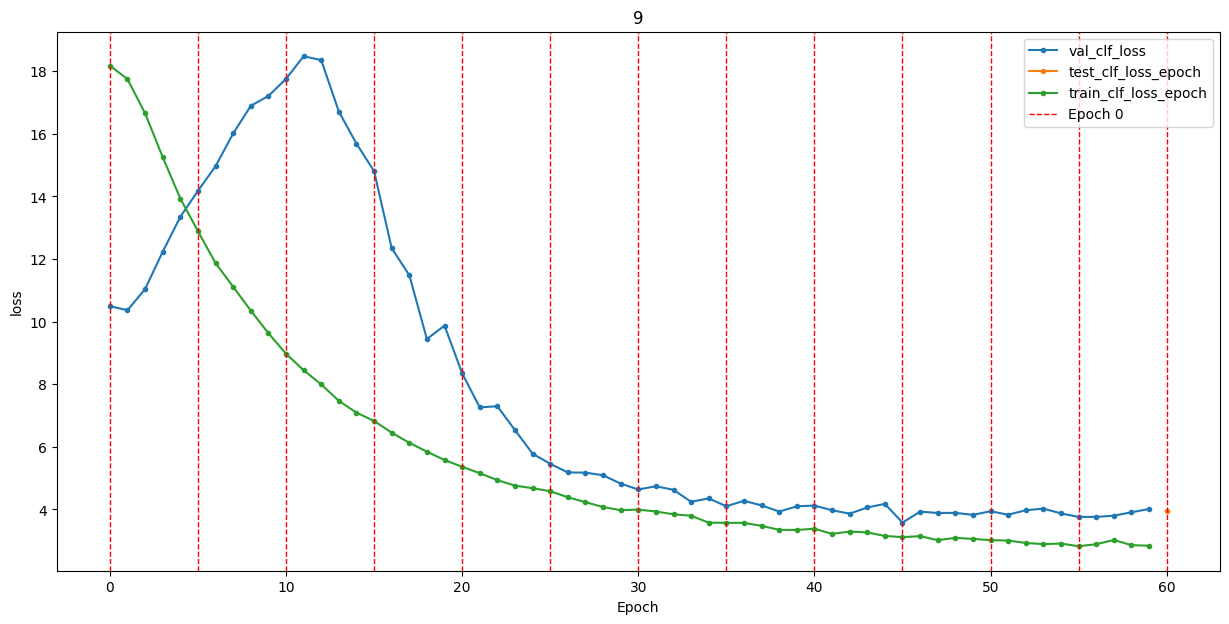

encoder and decoder structure: {'encoder': Sequential(
  (0): Sequential(
    (0): Linear(in_features=3737, out_features=3737, bias=True)
    (1): BatchNorm1d(3737, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
  )
  (1): Sequential(
    (0): Linear(in_features=3737, out_features=3737, bias=True)
    (1): BatchNorm1d(3737, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (2): Sequential(
    (0): Linear(in_features=3737, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (4): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(6

2025-03-09 11:31:16,540 INFO - lightning_fabric.utilities.seed - Global seed set to 1265 


the 5/7 fold train, use donor-15 as test set
the 5/7 fold train, use donor-15 as test set
Set x_sc_train data with shape (gene, cells): torch.Size([3737, 521])
Set x_sc_test data with shape (gene, cells): torch.Size([3737, 54])
label dictionary: {-1: -5.0, 0: -4.836, 3: -4.344, 9: -3.361, 15: -2.377, 18: -1.885, 60: 5.0}
Normalize train y_time_nor_train type: embryoneg5to5, with y_time_nor_train lable: [-1.  0.  3.  9. 15. 18. 60.], shape: torch.Size([521]), 
detail: [-5.    -4.836 -4.344 -3.361 -2.377 -1.885  5.   ]
Normalize test y_time_nor_train type: embryoneg5to5, with y_time_nor_train lable: [15.], shape: torch.Size([54]), 
detail: [-2.377]
Start training with epoch: 60. 


2025-03-09 11:31:16,880 INFO - pytorch_lightning.utilities.rank_zero - GPU available: True (cuda), used: True 
2025-03-09 11:31:16,880 INFO - pytorch_lightning.utilities.rank_zero - TPU available: False, using: 0 TPU cores 
2025-03-09 11:31:16,881 INFO - pytorch_lightning.utilities.rank_zero - IPU available: False, using: 0 IPUs 
2025-03-09 11:31:16,881 INFO - pytorch_lightning.utilities.rank_zero - HPU available: False, using: 0 HPUs 
2025-03-09 11:31:16,885 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:31:16,920 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 
2025-03-09

don't set batch
Free Memory Percentage: 72.46%
[INFO] GPU device 2 - total: 40.0GB; - memory free: 38.819GB.
[INFO] GPU device 1 - total: 40.0GB; - memory free: 38.817GB.
[INFO] GPU device 0 - total: 40.0GB; - memory free: 38.817GB.

[INFO] more than 5% free memory, Auto select GPU device 2,- memory free: 38.819GB
Auto select run on cuda:2
======= Training SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial =======


Sanity Checking: 0it [00:00, ?it/s]

/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(94.4597, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.4084, device='cuda:2'), 'train_KLD_step': tensor(-6.0045, device='cuda:2'), 'train_clf_loss_step': tensor(18.6100, device='cuda:2'), 'val_loss': tensor(26.2092, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7980, device='cuda:2'), 'val_KLD': tensor(-0.2599, device='cuda:2'), 'val_clf_loss': tensor(5.0822, device='cuda:2'), 'train_loss_epoch': tensor(94.4597, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.4084, device='cuda:2'), 'train_KLD_epoch': tensor(-6.0045, device='cuda:2'), 'train_clf_loss_epoch': tensor(18.6100, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(93.0104, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.3974, device='cuda:2'), 'train_KLD_step': tensor(-6.5112, device='cuda:2'), 'train_clf_loss_step': tensor(18.3223, device='cuda:2'), 'val_loss': tensor(26.6618, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.8571, device='cuda:2'), 'val_KLD': tensor(-8.4247, device='cuda:2'), 'val_clf_loss': tensor(5.1605, device='cuda:2'), 'train_loss_epoch': tensor(93.0104, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.3974, device='cuda:2'), 'train_KLD_epoch': tensor(-6.5112, device='cuda:2'), 'train_clf_loss_epoch': tensor(18.3223, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(87.8616, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.3304, device='cuda:2'), 'train_KLD_step': tensor(-7.7559, device='cuda:2'), 'train_clf_loss_step': tensor(17.3059, device='cuda:2'), 'val_loss': tensor(31.0611, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.2315, device='cuda:2'), 'val_KLD': tensor(-50.6754, device='cuda:2'), 'val_clf_loss': tensor(5.9634, device='cuda:2'), 'train_loss_epoch': tensor(87.8616, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.3304, device='cuda:2'), 'train_KLD_epoch': tensor(-7.7559, device='cuda:2'), 'train_clf_loss_epoch': tensor(17.3059, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(82.8577, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.2452, device='cuda:2'), 'train_KLD_step': tensor(-9.5137, device='cuda:2'), 'train_clf_loss_step': tensor(16.3220, device='cuda:2'), 'val_loss': tensor(38.7786, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4802, device='cuda:2'), 'val_KLD': tensor(-90.5371, device='cuda:2'), 'val_clf_loss': tensor(7.4551, device='cuda:2'), 'train_loss_epoch': tensor(82.8577, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.2452, device='cuda:2'), 'train_KLD_epoch': tensor(-9.5137, device='cuda:2'), 'train_clf_loss_epoch': tensor(16.3220, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(78.3961, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.1953, device='cuda:2'), 'train_KLD_step': tensor(-10.8296, device='cuda:2'), 'train_clf_loss_step': tensor(15.4396, device='cuda:2'), 'val_loss': tensor(48.1467, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.5243, device='cuda:2'), 'val_KLD': tensor(-184.6609, device='cuda:2'), 'val_clf_loss': tensor(9.3152, device='cuda:2'), 'train_loss_epoch': tensor(78.3961, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.1953, device='cuda:2'), 'train_KLD_epoch': tensor(-10.8296, device='cuda:2'), 'train_clf_loss_epoch': tensor(15.4396, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(73.0376, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.1815, device='cuda:2'), 'train_KLD_step': tensor(-12.4112, device='cuda:2'), 'train_clf_loss_step': tensor(14.3706, device='cuda:2'), 'val_loss': tensor(54.3567, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.5300, device='cuda:2'), 'val_KLD': tensor(-250.3897, device='cuda:2'), 'val_clf_loss': tensor(10.5528, device='cuda:2'), 'train_loss_epoch': tensor(73.0376, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.1815, device='cuda:2'), 'train_KLD_epoch': tensor(-12.4112, device='cuda:2'), 'train_clf_loss_epoch': tensor(14.3706, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(67.4138, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.1800, device='cuda:2'), 'train_KLD_step': tensor(-14.2417, device='cuda:2'), 'train_clf_loss_step': tensor(13.2461, device='cuda:2'), 'val_loss': tensor(60.1699, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.5260, device='cuda:2'), 'val_KLD': tensor(-237.2507, device='cuda:2'), 'val_clf_loss': tensor(11.7169, device='cuda:2'), 'train_loss_epoch': tensor(67.4138, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.1800, device='cuda:2'), 'train_KLD_epoch': tensor(-14.2417, device='cuda:2'), 'train_clf_loss_epoch': tensor(13.2461, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(63.0989, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.1797, device='cuda:2'), 'train_KLD_step': tensor(-16.1564, device='cuda:2'), 'train_clf_loss_step': tensor(12.3830, device='cuda:2'), 'val_loss': tensor(68.3612, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.5225, device='cuda:2'), 'val_KLD': tensor(-219.9107, device='cuda:2'), 'val_clf_loss': tensor(13.3567, device='cuda:2'), 'train_loss_epoch': tensor(63.0989, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.1797, device='cuda:2'), 'train_KLD_epoch': tensor(-16.1564, device='cuda:2'), 'train_clf_loss_epoch': tensor(12.3830, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(58.9942, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.1720, device='cuda:2'), 'train_KLD_step': tensor(-18.3078, device='cuda:2'), 'train_clf_loss_step': tensor(11.5635, device='cuda:2'), 'val_loss': tensor(77.3846, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.5145, device='cuda:2'), 'val_KLD': tensor(-209.9855, device='cuda:2'), 'val_clf_loss': tensor(15.1635, device='cuda:2'), 'train_loss_epoch': tensor(58.9942, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.1720, device='cuda:2'), 'train_KLD_epoch': tensor(-18.3078, device='cuda:2'), 'train_clf_loss_epoch': tensor(11.5635, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(55.0616, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.1639, device='cuda:2'), 'train_KLD_step': tensor(-20.6984, device='cuda:2'), 'train_clf_loss_step': tensor(10.7785, device='cuda:2'), 'val_loss': tensor(83.3761, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4827, device='cuda:2'), 'val_KLD': tensor(-212.9785, device='cuda:2'), 'val_clf_loss': tensor(16.3680, device='cuda:2'), 'train_loss_epoch': tensor(55.0616, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.1639, device='cuda:2'), 'train_KLD_epoch': tensor(-20.6984, device='cuda:2'), 'train_clf_loss_epoch': tensor(10.7785, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(51.9739, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.1565, device='cuda:2'), 'train_KLD_step': tensor(-23.2161, device='cuda:2'), 'train_clf_loss_step': tensor(10.1623, device='cuda:2'), 'val_loss': tensor(90.0485, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.4926, device='cuda:2'), 'val_KLD': tensor(-207.6703, device='cuda:2'), 'val_clf_loss': tensor(17.7008, device='cuda:2'), 'train_loss_epoch': tensor(51.9739, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.1565, device='cuda:2'), 'train_KLD_epoch': tensor(-23.2161, device='cuda:2'), 'train_clf_loss_epoch': tensor(10.1623, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(48.7483, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.1395, device='cuda:2'), 'train_KLD_step': tensor(-25.7824, device='cuda:2'), 'train_clf_loss_step': tensor(9.5205, device='cuda:2'), 'val_loss': tensor(96.8498, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.5257, device='cuda:2'), 'val_KLD': tensor(-186.0329, device='cuda:2'), 'val_clf_loss': tensor(19.0555, device='cuda:2'), 'train_loss_epoch': tensor(48.7483, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.1395, device='cuda:2'), 'train_KLD_epoch': tensor(-25.7824, device='cuda:2'), 'train_clf_loss_epoch': tensor(9.5205, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(47.0184, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.1403, device='cuda:2'), 'train_KLD_step': tensor(-28.2538, device='cuda:2'), 'train_clf_loss_step': tensor(9.1742, device='cuda:2'), 'val_loss': tensor(103.7542, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.3793, device='cuda:2'), 'val_KLD': tensor(-151.3416, device='cuda:2'), 'val_clf_loss': tensor(20.4674, device='cuda:2'), 'train_loss_epoch': tensor(47.0184, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.1403, device='cuda:2'), 'train_KLD_epoch': tensor(-28.2538, device='cuda:2'), 'train_clf_loss_epoch': tensor(9.1742, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(44.5269, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.1264, device='cuda:2'), 'train_KLD_step': tensor(-30.5922, device='cuda:2'), 'train_clf_loss_step': tensor(8.6786, device='cuda:2'), 'val_loss': tensor(108.8405, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.2663, device='cuda:2'), 'val_KLD': tensor(-120.9275, device='cuda:2'), 'val_clf_loss': tensor(21.5088, device='cuda:2'), 'train_loss_epoch': tensor(44.5269, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.1264, device='cuda:2'), 'train_KLD_epoch': tensor(-30.5922, device='cuda:2'), 'train_clf_loss_epoch': tensor(8.6786, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(42.1426, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.1247, device='cuda:2'), 'train_KLD_step': tensor(-32.7574, device='cuda:2'), 'train_clf_loss_step': tensor(8.2019, device='cuda:2'), 'val_loss': tensor(112.0896, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.1874, device='cuda:2'), 'val_KLD': tensor(-97.1905, device='cuda:2'), 'val_clf_loss': tensor(22.1756, device='cuda:2'), 'train_loss_epoch': tensor(42.1426, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.1247, device='cuda:2'), 'train_KLD_epoch': tensor(-32.7574, device='cuda:2'), 'train_clf_loss_epoch': tensor(8.2019, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(40.5021, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.1270, device='cuda:2'), 'train_KLD_step': tensor(-34.7360, device='cuda:2'), 'train_clf_loss_step': tensor(7.8733, device='cuda:2'), 'val_loss': tensor(115.1143, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.1726, device='cuda:2'), 'val_KLD': tensor(-78.8010, device='cuda:2'), 'val_clf_loss': tensor(22.7844, device='cuda:2'), 'train_loss_epoch': tensor(40.5021, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.1270, device='cuda:2'), 'train_KLD_epoch': tensor(-34.7360, device='cuda:2'), 'train_clf_loss_epoch': tensor(7.8733, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(39.1477, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.1227, device='cuda:2'), 'train_KLD_step': tensor(-36.5419, device='cuda:2'), 'train_clf_loss_step': tensor(7.6032, device='cuda:2'), 'val_loss': tensor(112.7343, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.0999, device='cuda:2'), 'val_KLD': tensor(-66.3735, device='cuda:2'), 'val_clf_loss': tensor(22.3236, device='cuda:2'), 'train_loss_epoch': tensor(39.1477, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.1227, device='cuda:2'), 'train_KLD_epoch': tensor(-36.5419, device='cuda:2'), 'train_clf_loss_epoch': tensor(7.6032, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(37.4817, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.1129, device='cuda:2'), 'train_KLD_step': tensor(-38.2698, device='cuda:2'), 'train_clf_loss_step': tensor(7.2718, device='cuda:2'), 'val_loss': tensor(109.7822, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.0674, device='cuda:2'), 'val_KLD': tensor(-60.9180, device='cuda:2'), 'val_clf_loss': tensor(21.7399, device='cuda:2'), 'train_loss_epoch': tensor(37.4817, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.1129, device='cuda:2'), 'train_KLD_epoch': tensor(-38.2698, device='cuda:2'), 'train_clf_loss_epoch': tensor(7.2718, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(36.1102, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.1078, device='cuda:2'), 'train_KLD_step': tensor(-39.9944, device='cuda:2'), 'train_clf_loss_step': tensor(6.9985, device='cuda:2'), 'val_loss': tensor(106.0192, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.0277, device='cuda:2'), 'val_KLD': tensor(-57.9498, device='cuda:2'), 'val_clf_loss': tensor(20.9954, device='cuda:2'), 'train_loss_epoch': tensor(36.1102, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.1078, device='cuda:2'), 'train_KLD_epoch': tensor(-39.9944, device='cuda:2'), 'train_clf_loss_epoch': tensor(6.9985, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(34.7175, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0914, device='cuda:2'), 'train_KLD_step': tensor(-41.5871, device='cuda:2'), 'train_clf_loss_step': tensor(6.7231, device='cuda:2'), 'val_loss': tensor(104.4831, device='cuda:2'), 'val_Reconstruction_loss': tensor(1.0313, device='cuda:2'), 'val_KLD': tensor(-53.2503, device='cuda:2'), 'val_clf_loss': tensor(20.6877, device='cuda:2'), 'train_loss_epoch': tensor(34.7175, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0914, device='cuda:2'), 'train_KLD_epoch': tensor(-41.5871, device='cuda:2'), 'train_clf_loss_epoch': tensor(6.7231, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(33.3852, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.1054, device='cuda:2'), 'train_KLD_step': tensor(-43.0311, device='cuda:2'), 'train_clf_loss_step': tensor(6.4538, device='cuda:2'), 'val_loss': tensor(104.8382, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.9647, device='cuda:2'), 'val_KLD': tensor(-46.7541, device='cuda:2'), 'val_clf_loss': tensor(20.7724, device='cuda:2'), 'train_loss_epoch': tensor(33.3852, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.1054, device='cuda:2'), 'train_KLD_epoch': tensor(-43.0311, device='cuda:2'), 'train_clf_loss_epoch': tensor(6.4538, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(32.8148, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.1017, device='cuda:2'), 'train_KLD_step': tensor(-44.3335, device='cuda:2'), 'train_clf_loss_step': tensor(6.3404, device='cuda:2'), 'val_loss': tensor(100.2606, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.9296, device='cuda:2'), 'val_KLD': tensor(-38.7340, device='cuda:2'), 'val_clf_loss': tensor(19.8643, device='cuda:2'), 'train_loss_epoch': tensor(32.8148, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.1017, device='cuda:2'), 'train_KLD_epoch': tensor(-44.3335, device='cuda:2'), 'train_clf_loss_epoch': tensor(6.3404, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(31.4419, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0933, device='cuda:2'), 'train_KLD_step': tensor(-45.6003, device='cuda:2'), 'train_clf_loss_step': tensor(6.0674, device='cuda:2'), 'val_loss': tensor(95.4369, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.8809, device='cuda:2'), 'val_KLD': tensor(-31.1784, device='cuda:2'), 'val_clf_loss': tensor(18.9097, device='cuda:2'), 'train_loss_epoch': tensor(31.4419, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0933, device='cuda:2'), 'train_KLD_epoch': tensor(-45.6003, device='cuda:2'), 'train_clf_loss_epoch': tensor(6.0674, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(30.4374, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0817, device='cuda:2'), 'train_KLD_step': tensor(-46.7625, device='cuda:2'), 'train_clf_loss_step': tensor(5.8688, device='cuda:2'), 'val_loss': tensor(93.1157, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.8359, device='cuda:2'), 'val_KLD': tensor(-25.6940, device='cuda:2'), 'val_clf_loss': tensor(18.4547, device='cuda:2'), 'train_loss_epoch': tensor(30.4374, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0817, device='cuda:2'), 'train_KLD_epoch': tensor(-46.7625, device='cuda:2'), 'train_clf_loss_epoch': tensor(5.8688, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(29.9536, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0793, device='cuda:2'), 'train_KLD_step': tensor(-47.7948, device='cuda:2'), 'train_clf_loss_step': tensor(5.7725, device='cuda:2'), 'val_loss': tensor(86.9418, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.8354, device='cuda:2'), 'val_KLD': tensor(-21.2455, device='cuda:2'), 'val_clf_loss': tensor(17.2202, device='cuda:2'), 'train_loss_epoch': tensor(29.9536, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0793, device='cuda:2'), 'train_KLD_epoch': tensor(-47.7948, device='cuda:2'), 'train_clf_loss_epoch': tensor(5.7725, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(29.3767, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0848, device='cuda:2'), 'train_KLD_step': tensor(-48.7108, device='cuda:2'), 'train_clf_loss_step': tensor(5.6559, device='cuda:2'), 'val_loss': tensor(78.5236, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.8283, device='cuda:2'), 'val_KLD': tensor(-17.4384, device='cuda:2'), 'val_clf_loss': tensor(15.5382, device='cuda:2'), 'train_loss_epoch': tensor(29.3767, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0848, device='cuda:2'), 'train_KLD_epoch': tensor(-48.7108, device='cuda:2'), 'train_clf_loss_epoch': tensor(5.6559, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(28.4080, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0726, device='cuda:2'), 'train_KLD_step': tensor(-49.4937, device='cuda:2'), 'train_clf_loss_step': tensor(5.4646, device='cuda:2'), 'val_loss': tensor(73.1075, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.8162, device='cuda:2'), 'val_KLD': tensor(-14.9821, device='cuda:2'), 'val_clf_loss': tensor(14.4575, device='cuda:2'), 'train_loss_epoch': tensor(28.4080, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0726, device='cuda:2'), 'train_KLD_epoch': tensor(-49.4937, device='cuda:2'), 'train_clf_loss_epoch': tensor(5.4646, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(27.4264, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0731, device='cuda:2'), 'train_KLD_step': tensor(-50.2403, device='cuda:2'), 'train_clf_loss_step': tensor(5.2682, device='cuda:2'), 'val_loss': tensor(67.3619, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.8442, device='cuda:2'), 'val_KLD': tensor(-13.1126, device='cuda:2'), 'val_clf_loss': tensor(13.3029, device='cuda:2'), 'train_loss_epoch': tensor(27.4264, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0731, device='cuda:2'), 'train_KLD_epoch': tensor(-50.2403, device='cuda:2'), 'train_clf_loss_epoch': tensor(5.2682, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(26.8139, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0580, device='cuda:2'), 'train_KLD_step': tensor(-50.9392, device='cuda:2'), 'train_clf_loss_step': tensor(5.1486, device='cuda:2'), 'val_loss': tensor(61.0818, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.8235, device='cuda:2'), 'val_KLD': tensor(-12.0876, device='cuda:2'), 'val_clf_loss': tensor(12.0511, device='cuda:2'), 'train_loss_epoch': tensor(26.8139, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0580, device='cuda:2'), 'train_KLD_epoch': tensor(-50.9392, device='cuda:2'), 'train_clf_loss_epoch': tensor(5.1486, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(26.5518, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0617, device='cuda:2'), 'train_KLD_step': tensor(-51.5879, device='cuda:2'), 'train_clf_loss_step': tensor(5.0954, device='cuda:2'), 'val_loss': tensor(57.3991, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.8100, device='cuda:2'), 'val_KLD': tensor(-11.2079, device='cuda:2'), 'val_clf_loss': tensor(11.3173, device='cuda:2'), 'train_loss_epoch': tensor(26.5518, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0617, device='cuda:2'), 'train_KLD_epoch': tensor(-51.5879, device='cuda:2'), 'train_clf_loss_epoch': tensor(5.0954, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(26.6426, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0564, device='cuda:2'), 'train_KLD_step': tensor(-52.1882, device='cuda:2'), 'train_clf_loss_step': tensor(5.1146, device='cuda:2'), 'val_loss': tensor(53.5633, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7910, device='cuda:2'), 'val_KLD': tensor(-10.4757, device='cuda:2'), 'val_clf_loss': tensor(10.5539, device='cuda:2'), 'train_loss_epoch': tensor(26.6426, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0564, device='cuda:2'), 'train_KLD_epoch': tensor(-52.1882, device='cuda:2'), 'train_clf_loss_epoch': tensor(5.1146, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(25.4408, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0529, device='cuda:2'), 'train_KLD_step': tensor(-52.7383, device='cuda:2'), 'train_clf_loss_step': tensor(4.8750, device='cuda:2'), 'val_loss': tensor(50.6672, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.8221, device='cuda:2'), 'val_KLD': tensor(-9.8193, device='cuda:2'), 'val_clf_loss': tensor(9.9685, device='cuda:2'), 'train_loss_epoch': tensor(25.4408, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0529, device='cuda:2'), 'train_KLD_epoch': tensor(-52.7383, device='cuda:2'), 'train_clf_loss_epoch': tensor(4.8750, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(25.4513, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0498, device='cuda:2'), 'train_KLD_step': tensor(-53.2488, device='cuda:2'), 'train_clf_loss_step': tensor(4.8776, device='cuda:2'), 'val_loss': tensor(48.2563, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.8230, device='cuda:2'), 'val_KLD': tensor(-9.3443, device='cuda:2'), 'val_clf_loss': tensor(9.4862, device='cuda:2'), 'train_loss_epoch': tensor(25.4513, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0498, device='cuda:2'), 'train_KLD_epoch': tensor(-53.2488, device='cuda:2'), 'train_clf_loss_epoch': tensor(4.8776, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(24.8875, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0493, device='cuda:2'), 'train_KLD_step': tensor(-53.6976, device='cuda:2'), 'train_clf_loss_step': tensor(4.7650, device='cuda:2'), 'val_loss': tensor(41.8081, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7944, device='cuda:2'), 'val_KLD': tensor(-8.8184, device='cuda:2'), 'val_clf_loss': tensor(8.2023, device='cuda:2'), 'train_loss_epoch': tensor(24.8875, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0493, device='cuda:2'), 'train_KLD_epoch': tensor(-53.6976, device='cuda:2'), 'train_clf_loss_epoch': tensor(4.7650, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(23.9511, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0526, device='cuda:2'), 'train_KLD_step': tensor(-54.0853, device='cuda:2'), 'train_clf_loss_step': tensor(4.5770, device='cuda:2'), 'val_loss': tensor(39.9390, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7867, device='cuda:2'), 'val_KLD': tensor(-8.3482, device='cuda:2'), 'val_clf_loss': tensor(7.8300, device='cuda:2'), 'train_loss_epoch': tensor(23.9511, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0526, device='cuda:2'), 'train_KLD_epoch': tensor(-54.0853, device='cuda:2'), 'train_clf_loss_epoch': tensor(4.5770, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(23.7111, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0447, device='cuda:2'), 'train_KLD_step': tensor(-54.4332, device='cuda:2'), 'train_clf_loss_step': tensor(4.5306, device='cuda:2'), 'val_loss': tensor(37.8128, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.8107, device='cuda:2'), 'val_KLD': tensor(-7.8828, device='cuda:2'), 'val_clf_loss': tensor(7.4000, device='cuda:2'), 'train_loss_epoch': tensor(23.7111, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0447, device='cuda:2'), 'train_KLD_epoch': tensor(-54.4332, device='cuda:2'), 'train_clf_loss_epoch': tensor(4.5306, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(23.3280, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0508, device='cuda:2'), 'train_KLD_step': tensor(-54.7513, device='cuda:2'), 'train_clf_loss_step': tensor(4.4527, device='cuda:2'), 'val_loss': tensor(35.8363, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7958, device='cuda:2'), 'val_KLD': tensor(-7.3892, device='cuda:2'), 'val_clf_loss': tensor(7.0077, device='cuda:2'), 'train_loss_epoch': tensor(23.3280, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0508, device='cuda:2'), 'train_KLD_epoch': tensor(-54.7513, device='cuda:2'), 'train_clf_loss_epoch': tensor(4.4527, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(22.8944, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0515, device='cuda:2'), 'train_KLD_step': tensor(-55.0521, device='cuda:2'), 'train_clf_loss_step': tensor(4.3658, device='cuda:2'), 'val_loss': tensor(35.1656, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7918, device='cuda:2'), 'val_KLD': tensor(-7.0611, device='cuda:2'), 'val_clf_loss': tensor(6.8744, device='cuda:2'), 'train_loss_epoch': tensor(22.8944, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0515, device='cuda:2'), 'train_KLD_epoch': tensor(-55.0521, device='cuda:2'), 'train_clf_loss_epoch': tensor(4.3658, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(22.7382, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0347, device='cuda:2'), 'train_KLD_step': tensor(-55.3261, device='cuda:2'), 'train_clf_loss_step': tensor(4.3379, device='cuda:2'), 'val_loss': tensor(33.5728, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7912, device='cuda:2'), 'val_KLD': tensor(-6.8028, device='cuda:2'), 'val_clf_loss': tensor(6.5560, device='cuda:2'), 'train_loss_epoch': tensor(22.7382, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0347, device='cuda:2'), 'train_KLD_epoch': tensor(-55.3261, device='cuda:2'), 'train_clf_loss_epoch': tensor(4.3379, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(22.8108, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0342, device='cuda:2'), 'train_KLD_step': tensor(-55.6036, device='cuda:2'), 'train_clf_loss_step': tensor(4.3526, device='cuda:2'), 'val_loss': tensor(32.3604, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7930, device='cuda:2'), 'val_KLD': tensor(-6.6204, device='cuda:2'), 'val_clf_loss': tensor(6.3132, device='cuda:2'), 'train_loss_epoch': tensor(22.8108, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0342, device='cuda:2'), 'train_KLD_epoch': tensor(-55.6036, device='cuda:2'), 'train_clf_loss_epoch': tensor(4.3526, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(22.7887, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0392, device='cuda:2'), 'train_KLD_step': tensor(-55.8682, device='cuda:2'), 'train_clf_loss_step': tensor(4.3471, device='cuda:2'), 'val_loss': tensor(31.5506, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7778, device='cuda:2'), 'val_KLD': tensor(-6.4237, device='cuda:2'), 'val_clf_loss': tensor(6.1542, device='cuda:2'), 'train_loss_epoch': tensor(22.7887, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0392, device='cuda:2'), 'train_KLD_epoch': tensor(-55.8682, device='cuda:2'), 'train_clf_loss_epoch': tensor(4.3471, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(21.4906, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0336, device='cuda:2'), 'train_KLD_step': tensor(-56.0851, device='cuda:2'), 'train_clf_loss_step': tensor(4.0886, device='cuda:2'), 'val_loss': tensor(29.1856, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7842, device='cuda:2'), 'val_KLD': tensor(-6.2708, device='cuda:2'), 'val_clf_loss': tensor(5.6800, device='cuda:2'), 'train_loss_epoch': tensor(21.4906, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0336, device='cuda:2'), 'train_KLD_epoch': tensor(-56.0851, device='cuda:2'), 'train_clf_loss_epoch': tensor(4.0886, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(22.0420, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0352, device='cuda:2'), 'train_KLD_step': tensor(-56.2901, device='cuda:2'), 'train_clf_loss_step': tensor(4.1986, device='cuda:2'), 'val_loss': tensor(30.1012, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7707, device='cuda:2'), 'val_KLD': tensor(-6.0792, device='cuda:2'), 'val_clf_loss': tensor(5.8658, device='cuda:2'), 'train_loss_epoch': tensor(22.0420, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0352, device='cuda:2'), 'train_KLD_epoch': tensor(-56.2901, device='cuda:2'), 'train_clf_loss_epoch': tensor(4.1986, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(21.3628, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0223, device='cuda:2'), 'train_KLD_step': tensor(-56.4971, device='cuda:2'), 'train_clf_loss_step': tensor(4.0653, device='cuda:2'), 'val_loss': tensor(27.3671, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7886, device='cuda:2'), 'val_KLD': tensor(-5.9093, device='cuda:2'), 'val_clf_loss': tensor(5.3154, device='cuda:2'), 'train_loss_epoch': tensor(21.3628, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0223, device='cuda:2'), 'train_KLD_epoch': tensor(-56.4971, device='cuda:2'), 'train_clf_loss_epoch': tensor(4.0653, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(21.2049, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0298, device='cuda:2'), 'train_KLD_step': tensor(-56.6840, device='cuda:2'), 'train_clf_loss_step': tensor(4.0322, device='cuda:2'), 'val_loss': tensor(27.7259, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7814, device='cuda:2'), 'val_KLD': tensor(-5.8189, device='cuda:2'), 'val_clf_loss': tensor(5.3886, device='cuda:2'), 'train_loss_epoch': tensor(21.2049, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0298, device='cuda:2'), 'train_KLD_epoch': tensor(-56.6840, device='cuda:2'), 'train_clf_loss_epoch': tensor(4.0322, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.9256, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0205, device='cuda:2'), 'train_KLD_step': tensor(-56.8639, device='cuda:2'), 'train_clf_loss_step': tensor(3.9782, device='cuda:2'), 'val_loss': tensor(26.6014, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7955, device='cuda:2'), 'val_KLD': tensor(-5.7811, device='cuda:2'), 'val_clf_loss': tensor(5.1609, device='cuda:2'), 'train_loss_epoch': tensor(20.9256, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0205, device='cuda:2'), 'train_KLD_epoch': tensor(-56.8639, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.9782, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(21.3309, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0247, device='cuda:2'), 'train_KLD_step': tensor(-57.0116, device='cuda:2'), 'train_clf_loss_step': tensor(4.0584, device='cuda:2'), 'val_loss': tensor(27.3189, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7800, device='cuda:2'), 'val_KLD': tensor(-5.7833, device='cuda:2'), 'val_clf_loss': tensor(5.3075, device='cuda:2'), 'train_loss_epoch': tensor(21.3309, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0247, device='cuda:2'), 'train_KLD_epoch': tensor(-57.0116, device='cuda:2'), 'train_clf_loss_epoch': tensor(4.0584, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.6995, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0224, device='cuda:2'), 'train_KLD_step': tensor(-57.1534, device='cuda:2'), 'train_clf_loss_step': tensor(3.9326, device='cuda:2'), 'val_loss': tensor(25.9946, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7926, device='cuda:2'), 'val_KLD': tensor(-5.7809, device='cuda:2'), 'val_clf_loss': tensor(5.0401, device='cuda:2'), 'train_loss_epoch': tensor(20.6995, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0224, device='cuda:2'), 'train_KLD_epoch': tensor(-57.1534, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.9326, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(21.1553, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0247, device='cuda:2'), 'train_KLD_step': tensor(-57.2807, device='cuda:2'), 'train_clf_loss_step': tensor(4.0233, device='cuda:2'), 'val_loss': tensor(25.4433, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7945, device='cuda:2'), 'val_KLD': tensor(-5.7322, device='cuda:2'), 'val_clf_loss': tensor(4.9295, device='cuda:2'), 'train_loss_epoch': tensor(21.1553, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0247, device='cuda:2'), 'train_KLD_epoch': tensor(-57.2807, device='cuda:2'), 'train_clf_loss_epoch': tensor(4.0233, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.5121, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0218, device='cuda:2'), 'train_KLD_step': tensor(-57.4043, device='cuda:2'), 'train_clf_loss_step': tensor(3.8952, device='cuda:2'), 'val_loss': tensor(24.3153, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7846, device='cuda:2'), 'val_KLD': tensor(-5.6983, device='cuda:2'), 'val_clf_loss': tensor(4.7059, device='cuda:2'), 'train_loss_epoch': tensor(20.5121, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0218, device='cuda:2'), 'train_KLD_epoch': tensor(-57.4043, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.8952, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.5269, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0281, device='cuda:2'), 'train_KLD_step': tensor(-57.5241, device='cuda:2'), 'train_clf_loss_step': tensor(3.8969, device='cuda:2'), 'val_loss': tensor(24.8635, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7844, device='cuda:2'), 'val_KLD': tensor(-5.6585, device='cuda:2'), 'val_clf_loss': tensor(4.8155, device='cuda:2'), 'train_loss_epoch': tensor(20.5269, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0281, device='cuda:2'), 'train_KLD_epoch': tensor(-57.5241, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.8969, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.2680, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0166, device='cuda:2'), 'train_KLD_step': tensor(-57.6057, device='cuda:2'), 'train_clf_loss_step': tensor(3.8474, device='cuda:2'), 'val_loss': tensor(24.4705, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7662, device='cuda:2'), 'val_KLD': tensor(-5.6043, device='cuda:2'), 'val_clf_loss': tensor(4.7406, device='cuda:2'), 'train_loss_epoch': tensor(20.2680, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0166, device='cuda:2'), 'train_KLD_epoch': tensor(-57.6057, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.8474, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.1567, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0229, device='cuda:2'), 'train_KLD_step': tensor(-57.6730, device='cuda:2'), 'train_clf_loss_step': tensor(3.8239, device='cuda:2'), 'val_loss': tensor(22.9894, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7941, device='cuda:2'), 'val_KLD': tensor(-5.5527, device='cuda:2'), 'val_clf_loss': tensor(4.4388, device='cuda:2'), 'train_loss_epoch': tensor(20.1567, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0229, device='cuda:2'), 'train_KLD_epoch': tensor(-57.6730, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.8239, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.3583, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0144, device='cuda:2'), 'train_KLD_step': tensor(-57.7358, device='cuda:2'), 'train_clf_loss_step': tensor(3.8659, device='cuda:2'), 'val_loss': tensor(21.4404, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7778, device='cuda:2'), 'val_KLD': tensor(-5.5248, device='cuda:2'), 'val_clf_loss': tensor(4.1322, device='cuda:2'), 'train_loss_epoch': tensor(20.3583, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0144, device='cuda:2'), 'train_KLD_epoch': tensor(-57.7358, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.8659, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.1310, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0195, device='cuda:2'), 'train_KLD_step': tensor(-57.7974, device='cuda:2'), 'train_clf_loss_step': tensor(3.8194, device='cuda:2'), 'val_loss': tensor(22.7898, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7842, device='cuda:2'), 'val_KLD': tensor(-5.5029, device='cuda:2'), 'val_clf_loss': tensor(4.4009, device='cuda:2'), 'train_loss_epoch': tensor(20.1310, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0195, device='cuda:2'), 'train_KLD_epoch': tensor(-57.7974, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.8194, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(19.9974, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0178, device='cuda:2'), 'train_KLD_step': tensor(-57.8459, device='cuda:2'), 'train_clf_loss_step': tensor(3.7930, device='cuda:2'), 'val_loss': tensor(20.1226, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7680, device='cuda:2'), 'val_KLD': tensor(-5.5113, device='cuda:2'), 'val_clf_loss': tensor(3.8706, device='cuda:2'), 'train_loss_epoch': tensor(19.9974, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0178, device='cuda:2'), 'train_KLD_epoch': tensor(-57.8459, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.7930, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(19.8604, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0192, device='cuda:2'), 'train_KLD_step': tensor(-57.9011, device='cuda:2'), 'train_clf_loss_step': tensor(3.7653, device='cuda:2'), 'val_loss': tensor(19.6693, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7789, device='cuda:2'), 'val_KLD': tensor(-5.5268, device='cuda:2'), 'val_clf_loss': tensor(3.7778, device='cuda:2'), 'train_loss_epoch': tensor(19.8604, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0192, device='cuda:2'), 'train_KLD_epoch': tensor(-57.9011, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.7653, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.5121, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0157, device='cuda:2'), 'train_KLD_step': tensor(-57.9683, device='cuda:2'), 'train_clf_loss_step': tensor(3.8964, device='cuda:2'), 'val_loss': tensor(21.5389, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7935, device='cuda:2'), 'val_KLD': tensor(-5.5273, device='cuda:2'), 'val_clf_loss': tensor(4.1488, device='cuda:2'), 'train_loss_epoch': tensor(20.5121, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0157, device='cuda:2'), 'train_KLD_epoch': tensor(-57.9683, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.8964, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(18.9230, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0140, device='cuda:2'), 'train_KLD_step': tensor(-58.0416, device='cuda:2'), 'train_clf_loss_step': tensor(3.5789, device='cuda:2'), 'val_loss': tensor(19.9197, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7917, device='cuda:2'), 'val_KLD': tensor(-5.5296, device='cuda:2'), 'val_clf_loss': tensor(3.8253, device='cuda:2'), 'train_loss_epoch': tensor(18.9230, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0140, device='cuda:2'), 'train_KLD_epoch': tensor(-58.0416, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.5789, device='cuda:2')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(19.1210, device='cuda:2'), 'train_Reconstruction_loss_step': tensor(1.0214, device='cuda:2'), 'train_KLD_step': tensor(-58.1070, device='cuda:2'), 'train_clf_loss_step': tensor(3.6170, device='cuda:2'), 'val_loss': tensor(21.4818, device='cuda:2'), 'val_Reconstruction_loss': tensor(0.7841, device='cuda:2'), 'val_KLD': tensor(-5.5448, device='cuda:2'), 'val_clf_loss': tensor(4.1393, device='cuda:2'), 'train_loss_epoch': tensor(19.1210, device='cuda:2'), 'train_Reconstruction_loss_epoch': tensor(1.0214, device='cuda:2'), 'train_KLD_epoch': tensor(-58.1070, device='cuda:2'), 'train_clf_loss_epoch': tensor(3.6170, device='cuda:2')}


2025-03-09 11:33:54,760 INFO - pytorch_lightning.utilities.rank_zero - `Trainer.fit` stopped: `max_epochs=60` reached. 
2025-03-09 11:33:55,082 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:33:55,155 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 
/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on 

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_KLD_epoch         │       -5.544793605804443       │
│ test_Reconstruction_loss_epoch │       0.7698597311973572       │
│      test_clf_loss_epoch       │       3.8045918941497803       │
│        test_loss_epoch         │       19.794206619262695       │
└────────────────────────────────┴────────────────────────────────┘

2025-03-09 11:33:55,576 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:33:55,630 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 


this epoch final, on test data:[{'test_loss_epoch': 19.794206619262695, 'test_Reconstruction_loss_epoch': 0.7698597311973572, 'test_KLD_epoch': -5.544793605804443, 'test_clf_loss_epoch': 3.8045918941497803}]


/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

2025-03-09 11:33:56,047 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:33:56,106 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 


Predicting: 0it [00:00, ?it/s]

2025-03-09 11:33:56,531 INFO - tensorboard - Directory watcher advancing from /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/15/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1741537876.GPU2.1181448.9 to /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/15/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1741538035.GPU2.1181448.10 
2025-03-09 11:33:56,532 INFO - tensorboard - No path found after /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/15/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1741538035.GPU2.1181448.10 
2025-03-09 11:33:56,532 INFO - TemporalVAE.utils.utils_Dandan_plot - plot training process. 
2025-03-09 11:33:56,545 INFO - tensorboa

The Array does not contain NaN values
predicted time of test donor is continuous.
Plot training loss line for check.
All tags in logger: ['lr-Adam', 'train_loss_step', 'train_Reconstruction_loss_step', 'train_KLD_step', 'train_clf_loss_step', 'epoch', 'val_loss', 'val_Reconstruction_loss', 'val_KLD', 'val_clf_loss', 'train_loss_epoch', 'train_Reconstruction_loss_epoch', 'train_KLD_epoch', 'train_clf_loss_epoch', 'test_loss_step', 'test_Reconstruction_loss_step', 'test_KLD_step', 'test_clf_loss_step', 'test_loss_epoch', 'test_Reconstruction_loss_epoch', 'test_KLD_epoch', 'test_clf_loss_epoch']
plot tags ['val_clf_loss', 'test_clf_loss_epoch', 'train_clf_loss_epoch']


2025-03-09 11:33:56,752 INFO - TemporalVAE.utils.utils_Dandan_plot - Finish save images at: /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/15/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/trainingLoss_val_clf_loss_test_clf_loss_epoch_train_clf_loss_epoch_15.png 


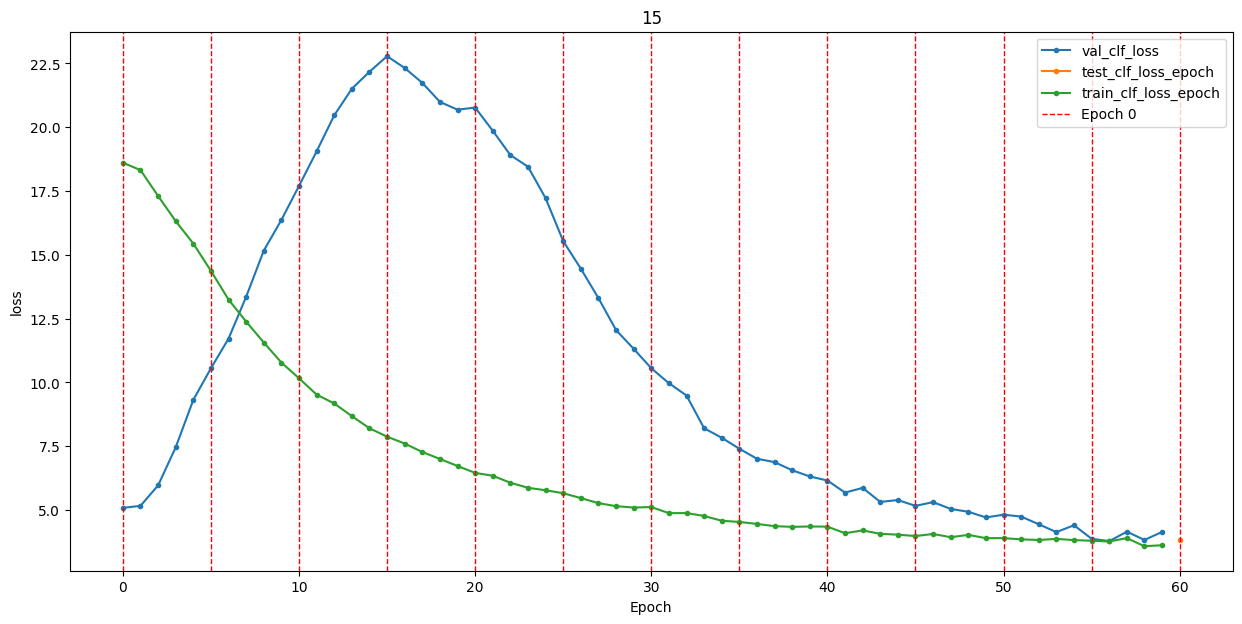

encoder and decoder structure: {'encoder': Sequential(
  (0): Sequential(
    (0): Linear(in_features=3737, out_features=3737, bias=True)
    (1): BatchNorm1d(3737, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
  )
  (1): Sequential(
    (0): Linear(in_features=3737, out_features=3737, bias=True)
    (1): BatchNorm1d(3737, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (2): Sequential(
    (0): Linear(in_features=3737, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (4): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(6

2025-03-09 11:33:57,379 INFO - lightning_fabric.utilities.seed - Global seed set to 1265 


the 6/7 fold train, use donor-18 as test set
the 6/7 fold train, use donor-18 as test set
Set x_sc_train data with shape (gene, cells): torch.Size([3737, 509])
Set x_sc_test data with shape (gene, cells): torch.Size([3737, 66])
label dictionary: {-1: -5.0, 0: -4.836, 3: -4.344, 9: -3.361, 15: -2.377, 18: -1.885, 60: 5.0}
Normalize train y_time_nor_train type: embryoneg5to5, with y_time_nor_train lable: [-1.  0.  3.  9. 15. 18. 60.], shape: torch.Size([509]), 
detail: [-5.    -4.836 -4.344 -3.361 -2.377 -1.885  5.   ]
Normalize test y_time_nor_train type: embryoneg5to5, with y_time_nor_train lable: [18.], shape: torch.Size([66]), 
detail: [-1.885]
Start training with epoch: 60. 


2025-03-09 11:33:57,727 INFO - pytorch_lightning.utilities.rank_zero - GPU available: True (cuda), used: True 
2025-03-09 11:33:57,728 INFO - pytorch_lightning.utilities.rank_zero - TPU available: False, using: 0 TPU cores 
2025-03-09 11:33:57,728 INFO - pytorch_lightning.utilities.rank_zero - IPU available: False, using: 0 IPUs 
2025-03-09 11:33:57,729 INFO - pytorch_lightning.utilities.rank_zero - HPU available: False, using: 0 HPUs 
2025-03-09 11:33:57,732 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:33:57,773 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 
2025-03-09

don't set batch
Free Memory Percentage: 72.38%
[INFO] GPU device 2 - total: 40.0GB; - memory free: 38.817GB.
[INFO] GPU device 1 - total: 40.0GB; - memory free: 38.817GB.
[INFO] GPU device 0 - total: 40.0GB; - memory free: 38.817GB.

[INFO] more than 5% free memory, Auto select GPU device 1,- memory free: 38.817GB
Auto select run on cuda:1
======= Training SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial =======


Sanity Checking: 0it [00:00, ?it/s]

/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(97.6042, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.4284, device='cuda:1'), 'train_KLD_step': tensor(-6.0140, device='cuda:1'), 'train_clf_loss_step': tensor(19.2349, device='cuda:1'), 'val_loss': tensor(16.4506, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.6861, device='cuda:1'), 'val_KLD': tensor(-0.2698, device='cuda:1'), 'val_clf_loss': tensor(3.1529, device='cuda:1'), 'train_loss_epoch': tensor(97.6042, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.4284, device='cuda:1'), 'train_KLD_epoch': tensor(-6.0140, device='cuda:1'), 'train_clf_loss_epoch': tensor(19.2349, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(94.7024, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.4271, device='cuda:1'), 'train_KLD_step': tensor(-6.4315, device='cuda:1'), 'train_clf_loss_step': tensor(18.6547, device='cuda:1'), 'val_loss': tensor(17.8881, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.7073, device='cuda:1'), 'val_KLD': tensor(-7.8852, device='cuda:1'), 'val_clf_loss': tensor(3.4358, device='cuda:1'), 'train_loss_epoch': tensor(94.7024, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.4271, device='cuda:1'), 'train_KLD_epoch': tensor(-6.4315, device='cuda:1'), 'train_clf_loss_epoch': tensor(18.6547, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(91.4758, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.3375, device='cuda:1'), 'train_KLD_step': tensor(-7.6279, device='cuda:1'), 'train_clf_loss_step': tensor(18.0273, device='cuda:1'), 'val_loss': tensor(25.2512, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.0463, device='cuda:1'), 'val_KLD': tensor(-82.0343, device='cuda:1'), 'val_clf_loss': tensor(4.8369, device='cuda:1'), 'train_loss_epoch': tensor(91.4758, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.3375, device='cuda:1'), 'train_KLD_epoch': tensor(-7.6279, device='cuda:1'), 'train_clf_loss_epoch': tensor(18.0273, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(85.4648, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.2742, device='cuda:1'), 'train_KLD_step': tensor(-9.0404, device='cuda:1'), 'train_clf_loss_step': tensor(16.8377, device='cuda:1'), 'val_loss': tensor(31.7507, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.2953, device='cuda:1'), 'val_KLD': tensor(-233.5675, device='cuda:1'), 'val_clf_loss': tensor(6.0794, device='cuda:1'), 'train_loss_epoch': tensor(85.4648, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.2742, device='cuda:1'), 'train_KLD_epoch': tensor(-9.0404, device='cuda:1'), 'train_clf_loss_epoch': tensor(16.8377, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(80.1724, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.2431, device='cuda:1'), 'train_KLD_step': tensor(-10.8086, device='cuda:1'), 'train_clf_loss_step': tensor(15.7853, device='cuda:1'), 'val_loss': tensor(35.9949, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.3545, device='cuda:1'), 'val_KLD': tensor(-391.4837, device='cuda:1'), 'val_clf_loss': tensor(6.9085, device='cuda:1'), 'train_loss_epoch': tensor(80.1724, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.2431, device='cuda:1'), 'train_KLD_epoch': tensor(-10.8086, device='cuda:1'), 'train_clf_loss_epoch': tensor(15.7853, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(75.3843, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.2287, device='cuda:1'), 'train_KLD_step': tensor(-13.1094, device='cuda:1'), 'train_clf_loss_step': tensor(14.8305, device='cuda:1'), 'val_loss': tensor(39.5918, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.3715, device='cuda:1'), 'val_KLD': tensor(-509.0681, device='cuda:1'), 'val_clf_loss': tensor(7.6186, device='cuda:1'), 'train_loss_epoch': tensor(75.3843, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.2287, device='cuda:1'), 'train_KLD_epoch': tensor(-13.1094, device='cuda:1'), 'train_clf_loss_epoch': tensor(14.8305, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(70.1971, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.2125, device='cuda:1'), 'train_KLD_step': tensor(-15.6300, device='cuda:1'), 'train_clf_loss_step': tensor(13.7962, device='cuda:1'), 'val_loss': tensor(43.7102, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.3994, device='cuda:1'), 'val_KLD': tensor(-662.9893, device='cuda:1'), 'val_clf_loss': tensor(8.4290, device='cuda:1'), 'train_loss_epoch': tensor(70.1971, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.2125, device='cuda:1'), 'train_KLD_epoch': tensor(-15.6300, device='cuda:1'), 'train_clf_loss_epoch': tensor(13.7962, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(65.3849, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1957, device='cuda:1'), 'train_KLD_step': tensor(-18.3514, device='cuda:1'), 'train_clf_loss_step': tensor(12.8369, device='cuda:1'), 'val_loss': tensor(49.1624, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.4093, device='cuda:1'), 'val_KLD': tensor(-828.7952, device='cuda:1'), 'val_clf_loss': tensor(9.5092, device='cuda:1'), 'train_loss_epoch': tensor(65.3849, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1957, device='cuda:1'), 'train_KLD_epoch': tensor(-18.3514, device='cuda:1'), 'train_clf_loss_epoch': tensor(12.8369, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(61.1183, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1802, device='cuda:1'), 'train_KLD_step': tensor(-21.3703, device='cuda:1'), 'train_clf_loss_step': tensor(11.9866, device='cuda:1'), 'val_loss': tensor(55.6397, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.4177, device='cuda:1'), 'val_KLD': tensor(-890.0729, device='cuda:1'), 'val_clf_loss': tensor(10.7999, device='cuda:1'), 'train_loss_epoch': tensor(61.1183, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1802, device='cuda:1'), 'train_KLD_epoch': tensor(-21.3703, device='cuda:1'), 'train_clf_loss_epoch': tensor(11.9866, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(57.2263, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1677, device='cuda:1'), 'train_KLD_step': tensor(-24.5255, device='cuda:1'), 'train_clf_loss_step': tensor(11.2105, device='cuda:1'), 'val_loss': tensor(62.8963, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.4258, device='cuda:1'), 'val_KLD': tensor(-863.0077, device='cuda:1'), 'val_clf_loss': tensor(12.2509, device='cuda:1'), 'train_loss_epoch': tensor(57.2263, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1677, device='cuda:1'), 'train_KLD_epoch': tensor(-24.5255, device='cuda:1'), 'train_clf_loss_epoch': tensor(11.2105, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(54.0888, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1676, device='cuda:1'), 'train_KLD_step': tensor(-27.6545, device='cuda:1'), 'train_clf_loss_step': tensor(10.5828, device='cuda:1'), 'val_loss': tensor(71.0737, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.4368, device='cuda:1'), 'val_KLD': tensor(-811.0300, device='cuda:1'), 'val_clf_loss': tensor(13.8868, device='cuda:1'), 'train_loss_epoch': tensor(54.0888, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1676, device='cuda:1'), 'train_KLD_epoch': tensor(-27.6545, device='cuda:1'), 'train_clf_loss_epoch': tensor(10.5828, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(50.9286, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1613, device='cuda:1'), 'train_KLD_step': tensor(-30.6656, device='cuda:1'), 'train_clf_loss_step': tensor(9.9519, device='cuda:1'), 'val_loss': tensor(79.7643, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.4344, device='cuda:1'), 'val_KLD': tensor(-802.3751, device='cuda:1'), 'val_clf_loss': tensor(15.6259, device='cuda:1'), 'train_loss_epoch': tensor(50.9286, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1613, device='cuda:1'), 'train_KLD_epoch': tensor(-30.6656, device='cuda:1'), 'train_clf_loss_epoch': tensor(9.9519, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(48.0575, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1545, device='cuda:1'), 'train_KLD_step': tensor(-33.5577, device='cuda:1'), 'train_clf_loss_step': tensor(9.3789, device='cuda:1'), 'val_loss': tensor(88.6938, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.4407, device='cuda:1'), 'val_KLD': tensor(-747.0551, device='cuda:1'), 'val_clf_loss': tensor(17.4133, device='cuda:1'), 'train_loss_epoch': tensor(48.0575, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1545, device='cuda:1'), 'train_KLD_epoch': tensor(-33.5577, device='cuda:1'), 'train_clf_loss_epoch': tensor(9.3789, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(45.3946, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1561, device='cuda:1'), 'train_KLD_step': tensor(-36.2204, device='cuda:1'), 'train_clf_loss_step': tensor(8.8459, device='cuda:1'), 'val_loss': tensor(98.0013, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.3915, device='cuda:1'), 'val_KLD': tensor(-671.1803, device='cuda:1'), 'val_clf_loss': tensor(19.2884, device='cuda:1'), 'train_loss_epoch': tensor(45.3946, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1561, device='cuda:1'), 'train_KLD_epoch': tensor(-36.2204, device='cuda:1'), 'train_clf_loss_epoch': tensor(8.8459, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(43.6757, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1449, device='cuda:1'), 'train_KLD_step': tensor(-38.6614, device='cuda:1'), 'train_clf_loss_step': tensor(8.5042, device='cuda:1'), 'val_loss': tensor(107.7083, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.3515, device='cuda:1'), 'val_KLD': tensor(-599.3121, device='cuda:1'), 'val_clf_loss': tensor(21.2414, device='cuda:1'), 'train_loss_epoch': tensor(43.6757, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1449, device='cuda:1'), 'train_KLD_epoch': tensor(-38.6614, device='cuda:1'), 'train_clf_loss_epoch': tensor(8.5042, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(41.7563, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1468, device='cuda:1'), 'train_KLD_step': tensor(-40.9540, device='cuda:1'), 'train_clf_loss_step': tensor(8.1198, device='cuda:1'), 'val_loss': tensor(117.7093, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.3535, device='cuda:1'), 'val_KLD': tensor(-521.9252, device='cuda:1'), 'val_clf_loss': tensor(23.2450, device='cuda:1'), 'train_loss_epoch': tensor(41.7563, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1468, device='cuda:1'), 'train_KLD_epoch': tensor(-40.9540, device='cuda:1'), 'train_clf_loss_epoch': tensor(8.1198, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(40.1022, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1523, device='cuda:1'), 'train_KLD_step': tensor(-43.0386, device='cuda:1'), 'train_clf_loss_step': tensor(7.7878, device='cuda:1'), 'val_loss': tensor(127.2150, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.3373, device='cuda:1'), 'val_KLD': tensor(-456.4782, device='cuda:1'), 'val_clf_loss': tensor(25.1527, device='cuda:1'), 'train_loss_epoch': tensor(40.1022, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1523, device='cuda:1'), 'train_KLD_epoch': tensor(-43.0386, device='cuda:1'), 'train_clf_loss_epoch': tensor(7.7878, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(38.4150, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1487, device='cuda:1'), 'train_KLD_step': tensor(-44.9850, device='cuda:1'), 'train_clf_loss_step': tensor(7.4510, device='cuda:1'), 'val_loss': tensor(135.4853, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.2972, device='cuda:1'), 'val_KLD': tensor(-400.1132, device='cuda:1'), 'val_clf_loss': tensor(26.8176, device='cuda:1'), 'train_loss_epoch': tensor(38.4150, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1487, device='cuda:1'), 'train_KLD_epoch': tensor(-44.9850, device='cuda:1'), 'train_clf_loss_epoch': tensor(7.4510, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(37.1274, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1443, device='cuda:1'), 'train_KLD_step': tensor(-46.8163, device='cuda:1'), 'train_clf_loss_step': tensor(7.1943, device='cuda:1'), 'val_loss': tensor(143.4687, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.3121, device='cuda:1'), 'val_KLD': tensor(-353.9269, device='cuda:1'), 'val_clf_loss': tensor(28.4136, device='cuda:1'), 'train_loss_epoch': tensor(37.1274, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1443, device='cuda:1'), 'train_KLD_epoch': tensor(-46.8163, device='cuda:1'), 'train_clf_loss_epoch': tensor(7.1943, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(34.8780, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1299, device='cuda:1'), 'train_KLD_step': tensor(-48.5322, device='cuda:1'), 'train_clf_loss_step': tensor(6.7472, device='cuda:1'), 'val_loss': tensor(150.5867, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.2556, device='cuda:1'), 'val_KLD': tensor(-316.1294, device='cuda:1'), 'val_clf_loss': tensor(29.8504, device='cuda:1'), 'train_loss_epoch': tensor(34.8780, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1299, device='cuda:1'), 'train_KLD_epoch': tensor(-48.5322, device='cuda:1'), 'train_clf_loss_epoch': tensor(6.7472, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(34.1794, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1353, device='cuda:1'), 'train_KLD_step': tensor(-50.1408, device='cuda:1'), 'train_clf_loss_step': tensor(6.6063, device='cuda:1'), 'val_loss': tensor(157.1375, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.1609, device='cuda:1'), 'val_KLD': tensor(-275.0995, device='cuda:1'), 'val_clf_loss': tensor(31.1816, device='cuda:1'), 'train_loss_epoch': tensor(34.1794, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1353, device='cuda:1'), 'train_KLD_epoch': tensor(-50.1408, device='cuda:1'), 'train_clf_loss_epoch': tensor(6.6063, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(32.9210, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1116, device='cuda:1'), 'train_KLD_step': tensor(-51.5984, device='cuda:1'), 'train_clf_loss_step': tensor(6.3593, device='cuda:1'), 'val_loss': tensor(162.4338, device='cuda:1'), 'val_Reconstruction_loss': tensor(1.0261, device='cuda:1'), 'val_KLD': tensor(-239.0839, device='cuda:1'), 'val_clf_loss': tensor(32.2696, device='cuda:1'), 'train_loss_epoch': tensor(32.9210, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1116, device='cuda:1'), 'train_KLD_epoch': tensor(-51.5984, device='cuda:1'), 'train_clf_loss_epoch': tensor(6.3593, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(32.3647, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1142, device='cuda:1'), 'train_KLD_step': tensor(-52.9150, device='cuda:1'), 'train_clf_loss_step': tensor(6.2474, device='cuda:1'), 'val_loss': tensor(166.9679, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.9601, device='cuda:1'), 'val_KLD': tensor(-200.2175, device='cuda:1'), 'val_clf_loss': tensor(33.1915, device='cuda:1'), 'train_loss_epoch': tensor(32.3647, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1142, device='cuda:1'), 'train_KLD_epoch': tensor(-52.9150, device='cuda:1'), 'train_clf_loss_epoch': tensor(6.2474, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(31.1398, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1149, device='cuda:1'), 'train_KLD_step': tensor(-54.0995, device='cuda:1'), 'train_clf_loss_step': tensor(6.0023, device='cuda:1'), 'val_loss': tensor(169.6407, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.9451, device='cuda:1'), 'val_KLD': tensor(-170.8679, device='cuda:1'), 'val_clf_loss': tensor(33.7306, device='cuda:1'), 'train_loss_epoch': tensor(31.1398, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1149, device='cuda:1'), 'train_KLD_epoch': tensor(-54.0995, device='cuda:1'), 'train_clf_loss_epoch': tensor(6.0023, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(30.1022, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1130, device='cuda:1'), 'train_KLD_step': tensor(-55.0928, device='cuda:1'), 'train_clf_loss_step': tensor(5.7951, device='cuda:1'), 'val_loss': tensor(168.6822, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.9213, device='cuda:1'), 'val_KLD': tensor(-149.6443, device='cuda:1'), 'val_clf_loss': tensor(33.5447, device='cuda:1'), 'train_loss_epoch': tensor(30.1022, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1130, device='cuda:1'), 'train_KLD_epoch': tensor(-55.0928, device='cuda:1'), 'train_clf_loss_epoch': tensor(5.7951, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(30.0872, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1059, device='cuda:1'), 'train_KLD_step': tensor(-55.9518, device='cuda:1'), 'train_clf_loss_step': tensor(5.7935, device='cuda:1'), 'val_loss': tensor(169.5121, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.9097, device='cuda:1'), 'val_KLD': tensor(-134.5769, device='cuda:1'), 'val_clf_loss': tensor(33.7137, device='cuda:1'), 'train_loss_epoch': tensor(30.0872, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1059, device='cuda:1'), 'train_KLD_epoch': tensor(-55.9518, device='cuda:1'), 'train_clf_loss_epoch': tensor(5.7935, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(29.0397, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1067, device='cuda:1'), 'train_KLD_step': tensor(-56.7318, device='cuda:1'), 'train_clf_loss_step': tensor(5.5838, device='cuda:1'), 'val_loss': tensor(167.4396, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.8793, device='cuda:1'), 'val_KLD': tensor(-121.9809, device='cuda:1'), 'val_clf_loss': tensor(33.3060, device='cuda:1'), 'train_loss_epoch': tensor(29.0397, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1067, device='cuda:1'), 'train_KLD_epoch': tensor(-56.7318, device='cuda:1'), 'train_clf_loss_epoch': tensor(5.5838, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(28.3931, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0939, device='cuda:1'), 'train_KLD_step': tensor(-57.3975, device='cuda:1'), 'train_clf_loss_step': tensor(5.4570, device='cuda:1'), 'val_loss': tensor(165.9318, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.8269, device='cuda:1'), 'val_KLD': tensor(-110.8396, device='cuda:1'), 'val_clf_loss': tensor(33.0154, device='cuda:1'), 'train_loss_epoch': tensor(28.3931, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0939, device='cuda:1'), 'train_KLD_epoch': tensor(-57.3975, device='cuda:1'), 'train_clf_loss_epoch': tensor(5.4570, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(27.4616, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.1004, device='cuda:1'), 'train_KLD_step': tensor(-58.0007, device='cuda:1'), 'train_clf_loss_step': tensor(5.2694, device='cuda:1'), 'val_loss': tensor(163.0281, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.7649, device='cuda:1'), 'val_KLD': tensor(-101.0034, device='cuda:1'), 'val_clf_loss': tensor(32.4476, device='cuda:1'), 'train_loss_epoch': tensor(27.4616, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.1004, device='cuda:1'), 'train_KLD_epoch': tensor(-58.0007, device='cuda:1'), 'train_clf_loss_epoch': tensor(5.2694, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(26.9011, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0885, device='cuda:1'), 'train_KLD_step': tensor(-58.5376, device='cuda:1'), 'train_clf_loss_step': tensor(5.1596, device='cuda:1'), 'val_loss': tensor(157.5012, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.7105, device='cuda:1'), 'val_KLD': tensor(-92.5986, device='cuda:1'), 'val_clf_loss': tensor(31.3535, device='cuda:1'), 'train_loss_epoch': tensor(26.9011, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0885, device='cuda:1'), 'train_KLD_epoch': tensor(-58.5376, device='cuda:1'), 'train_clf_loss_epoch': tensor(5.1596, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(26.4249, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0926, device='cuda:1'), 'train_KLD_step': tensor(-59.0436, device='cuda:1'), 'train_clf_loss_step': tensor(5.0635, device='cuda:1'), 'val_loss': tensor(153.5923, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.7280, device='cuda:1'), 'val_KLD': tensor(-84.0227, device='cuda:1'), 'val_clf_loss': tensor(30.5686, device='cuda:1'), 'train_loss_epoch': tensor(26.4249, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0926, device='cuda:1'), 'train_KLD_epoch': tensor(-59.0436, device='cuda:1'), 'train_clf_loss_epoch': tensor(5.0635, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(25.9768, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0832, device='cuda:1'), 'train_KLD_step': tensor(-59.5305, device='cuda:1'), 'train_clf_loss_step': tensor(4.9757, device='cuda:1'), 'val_loss': tensor(149.7115, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.7368, device='cuda:1'), 'val_KLD': tensor(-76.7528, device='cuda:1'), 'val_clf_loss': tensor(29.7911, device='cuda:1'), 'train_loss_epoch': tensor(25.9768, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0832, device='cuda:1'), 'train_KLD_epoch': tensor(-59.5305, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.9757, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(25.4864, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0866, device='cuda:1'), 'train_KLD_step': tensor(-59.9507, device='cuda:1'), 'train_clf_loss_step': tensor(4.8770, device='cuda:1'), 'val_loss': tensor(144.7179, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.7287, device='cuda:1'), 'val_KLD': tensor(-70.8360, device='cuda:1'), 'val_clf_loss': tensor(28.7943, device='cuda:1'), 'train_loss_epoch': tensor(25.4864, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0866, device='cuda:1'), 'train_KLD_epoch': tensor(-59.9507, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.8770, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(25.4799, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0803, device='cuda:1'), 'train_KLD_step': tensor(-60.3192, device='cuda:1'), 'train_clf_loss_step': tensor(4.8769, device='cuda:1'), 'val_loss': tensor(136.2033, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.7222, device='cuda:1'), 'val_KLD': tensor(-65.6201, device='cuda:1'), 'val_clf_loss': tensor(27.0929, device='cuda:1'), 'train_loss_epoch': tensor(25.4799, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0803, device='cuda:1'), 'train_KLD_epoch': tensor(-60.3192, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.8769, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(24.4166, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0798, device='cuda:1'), 'train_KLD_step': tensor(-60.6607, device='cuda:1'), 'train_clf_loss_step': tensor(4.6643, device='cuda:1'), 'val_loss': tensor(131.7689, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.7163, device='cuda:1'), 'val_KLD': tensor(-60.5323, device='cuda:1'), 'val_clf_loss': tensor(26.2075, device='cuda:1'), 'train_loss_epoch': tensor(24.4166, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0798, device='cuda:1'), 'train_KLD_epoch': tensor(-60.6607, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.6643, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(24.0881, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0775, device='cuda:1'), 'train_KLD_step': tensor(-60.9793, device='cuda:1'), 'train_clf_loss_step': tensor(4.5991, device='cuda:1'), 'val_loss': tensor(130.1858, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.6885, device='cuda:1'), 'val_KLD': tensor(-58.6273, device='cuda:1'), 'val_clf_loss': tensor(25.8965, device='cuda:1'), 'train_loss_epoch': tensor(24.0881, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0775, device='cuda:1'), 'train_KLD_epoch': tensor(-60.9793, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.5991, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(23.9459, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0737, device='cuda:1'), 'train_KLD_step': tensor(-61.2945, device='cuda:1'), 'train_clf_loss_step': tensor(4.5714, device='cuda:1'), 'val_loss': tensor(127.8710, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.7164, device='cuda:1'), 'val_KLD': tensor(-57.2769, device='cuda:1'), 'val_clf_loss': tensor(25.4281, device='cuda:1'), 'train_loss_epoch': tensor(23.9459, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0737, device='cuda:1'), 'train_KLD_epoch': tensor(-61.2945, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.5714, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(23.2081, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0715, device='cuda:1'), 'train_KLD_step': tensor(-61.5971, device='cuda:1'), 'train_clf_loss_step': tensor(4.4243, device='cuda:1'), 'val_loss': tensor(125.4373, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.7010, device='cuda:1'), 'val_KLD': tensor(-56.5800, device='cuda:1'), 'val_clf_loss': tensor(24.9444, device='cuda:1'), 'train_loss_epoch': tensor(23.2081, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0715, device='cuda:1'), 'train_KLD_epoch': tensor(-61.5971, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.4243, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(23.1461, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0754, device='cuda:1'), 'train_KLD_step': tensor(-61.8915, device='cuda:1'), 'train_clf_loss_step': tensor(4.4111, device='cuda:1'), 'val_loss': tensor(122.7990, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.6971, device='cuda:1'), 'val_KLD': tensor(-55.4948, device='cuda:1'), 'val_clf_loss': tensor(24.4176, device='cuda:1'), 'train_loss_epoch': tensor(23.1461, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0754, device='cuda:1'), 'train_KLD_epoch': tensor(-61.8915, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.4111, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(22.8294, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0597, device='cuda:1'), 'train_KLD_step': tensor(-62.1661, device='cuda:1'), 'train_clf_loss_step': tensor(4.3508, device='cuda:1'), 'val_loss': tensor(119.4122, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.6935, device='cuda:1'), 'val_KLD': tensor(-54.1408, device='cuda:1'), 'val_clf_loss': tensor(23.7410, device='cuda:1'), 'train_loss_epoch': tensor(22.8294, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0597, device='cuda:1'), 'train_KLD_epoch': tensor(-62.1661, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.3508, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(22.9739, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0573, device='cuda:1'), 'train_KLD_step': tensor(-62.4233, device='cuda:1'), 'train_clf_loss_step': tensor(4.3802, device='cuda:1'), 'val_loss': tensor(118.5898, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.7116, device='cuda:1'), 'val_KLD': tensor(-52.9290, device='cuda:1'), 'val_clf_loss': tensor(23.5730, device='cuda:1'), 'train_loss_epoch': tensor(22.9739, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0573, device='cuda:1'), 'train_KLD_epoch': tensor(-62.4233, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.3802, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(22.3683, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0591, device='cuda:1'), 'train_KLD_step': tensor(-62.6503, device='cuda:1'), 'train_clf_loss_step': tensor(4.2587, device='cuda:1'), 'val_loss': tensor(113.4725, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.6840, device='cuda:1'), 'val_KLD': tensor(-50.6745, device='cuda:1'), 'val_clf_loss': tensor(22.5551, device='cuda:1'), 'train_loss_epoch': tensor(22.3683, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0591, device='cuda:1'), 'train_KLD_epoch': tensor(-62.6503, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.2587, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(22.4557, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0517, device='cuda:1'), 'train_KLD_step': tensor(-62.8564, device='cuda:1'), 'train_clf_loss_step': tensor(4.2777, device='cuda:1'), 'val_loss': tensor(109.7807, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.7090, device='cuda:1'), 'val_KLD': tensor(-48.4677, device='cuda:1'), 'val_clf_loss': tensor(21.8119, device='cuda:1'), 'train_loss_epoch': tensor(22.4557, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0517, device='cuda:1'), 'train_KLD_epoch': tensor(-62.8564, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.2777, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(22.2381, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0523, device='cuda:1'), 'train_KLD_step': tensor(-63.0392, device='cuda:1'), 'train_clf_loss_step': tensor(4.2340, device='cuda:1'), 'val_loss': tensor(105.4728, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.7108, device='cuda:1'), 'val_KLD': tensor(-46.7648, device='cuda:1'), 'val_clf_loss': tensor(20.9500, device='cuda:1'), 'train_loss_epoch': tensor(22.2381, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0523, device='cuda:1'), 'train_KLD_epoch': tensor(-63.0392, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.2340, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(21.6499, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0498, device='cuda:1'), 'train_KLD_step': tensor(-63.2087, device='cuda:1'), 'train_clf_loss_step': tensor(4.1169, device='cuda:1'), 'val_loss': tensor(105.4322, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.6707, device='cuda:1'), 'val_KLD': tensor(-45.9014, device='cuda:1'), 'val_clf_loss': tensor(20.9500, device='cuda:1'), 'train_loss_epoch': tensor(21.6499, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0498, device='cuda:1'), 'train_KLD_epoch': tensor(-63.2087, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.1169, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(21.4509, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0470, device='cuda:1'), 'train_KLD_step': tensor(-63.3705, device='cuda:1'), 'train_clf_loss_step': tensor(4.0776, device='cuda:1'), 'val_loss': tensor(99.1761, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.7024, device='cuda:1'), 'val_KLD': tensor(-44.7536, device='cuda:1'), 'val_clf_loss': tensor(19.6925, device='cuda:1'), 'train_loss_epoch': tensor(21.4509, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0470, device='cuda:1'), 'train_KLD_epoch': tensor(-63.3705, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.0776, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(21.1488, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0478, device='cuda:1'), 'train_KLD_step': tensor(-63.5247, device='cuda:1'), 'train_clf_loss_step': tensor(4.0170, device='cuda:1'), 'val_loss': tensor(101.4724, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.7097, device='cuda:1'), 'val_KLD': tensor(-44.0424, device='cuda:1'), 'val_clf_loss': tensor(20.1504, device='cuda:1'), 'train_loss_epoch': tensor(21.1488, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0478, device='cuda:1'), 'train_KLD_epoch': tensor(-63.5247, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.0170, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(21.1082, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0376, device='cuda:1'), 'train_KLD_step': tensor(-63.6922, device='cuda:1'), 'train_clf_loss_step': tensor(4.0109, device='cuda:1'), 'val_loss': tensor(98.5628, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.6929, device='cuda:1'), 'val_KLD': tensor(-43.2688, device='cuda:1'), 'val_clf_loss': tensor(19.5718, device='cuda:1'), 'train_loss_epoch': tensor(21.1082, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0376, device='cuda:1'), 'train_KLD_epoch': tensor(-63.6922, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.0109, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(21.5715, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0362, device='cuda:1'), 'train_KLD_step': tensor(-63.8433, device='cuda:1'), 'train_clf_loss_step': tensor(4.1039, device='cuda:1'), 'val_loss': tensor(96.5869, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.6851, device='cuda:1'), 'val_KLD': tensor(-42.2460, device='cuda:1'), 'val_clf_loss': tensor(19.1782, device='cuda:1'), 'train_loss_epoch': tensor(21.5715, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0362, device='cuda:1'), 'train_KLD_epoch': tensor(-63.8433, device='cuda:1'), 'train_clf_loss_epoch': tensor(4.1039, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.8021, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0435, device='cuda:1'), 'train_KLD_step': tensor(-63.9840, device='cuda:1'), 'train_clf_loss_step': tensor(3.9485, device='cuda:1'), 'val_loss': tensor(93.0138, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.6743, device='cuda:1'), 'val_KLD': tensor(-41.4000, device='cuda:1'), 'val_clf_loss': tensor(18.4658, device='cuda:1'), 'train_loss_epoch': tensor(20.8021, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0435, device='cuda:1'), 'train_KLD_epoch': tensor(-63.9840, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.9485, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(21.0289, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0448, device='cuda:1'), 'train_KLD_step': tensor(-64.1050, device='cuda:1'), 'train_clf_loss_step': tensor(3.9936, device='cuda:1'), 'val_loss': tensor(92.8099, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.6840, device='cuda:1'), 'val_KLD': tensor(-40.4874, device='cuda:1'), 'val_clf_loss': tensor(18.4232, device='cuda:1'), 'train_loss_epoch': tensor(21.0289, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0448, device='cuda:1'), 'train_KLD_epoch': tensor(-64.1050, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.9936, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.9886, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0542, device='cuda:1'), 'train_KLD_step': tensor(-64.2105, device='cuda:1'), 'train_clf_loss_step': tensor(3.9837, device='cuda:1'), 'val_loss': tensor(91.1181, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.6956, device='cuda:1'), 'val_KLD': tensor(-39.8893, device='cuda:1'), 'val_clf_loss': tensor(18.0825, device='cuda:1'), 'train_loss_epoch': tensor(20.9886, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0542, device='cuda:1'), 'train_KLD_epoch': tensor(-64.2105, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.9837, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.4047, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0387, device='cuda:1'), 'train_KLD_step': tensor(-64.3155, device='cuda:1'), 'train_clf_loss_step': tensor(3.8700, device='cuda:1'), 'val_loss': tensor(92.0605, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.6688, device='cuda:1'), 'val_KLD': tensor(-39.5266, device='cuda:1'), 'val_clf_loss': tensor(18.2764, device='cuda:1'), 'train_loss_epoch': tensor(20.4047, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0387, device='cuda:1'), 'train_KLD_epoch': tensor(-64.3155, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.8700, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.6261, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0354, device='cuda:1'), 'train_KLD_step': tensor(-64.4073, device='cuda:1'), 'train_clf_loss_step': tensor(3.9149, device='cuda:1'), 'val_loss': tensor(92.1677, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.6725, device='cuda:1'), 'val_KLD': tensor(-39.8420, device='cuda:1'), 'val_clf_loss': tensor(18.2971, device='cuda:1'), 'train_loss_epoch': tensor(20.6261, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0354, device='cuda:1'), 'train_KLD_epoch': tensor(-64.4073, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.9149, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.7500, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0454, device='cuda:1'), 'train_KLD_step': tensor(-64.5078, device='cuda:1'), 'train_clf_loss_step': tensor(3.9377, device='cuda:1'), 'val_loss': tensor(93.6594, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.6908, device='cuda:1'), 'val_KLD': tensor(-40.4899, device='cuda:1'), 'val_clf_loss': tensor(18.5917, device='cuda:1'), 'train_loss_epoch': tensor(20.7500, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0454, device='cuda:1'), 'train_KLD_epoch': tensor(-64.5078, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.9377, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(19.9558, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0345, device='cuda:1'), 'train_KLD_step': tensor(-64.6022, device='cuda:1'), 'train_clf_loss_step': tensor(3.7810, device='cuda:1'), 'val_loss': tensor(89.0314, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.6821, device='cuda:1'), 'val_KLD': tensor(-41.2005, device='cuda:1'), 'val_clf_loss': tensor(17.6678, device='cuda:1'), 'train_loss_epoch': tensor(19.9558, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0345, device='cuda:1'), 'train_KLD_epoch': tensor(-64.6022, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.7810, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.0075, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0413, device='cuda:1'), 'train_KLD_step': tensor(-64.6965, device='cuda:1'), 'train_clf_loss_step': tensor(3.7900, device='cuda:1'), 'val_loss': tensor(94.6846, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.7205, device='cuda:1'), 'val_KLD': tensor(-41.9270, device='cuda:1'), 'val_clf_loss': tensor(18.7907, device='cuda:1'), 'train_loss_epoch': tensor(20.0075, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0413, device='cuda:1'), 'train_KLD_epoch': tensor(-64.6965, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.7900, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(20.6636, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0371, device='cuda:1'), 'train_KLD_step': tensor(-64.7856, device='cuda:1'), 'train_clf_loss_step': tensor(3.9221, device='cuda:1'), 'val_loss': tensor(92.7611, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.6761, device='cuda:1'), 'val_KLD': tensor(-42.2423, device='cuda:1'), 'val_clf_loss': tensor(18.4149, device='cuda:1'), 'train_loss_epoch': tensor(20.6636, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0371, device='cuda:1'), 'train_KLD_epoch': tensor(-64.7856, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.9221, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(19.6168, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0358, device='cuda:1'), 'train_KLD_step': tensor(-64.8761, device='cuda:1'), 'train_clf_loss_step': tensor(3.7130, device='cuda:1'), 'val_loss': tensor(93.4902, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.6972, device='cuda:1'), 'val_KLD': tensor(-42.1697, device='cuda:1'), 'val_clf_loss': tensor(18.5565, device='cuda:1'), 'train_loss_epoch': tensor(19.6168, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0358, device='cuda:1'), 'train_KLD_epoch': tensor(-64.8761, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.7130, device='cuda:1')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(19.9713, device='cuda:1'), 'train_Reconstruction_loss_step': tensor(1.0332, device='cuda:1'), 'train_KLD_step': tensor(-64.9535, device='cuda:1'), 'train_clf_loss_step': tensor(3.7844, device='cuda:1'), 'val_loss': tensor(95.8882, device='cuda:1'), 'val_Reconstruction_loss': tensor(0.7087, device='cuda:1'), 'val_KLD': tensor(-42.1218, device='cuda:1'), 'val_clf_loss': tensor(19.0338, device='cuda:1'), 'train_loss_epoch': tensor(19.9713, device='cuda:1'), 'train_Reconstruction_loss_epoch': tensor(1.0332, device='cuda:1'), 'train_KLD_epoch': tensor(-64.9535, device='cuda:1'), 'train_clf_loss_epoch': tensor(3.7844, device='cuda:1')}


2025-03-09 11:36:15,561 INFO - pytorch_lightning.utilities.rank_zero - `Trainer.fit` stopped: `max_epochs=60` reached. 
2025-03-09 11:36:15,889 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:36:15,964 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 
/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on 

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_KLD_epoch         │       -42.12179946899414       │
│ test_Reconstruction_loss_epoch │       0.6941933035850525       │
│      test_clf_loss_epoch       │       18.788496017456055       │
│        test_loss_epoch         │       94.64720916748047        │
└────────────────────────────────┴────────────────────────────────┘

2025-03-09 11:36:16,389 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:36:16,444 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 


this epoch final, on test data:[{'test_loss_epoch': 94.64720916748047, 'test_Reconstruction_loss_epoch': 0.6941933035850525, 'test_KLD_epoch': -42.12179946899414, 'test_clf_loss_epoch': 18.788496017456055}]


/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

2025-03-09 11:36:16,864 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:36:16,925 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 


Predicting: 0it [00:00, ?it/s]

2025-03-09 11:36:17,351 INFO - tensorboard - Directory watcher advancing from /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/18/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1741538037.GPU2.1181448.11 to /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/18/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1741538176.GPU2.1181448.12 
2025-03-09 11:36:17,353 INFO - tensorboard - No path found after /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/18/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1741538176.GPU2.1181448.12 
2025-03-09 11:36:17,353 INFO - TemporalVAE.utils.utils_Dandan_plot - plot training process. 
2025-03-09 11:36:17,366 INFO - tensorbo

The Array does not contain NaN values
predicted time of test donor is continuous.
Plot training loss line for check.
All tags in logger: ['lr-Adam', 'train_loss_step', 'train_Reconstruction_loss_step', 'train_KLD_step', 'train_clf_loss_step', 'epoch', 'val_loss', 'val_Reconstruction_loss', 'val_KLD', 'val_clf_loss', 'train_loss_epoch', 'train_Reconstruction_loss_epoch', 'train_KLD_epoch', 'train_clf_loss_epoch', 'test_loss_step', 'test_Reconstruction_loss_step', 'test_KLD_step', 'test_clf_loss_step', 'test_loss_epoch', 'test_Reconstruction_loss_epoch', 'test_KLD_epoch', 'test_clf_loss_epoch']
plot tags ['val_clf_loss', 'test_clf_loss_epoch', 'train_clf_loss_epoch']


2025-03-09 11:36:17,568 INFO - TemporalVAE.utils.utils_Dandan_plot - Finish save images at: /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/18/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/trainingLoss_val_clf_loss_test_clf_loss_epoch_train_clf_loss_epoch_18.png 


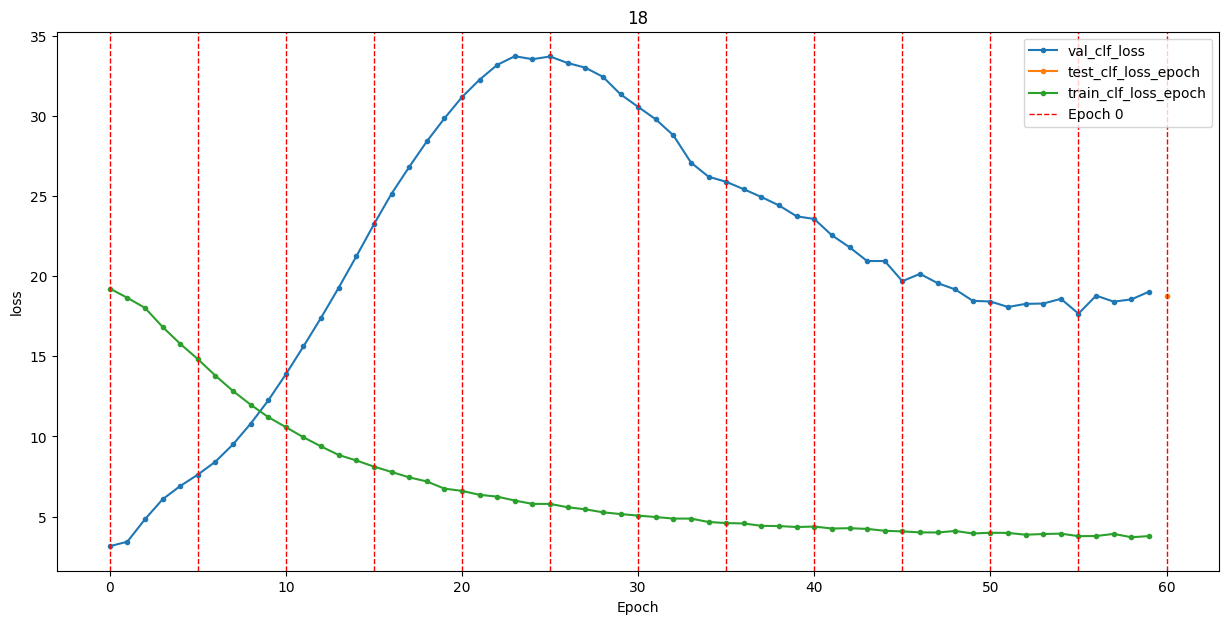

encoder and decoder structure: {'encoder': Sequential(
  (0): Sequential(
    (0): Linear(in_features=3737, out_features=3737, bias=True)
    (1): BatchNorm1d(3737, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
  )
  (1): Sequential(
    (0): Linear(in_features=3737, out_features=3737, bias=True)
    (1): BatchNorm1d(3737, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (2): Sequential(
    (0): Linear(in_features=3737, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (4): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(6

2025-03-09 11:36:18,208 INFO - lightning_fabric.utilities.seed - Global seed set to 1265 


detail information about structure save at： /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/18/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/model.pth
the 7/7 fold train, use donor-60 as test set
the 7/7 fold train, use donor-60 as test set
Set x_sc_train data with shape (gene, cells): torch.Size([3737, 449])
Set x_sc_test data with shape (gene, cells): torch.Size([3737, 126])
label dictionary: {-1: -5.0, 0: -4.836, 3: -4.344, 9: -3.361, 15: -2.377, 18: -1.885, 60: 5.0}
Normalize train y_time_nor_train type: embryoneg5to5, with y_time_nor_train lable: [-1.  0.  3.  9. 15. 18. 60.], shape: torch.Size([449]), 
detail: [-5.    -4.836 -4.344 -3.361 -2.377 -1.885  5.   ]
Normalize test y_time_nor_train type: embryoneg5to5, with y_time_nor_train lable: [60.], shape: torch.Size([126]), 
detail: [5.]
Start training with epoch: 60. 


2025-03-09 11:36:18,568 INFO - pytorch_lightning.utilities.rank_zero - GPU available: True (cuda), used: True 
2025-03-09 11:36:18,569 INFO - pytorch_lightning.utilities.rank_zero - TPU available: False, using: 0 TPU cores 
2025-03-09 11:36:18,569 INFO - pytorch_lightning.utilities.rank_zero - IPU available: False, using: 0 IPUs 
2025-03-09 11:36:18,570 INFO - pytorch_lightning.utilities.rank_zero - HPU available: False, using: 0 HPUs 
2025-03-09 11:36:18,573 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:36:18,612 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 
2025-03-09

don't set batch
Free Memory Percentage: 72.28%
[INFO] GPU device 2 - total: 40.0GB; - memory free: 38.817GB.
[INFO] GPU device 1 - total: 40.0GB; - memory free: 38.815GB.
[INFO] GPU device 0 - total: 40.0GB; - memory free: 38.817GB.

[INFO] more than 5% free memory, Auto select GPU device 0,- memory free: 38.817GB
Auto select run on cuda:0
======= Training SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial =======


Sanity Checking: 0it [00:00, ?it/s]

/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(76.0574, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.4620, device='cuda:0'), 'train_KLD_step': tensor(-5.9933, device='cuda:0'), 'train_clf_loss_step': tensor(14.9188, device='cuda:0'), 'val_loss': tensor(130.9386, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7401, device='cuda:0'), 'val_KLD': tensor(-0.2824, device='cuda:0'), 'val_clf_loss': tensor(26.0397, device='cuda:0'), 'train_loss_epoch': tensor(76.0574, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.4620, device='cuda:0'), 'train_KLD_epoch': tensor(-5.9933, device='cuda:0'), 'train_clf_loss_epoch': tensor(14.9188, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(75.2201, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.4380, device='cuda:0'), 'train_KLD_step': tensor(-6.3499, device='cuda:0'), 'train_clf_loss_step': tensor(14.7561, device='cuda:0'), 'val_loss': tensor(130.3189, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7951, device='cuda:0'), 'val_KLD': tensor(-4.4858, device='cuda:0'), 'val_clf_loss': tensor(25.9045, device='cuda:0'), 'train_loss_epoch': tensor(75.2201, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.4380, device='cuda:0'), 'train_KLD_epoch': tensor(-6.3499, device='cuda:0'), 'train_clf_loss_epoch': tensor(14.7561, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(73.8535, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.3809, device='cuda:0'), 'train_KLD_step': tensor(-6.6000, device='cuda:0'), 'train_clf_loss_step': tensor(14.4942, device='cuda:0'), 'val_loss': tensor(121.3696, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.2868, device='cuda:0'), 'val_KLD': tensor(-35.2379, device='cuda:0'), 'val_clf_loss': tensor(24.0148, device='cuda:0'), 'train_loss_epoch': tensor(73.8535, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.3809, device='cuda:0'), 'train_KLD_epoch': tensor(-6.6000, device='cuda:0'), 'train_clf_loss_epoch': tensor(14.4942, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(72.3783, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.2932, device='cuda:0'), 'train_KLD_step': tensor(-7.7384, device='cuda:0'), 'train_clf_loss_step': tensor(14.2166, device='cuda:0'), 'val_loss': tensor(110.0016, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5415, device='cuda:0'), 'val_KLD': tensor(-163.7370, device='cuda:0'), 'val_clf_loss': tensor(21.6838, device='cuda:0'), 'train_loss_epoch': tensor(72.3783, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.2932, device='cuda:0'), 'train_KLD_epoch': tensor(-7.7384, device='cuda:0'), 'train_clf_loss_epoch': tensor(14.2166, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(70.8911, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.2219, device='cuda:0'), 'train_KLD_step': tensor(-8.9687, device='cuda:0'), 'train_clf_loss_step': tensor(13.9334, device='cuda:0'), 'val_loss': tensor(102.7144, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5459, device='cuda:0'), 'val_KLD': tensor(-362.4787, device='cuda:0'), 'val_clf_loss': tensor(20.2156, device='cuda:0'), 'train_loss_epoch': tensor(70.8911, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.2219, device='cuda:0'), 'train_KLD_epoch': tensor(-8.9687, device='cuda:0'), 'train_clf_loss_epoch': tensor(13.9334, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(69.2827, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.1933, device='cuda:0'), 'train_KLD_step': tensor(-10.2977, device='cuda:0'), 'train_clf_loss_step': tensor(13.6174, device='cuda:0'), 'val_loss': tensor(96.3189, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5282, device='cuda:0'), 'val_KLD': tensor(-553.2800, device='cuda:0'), 'val_clf_loss': tensor(18.9305, device='cuda:0'), 'train_loss_epoch': tensor(69.2827, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.1933, device='cuda:0'), 'train_KLD_epoch': tensor(-10.2977, device='cuda:0'), 'train_clf_loss_epoch': tensor(13.6174, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(68.2934, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.1701, device='cuda:0'), 'train_KLD_step': tensor(-11.8709, device='cuda:0'), 'train_clf_loss_step': tensor(13.4241, device='cuda:0'), 'val_loss': tensor(90.1439, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5153, device='cuda:0'), 'val_KLD': tensor(-664.5442, device='cuda:0'), 'val_clf_loss': tensor(17.6925, device='cuda:0'), 'train_loss_epoch': tensor(68.2934, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.1701, device='cuda:0'), 'train_KLD_epoch': tensor(-11.8709, device='cuda:0'), 'train_clf_loss_epoch': tensor(13.4241, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(66.9484, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.1490, device='cuda:0'), 'train_KLD_step': tensor(-13.4970, device='cuda:0'), 'train_clf_loss_step': tensor(13.1592, device='cuda:0'), 'val_loss': tensor(84.6609, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5135, device='cuda:0'), 'val_KLD': tensor(-778.3770, device='cuda:0'), 'val_clf_loss': tensor(16.5905, device='cuda:0'), 'train_loss_epoch': tensor(66.9484, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.1490, device='cuda:0'), 'train_KLD_epoch': tensor(-13.4970, device='cuda:0'), 'train_clf_loss_epoch': tensor(13.1592, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(65.5293, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.1504, device='cuda:0'), 'train_KLD_step': tensor(-15.3837, device='cuda:0'), 'train_clf_loss_step': tensor(12.8750, device='cuda:0'), 'val_loss': tensor(79.0244, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5063, device='cuda:0'), 'val_KLD': tensor(-825.6919, device='cuda:0'), 'val_clf_loss': tensor(15.4623, device='cuda:0'), 'train_loss_epoch': tensor(65.5293, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.1504, device='cuda:0'), 'train_KLD_epoch': tensor(-15.3837, device='cuda:0'), 'train_clf_loss_epoch': tensor(12.8750, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(64.7004, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.1105, device='cuda:0'), 'train_KLD_step': tensor(-17.3115, device='cuda:0'), 'train_clf_loss_step': tensor(12.7171, device='cuda:0'), 'val_loss': tensor(73.4848, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5042, device='cuda:0'), 'val_KLD': tensor(-817.0867, device='cuda:0'), 'val_clf_loss': tensor(14.3553, device='cuda:0'), 'train_loss_epoch': tensor(64.7004, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.1105, device='cuda:0'), 'train_KLD_epoch': tensor(-17.3115, device='cuda:0'), 'train_clf_loss_epoch': tensor(12.7171, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(64.1443, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0988, device='cuda:0'), 'train_KLD_step': tensor(-19.1709, device='cuda:0'), 'train_clf_loss_step': tensor(12.6081, device='cuda:0'), 'val_loss': tensor(67.9709, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5052, device='cuda:0'), 'val_KLD': tensor(-726.4084, device='cuda:0'), 'val_clf_loss': tensor(13.2568, device='cuda:0'), 'train_loss_epoch': tensor(64.1443, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0988, device='cuda:0'), 'train_KLD_epoch': tensor(-19.1709, device='cuda:0'), 'train_clf_loss_epoch': tensor(12.6081, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(63.5221, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0965, device='cuda:0'), 'train_KLD_step': tensor(-20.9240, device='cuda:0'), 'train_clf_loss_step': tensor(12.4841, device='cuda:0'), 'val_loss': tensor(62.7868, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5089, device='cuda:0'), 'val_KLD': tensor(-732.2632, device='cuda:0'), 'val_clf_loss': tensor(12.2190, device='cuda:0'), 'train_loss_epoch': tensor(63.5221, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0965, device='cuda:0'), 'train_KLD_epoch': tensor(-20.9240, device='cuda:0'), 'train_clf_loss_epoch': tensor(12.4841, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(62.9589, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.1009, device='cuda:0'), 'train_KLD_step': tensor(-22.7181, device='cuda:0'), 'train_clf_loss_step': tensor(12.3705, device='cuda:0'), 'val_loss': tensor(58.1822, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5174, device='cuda:0'), 'val_KLD': tensor(-745.5131, device='cuda:0'), 'val_clf_loss': tensor(11.2957, device='cuda:0'), 'train_loss_epoch': tensor(62.9589, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.1009, device='cuda:0'), 'train_KLD_epoch': tensor(-22.7181, device='cuda:0'), 'train_clf_loss_epoch': tensor(12.3705, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(62.5874, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0577, device='cuda:0'), 'train_KLD_step': tensor(-24.4599, device='cuda:0'), 'train_clf_loss_step': tensor(12.3047, device='cuda:0'), 'val_loss': tensor(53.7012, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5163, device='cuda:0'), 'val_KLD': tensor(-681.6262, device='cuda:0'), 'val_clf_loss': tensor(10.4029, device='cuda:0'), 'train_loss_epoch': tensor(62.5874, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0577, device='cuda:0'), 'train_KLD_epoch': tensor(-24.4599, device='cuda:0'), 'train_clf_loss_epoch': tensor(12.3047, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(62.1009, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0694, device='cuda:0'), 'train_KLD_step': tensor(-26.1442, device='cuda:0'), 'train_clf_loss_step': tensor(12.2050, device='cuda:0'), 'val_loss': tensor(49.7939, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5202, device='cuda:0'), 'val_KLD': tensor(-609.5518, device='cuda:0'), 'val_clf_loss': tensor(9.6243, device='cuda:0'), 'train_loss_epoch': tensor(62.1009, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0694, device='cuda:0'), 'train_KLD_epoch': tensor(-26.1442, device='cuda:0'), 'train_clf_loss_epoch': tensor(12.2050, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(61.8063, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0546, device='cuda:0'), 'train_KLD_step': tensor(-27.7742, device='cuda:0'), 'train_clf_loss_step': tensor(12.1489, device='cuda:0'), 'val_loss': tensor(45.9824, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5216, device='cuda:0'), 'val_KLD': tensor(-545.1791, device='cuda:0'), 'val_clf_loss': tensor(8.8649, device='cuda:0'), 'train_loss_epoch': tensor(61.8063, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0546, device='cuda:0'), 'train_KLD_epoch': tensor(-27.7742, device='cuda:0'), 'train_clf_loss_epoch': tensor(12.1489, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(62.0475, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0460, device='cuda:0'), 'train_KLD_step': tensor(-29.4562, device='cuda:0'), 'train_clf_loss_step': tensor(12.1988, device='cuda:0'), 'val_loss': tensor(43.2671, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5207, device='cuda:0'), 'val_KLD': tensor(-522.6716, device='cuda:0'), 'val_clf_loss': tensor(8.3232, device='cuda:0'), 'train_loss_epoch': tensor(62.0475, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0460, device='cuda:0'), 'train_KLD_epoch': tensor(-29.4562, device='cuda:0'), 'train_clf_loss_epoch': tensor(12.1988, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(60.8613, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0353, device='cuda:0'), 'train_KLD_step': tensor(-31.1905, device='cuda:0'), 'train_clf_loss_step': tensor(11.9636, device='cuda:0'), 'val_loss': tensor(40.5045, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5237, device='cuda:0'), 'val_KLD': tensor(-458.1673, device='cuda:0'), 'val_clf_loss': tensor(7.7732, device='cuda:0'), 'train_loss_epoch': tensor(60.8613, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0353, device='cuda:0'), 'train_KLD_epoch': tensor(-31.1905, device='cuda:0'), 'train_clf_loss_epoch': tensor(11.9636, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(61.2442, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0347, device='cuda:0'), 'train_KLD_step': tensor(-32.6927, device='cuda:0'), 'train_clf_loss_step': tensor(12.0403, device='cuda:0'), 'val_loss': tensor(38.2965, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5194, device='cuda:0'), 'val_KLD': tensor(-388.2728, device='cuda:0'), 'val_clf_loss': tensor(7.3360, device='cuda:0'), 'train_loss_epoch': tensor(61.2442, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0347, device='cuda:0'), 'train_KLD_epoch': tensor(-32.6927, device='cuda:0'), 'train_clf_loss_epoch': tensor(12.0403, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(60.6627, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0259, device='cuda:0'), 'train_KLD_step': tensor(-34.1302, device='cuda:0'), 'train_clf_loss_step': tensor(11.9257, device='cuda:0'), 'val_loss': tensor(36.4177, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.5118, device='cuda:0'), 'val_KLD': tensor(-349.1331, device='cuda:0'), 'val_clf_loss': tensor(6.9637, device='cuda:0'), 'train_loss_epoch': tensor(60.6627, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0259, device='cuda:0'), 'train_KLD_epoch': tensor(-34.1302, device='cuda:0'), 'train_clf_loss_epoch': tensor(11.9257, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(60.1470, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0270, device='cuda:0'), 'train_KLD_step': tensor(-35.3987, device='cuda:0'), 'train_clf_loss_step': tensor(11.8222, device='cuda:0'), 'val_loss': tensor(34.5473, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.4771, device='cuda:0'), 'val_KLD': tensor(-311.5492, device='cuda:0'), 'val_clf_loss': tensor(6.5984, device='cuda:0'), 'train_loss_epoch': tensor(60.1470, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0270, device='cuda:0'), 'train_KLD_epoch': tensor(-35.3987, device='cuda:0'), 'train_clf_loss_epoch': tensor(11.8222, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(60.1408, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0241, device='cuda:0'), 'train_KLD_step': tensor(-36.3457, device='cuda:0'), 'train_clf_loss_step': tensor(11.8215, device='cuda:0'), 'val_loss': tensor(33.0085, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.4243, device='cuda:0'), 'val_KLD': tensor(-272.9276, device='cuda:0'), 'val_clf_loss': tensor(6.3032, device='cuda:0'), 'train_loss_epoch': tensor(60.1408, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0241, device='cuda:0'), 'train_KLD_epoch': tensor(-36.3457, device='cuda:0'), 'train_clf_loss_epoch': tensor(11.8215, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(59.5447, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0233, device='cuda:0'), 'train_KLD_step': tensor(-36.8002, device='cuda:0'), 'train_clf_loss_step': tensor(11.7024, device='cuda:0'), 'val_loss': tensor(31.4485, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.3600, device='cuda:0'), 'val_KLD': tensor(-223.7545, device='cuda:0'), 'val_clf_loss': tensor(6.0065, device='cuda:0'), 'train_loss_epoch': tensor(59.5447, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0233, device='cuda:0'), 'train_KLD_epoch': tensor(-36.8002, device='cuda:0'), 'train_clf_loss_epoch': tensor(11.7024, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(59.5757, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0226, device='cuda:0'), 'train_KLD_step': tensor(-37.6802, device='cuda:0'), 'train_clf_loss_step': tensor(11.7087, device='cuda:0'), 'val_loss': tensor(30.7533, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.2651, device='cuda:0'), 'val_KLD': tensor(-185.0769, device='cuda:0'), 'val_clf_loss': tensor(5.8884, device='cuda:0'), 'train_loss_epoch': tensor(59.5757, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0226, device='cuda:0'), 'train_KLD_epoch': tensor(-37.6802, device='cuda:0'), 'train_clf_loss_epoch': tensor(11.7087, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(59.1275, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0265, device='cuda:0'), 'train_KLD_step': tensor(-39.0177, device='cuda:0'), 'train_clf_loss_step': tensor(11.6182, device='cuda:0'), 'val_loss': tensor(31.3163, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.1516, device='cuda:0'), 'val_KLD': tensor(-148.0618, device='cuda:0'), 'val_clf_loss': tensor(6.0255, device='cuda:0'), 'train_loss_epoch': tensor(59.1275, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0265, device='cuda:0'), 'train_KLD_epoch': tensor(-39.0177, device='cuda:0'), 'train_clf_loss_epoch': tensor(11.6182, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(58.8329, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0214, device='cuda:0'), 'train_KLD_step': tensor(-40.0549, device='cuda:0'), 'train_clf_loss_step': tensor(11.5603, device='cuda:0'), 'val_loss': tensor(33.0665, device='cuda:0'), 'val_Reconstruction_loss': tensor(1.0221, device='cuda:0'), 'val_KLD': tensor(-111.4164, device='cuda:0'), 'val_clf_loss': tensor(6.4033, device='cuda:0'), 'train_loss_epoch': tensor(58.8329, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0214, device='cuda:0'), 'train_KLD_epoch': tensor(-40.0549, device='cuda:0'), 'train_clf_loss_epoch': tensor(11.5603, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(58.6978, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0247, device='cuda:0'), 'train_KLD_step': tensor(-40.9665, device='cuda:0'), 'train_clf_loss_step': tensor(11.5326, device='cuda:0'), 'val_loss': tensor(35.5353, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.9552, device='cuda:0'), 'val_KLD': tensor(-90.6294, device='cuda:0'), 'val_clf_loss': tensor(6.9115, device='cuda:0'), 'train_loss_epoch': tensor(58.6978, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0247, device='cuda:0'), 'train_KLD_epoch': tensor(-40.9665, device='cuda:0'), 'train_clf_loss_epoch': tensor(11.5326, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(58.0817, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0213, device='cuda:0'), 'train_KLD_step': tensor(-42.0742, device='cuda:0'), 'train_clf_loss_step': tensor(11.4100, device='cuda:0'), 'val_loss': tensor(38.7806, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.8906, device='cuda:0'), 'val_KLD': tensor(-74.6847, device='cuda:0'), 'val_clf_loss': tensor(7.5743, device='cuda:0'), 'train_loss_epoch': tensor(58.0817, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0213, device='cuda:0'), 'train_KLD_epoch': tensor(-42.0742, device='cuda:0'), 'train_clf_loss_epoch': tensor(11.4100, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(58.2049, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0180, device='cuda:0'), 'train_KLD_step': tensor(-43.3941, device='cuda:0'), 'train_clf_loss_step': tensor(11.4352, device='cuda:0'), 'val_loss': tensor(41.9067, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.8627, device='cuda:0'), 'val_KLD': tensor(-67.9992, device='cuda:0'), 'val_clf_loss': tensor(8.2054, device='cuda:0'), 'train_loss_epoch': tensor(58.2049, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0180, device='cuda:0'), 'train_KLD_epoch': tensor(-43.3941, device='cuda:0'), 'train_clf_loss_epoch': tensor(11.4352, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(57.8598, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0179, device='cuda:0'), 'train_KLD_step': tensor(-44.7383, device='cuda:0'), 'train_clf_loss_step': tensor(11.3661, device='cuda:0'), 'val_loss': tensor(42.8286, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.8258, device='cuda:0'), 'val_KLD': tensor(-64.9575, device='cuda:0'), 'val_clf_loss': tensor(8.3973, device='cuda:0'), 'train_loss_epoch': tensor(57.8598, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0179, device='cuda:0'), 'train_KLD_epoch': tensor(-44.7383, device='cuda:0'), 'train_clf_loss_epoch': tensor(11.3661, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(57.1444, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0186, device='cuda:0'), 'train_KLD_step': tensor(-46.5611, device='cuda:0'), 'train_clf_loss_step': tensor(11.2229, device='cuda:0'), 'val_loss': tensor(44.3952, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.8068, device='cuda:0'), 'val_KLD': tensor(-59.0868, device='cuda:0'), 'val_clf_loss': tensor(8.7147, device='cuda:0'), 'train_loss_epoch': tensor(57.1444, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0186, device='cuda:0'), 'train_KLD_epoch': tensor(-46.5611, device='cuda:0'), 'train_clf_loss_epoch': tensor(11.2229, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(57.2801, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0176, device='cuda:0'), 'train_KLD_step': tensor(-48.3663, device='cuda:0'), 'train_clf_loss_step': tensor(11.2501, device='cuda:0'), 'val_loss': tensor(41.4885, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.8261, device='cuda:0'), 'val_KLD': tensor(-64.8756, device='cuda:0'), 'val_clf_loss': tensor(8.1292, device='cuda:0'), 'train_loss_epoch': tensor(57.2801, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0176, device='cuda:0'), 'train_KLD_epoch': tensor(-48.3663, device='cuda:0'), 'train_clf_loss_epoch': tensor(11.2501, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(56.7808, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0157, device='cuda:0'), 'train_KLD_step': tensor(-50.3343, device='cuda:0'), 'train_clf_loss_step': tensor(11.1505, device='cuda:0'), 'val_loss': tensor(38.1587, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.8227, device='cuda:0'), 'val_KLD': tensor(-71.6964, device='cuda:0'), 'val_clf_loss': tensor(7.4636, device='cuda:0'), 'train_loss_epoch': tensor(56.7808, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0157, device='cuda:0'), 'train_KLD_epoch': tensor(-50.3343, device='cuda:0'), 'train_clf_loss_epoch': tensor(11.1505, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(56.6835, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0155, device='cuda:0'), 'train_KLD_step': tensor(-51.5568, device='cuda:0'), 'train_clf_loss_step': tensor(11.1310, device='cuda:0'), 'val_loss': tensor(37.0738, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.8174, device='cuda:0'), 'val_KLD': tensor(-76.2164, device='cuda:0'), 'val_clf_loss': tensor(7.2475, device='cuda:0'), 'train_loss_epoch': tensor(56.6835, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0155, device='cuda:0'), 'train_KLD_epoch': tensor(-51.5568, device='cuda:0'), 'train_clf_loss_epoch': tensor(11.1310, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(57.3757, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0138, device='cuda:0'), 'train_KLD_step': tensor(-53.0087, device='cuda:0'), 'train_clf_loss_step': tensor(11.2697, device='cuda:0'), 'val_loss': tensor(38.2626, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7976, device='cuda:0'), 'val_KLD': tensor(-67.9435, device='cuda:0'), 'val_clf_loss': tensor(7.4896, device='cuda:0'), 'train_loss_epoch': tensor(57.3757, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0138, device='cuda:0'), 'train_KLD_epoch': tensor(-53.0087, device='cuda:0'), 'train_clf_loss_epoch': tensor(11.2697, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(56.3911, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0145, device='cuda:0'), 'train_KLD_step': tensor(-53.8394, device='cuda:0'), 'train_clf_loss_step': tensor(11.0726, device='cuda:0'), 'val_loss': tensor(39.4981, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7794, device='cuda:0'), 'val_KLD': tensor(-59.1370, device='cuda:0'), 'val_clf_loss': tensor(7.7408, device='cuda:0'), 'train_loss_epoch': tensor(56.3911, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0145, device='cuda:0'), 'train_KLD_epoch': tensor(-53.8394, device='cuda:0'), 'train_clf_loss_epoch': tensor(11.0726, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(55.8413, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0148, device='cuda:0'), 'train_KLD_step': tensor(-54.4414, device='cuda:0'), 'train_clf_loss_step': tensor(10.9626, device='cuda:0'), 'val_loss': tensor(40.7190, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7600, device='cuda:0'), 'val_KLD': tensor(-52.1549, device='cuda:0'), 'val_clf_loss': tensor(7.9892, device='cuda:0'), 'train_loss_epoch': tensor(55.8413, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0148, device='cuda:0'), 'train_KLD_epoch': tensor(-54.4414, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.9626, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(55.9685, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0146, device='cuda:0'), 'train_KLD_step': tensor(-55.1499, device='cuda:0'), 'train_clf_loss_step': tensor(10.9880, device='cuda:0'), 'val_loss': tensor(42.8004, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7531, device='cuda:0'), 'val_KLD': tensor(-46.3918, device='cuda:0'), 'val_clf_loss': tensor(8.4071, device='cuda:0'), 'train_loss_epoch': tensor(55.9686, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0146, device='cuda:0'), 'train_KLD_epoch': tensor(-55.1499, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.9880, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(55.4317, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0140, device='cuda:0'), 'train_KLD_step': tensor(-55.8617, device='cuda:0'), 'train_clf_loss_step': tensor(10.8808, device='cuda:0'), 'val_loss': tensor(45.5878, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7471, device='cuda:0'), 'val_KLD': tensor(-41.5837, device='cuda:0'), 'val_clf_loss': tensor(8.9660, device='cuda:0'), 'train_loss_epoch': tensor(55.4317, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0140, device='cuda:0'), 'train_KLD_epoch': tensor(-55.8617, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.8808, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(55.7752, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0138, device='cuda:0'), 'train_KLD_step': tensor(-56.4665, device='cuda:0'), 'train_clf_loss_step': tensor(10.9495, device='cuda:0'), 'val_loss': tensor(46.9020, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7383, device='cuda:0'), 'val_KLD': tensor(-39.1064, device='cuda:0'), 'val_clf_loss': tensor(9.2308, device='cuda:0'), 'train_loss_epoch': tensor(55.7752, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0138, device='cuda:0'), 'train_KLD_epoch': tensor(-56.4665, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.9495, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(55.5711, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0138, device='cuda:0'), 'train_KLD_step': tensor(-57.2231, device='cuda:0'), 'train_clf_loss_step': tensor(10.9086, device='cuda:0'), 'val_loss': tensor(47.2644, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7342, device='cuda:0'), 'val_KLD': tensor(-37.6404, device='cuda:0'), 'val_clf_loss': tensor(9.3041, device='cuda:0'), 'train_loss_epoch': tensor(55.5711, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0138, device='cuda:0'), 'train_KLD_epoch': tensor(-57.2231, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.9086, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(55.7759, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0125, device='cuda:0'), 'train_KLD_step': tensor(-58.1074, device='cuda:0'), 'train_clf_loss_step': tensor(10.9498, device='cuda:0'), 'val_loss': tensor(47.5594, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7370, device='cuda:0'), 'val_KLD': tensor(-37.9601, device='cuda:0'), 'val_clf_loss': tensor(9.3626, device='cuda:0'), 'train_loss_epoch': tensor(55.7759, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0125, device='cuda:0'), 'train_KLD_epoch': tensor(-58.1074, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.9498, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(55.3895, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0129, device='cuda:0'), 'train_KLD_step': tensor(-59.0821, device='cuda:0'), 'train_clf_loss_step': tensor(10.8724, device='cuda:0'), 'val_loss': tensor(46.8303, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7346, device='cuda:0'), 'val_KLD': tensor(-38.8221, device='cuda:0'), 'val_clf_loss': tensor(9.2172, device='cuda:0'), 'train_loss_epoch': tensor(55.3895, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0129, device='cuda:0'), 'train_KLD_epoch': tensor(-59.0821, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.8724, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(55.3114, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0139, device='cuda:0'), 'train_KLD_step': tensor(-60.0115, device='cuda:0'), 'train_clf_loss_step': tensor(10.8565, device='cuda:0'), 'val_loss': tensor(46.1081, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7377, device='cuda:0'), 'val_KLD': tensor(-39.0501, device='cuda:0'), 'val_clf_loss': tensor(9.0721, device='cuda:0'), 'train_loss_epoch': tensor(55.3114, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0139, device='cuda:0'), 'train_KLD_epoch': tensor(-60.0115, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.8565, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(54.8620, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0117, device='cuda:0'), 'train_KLD_step': tensor(-60.9172, device='cuda:0'), 'train_clf_loss_step': tensor(10.7670, device='cuda:0'), 'val_loss': tensor(46.4023, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7387, device='cuda:0'), 'val_KLD': tensor(-39.0184, device='cuda:0'), 'val_clf_loss': tensor(9.1308, device='cuda:0'), 'train_loss_epoch': tensor(54.8620, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0117, device='cuda:0'), 'train_KLD_epoch': tensor(-60.9172, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.7670, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(54.6732, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0127, device='cuda:0'), 'train_KLD_step': tensor(-61.7924, device='cuda:0'), 'train_clf_loss_step': tensor(10.7290, device='cuda:0'), 'val_loss': tensor(45.9180, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7357, device='cuda:0'), 'val_KLD': tensor(-39.2136, device='cuda:0'), 'val_clf_loss': tensor(9.0345, device='cuda:0'), 'train_loss_epoch': tensor(54.6732, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0127, device='cuda:0'), 'train_KLD_epoch': tensor(-61.7924, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.7290, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(54.7902, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0106, device='cuda:0'), 'train_KLD_step': tensor(-62.6303, device='cuda:0'), 'train_clf_loss_step': tensor(10.7528, device='cuda:0'), 'val_loss': tensor(45.0484, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7309, device='cuda:0'), 'val_KLD': tensor(-39.6223, device='cuda:0'), 'val_clf_loss': tensor(8.8615, device='cuda:0'), 'train_loss_epoch': tensor(54.7902, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0106, device='cuda:0'), 'train_KLD_epoch': tensor(-62.6303, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.7528, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(54.4072, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0128, device='cuda:0'), 'train_KLD_step': tensor(-63.3351, device='cuda:0'), 'train_clf_loss_step': tensor(10.6757, device='cuda:0'), 'val_loss': tensor(44.3716, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7333, device='cuda:0'), 'val_KLD': tensor(-39.8523, device='cuda:0'), 'val_clf_loss': tensor(8.7257, device='cuda:0'), 'train_loss_epoch': tensor(54.4072, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0128, device='cuda:0'), 'train_KLD_epoch': tensor(-63.3351, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.6757, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(54.5375, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0126, device='cuda:0'), 'train_KLD_step': tensor(-63.9237, device='cuda:0'), 'train_clf_loss_step': tensor(10.7018, device='cuda:0'), 'val_loss': tensor(43.4283, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7340, device='cuda:0'), 'val_KLD': tensor(-40.0608, device='cuda:0'), 'val_clf_loss': tensor(8.5369, device='cuda:0'), 'train_loss_epoch': tensor(54.5375, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0126, device='cuda:0'), 'train_KLD_epoch': tensor(-63.9237, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.7018, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(54.2388, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0152, device='cuda:0'), 'train_KLD_step': tensor(-64.4241, device='cuda:0'), 'train_clf_loss_step': tensor(10.6415, device='cuda:0'), 'val_loss': tensor(42.6450, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7300, device='cuda:0'), 'val_KLD': tensor(-39.2162, device='cuda:0'), 'val_clf_loss': tensor(8.3810, device='cuda:0'), 'train_loss_epoch': tensor(54.2388, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0152, device='cuda:0'), 'train_KLD_epoch': tensor(-64.4241, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.6415, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(54.3064, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0142, device='cuda:0'), 'train_KLD_step': tensor(-64.8177, device='cuda:0'), 'train_clf_loss_step': tensor(10.6552, device='cuda:0'), 'val_loss': tensor(43.3001, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7307, device='cuda:0'), 'val_KLD': tensor(-38.3671, device='cuda:0'), 'val_clf_loss': tensor(8.5119, device='cuda:0'), 'train_loss_epoch': tensor(54.3064, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0142, device='cuda:0'), 'train_KLD_epoch': tensor(-64.8177, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.6552, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(54.2911, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0156, device='cuda:0'), 'train_KLD_step': tensor(-65.1970, device='cuda:0'), 'train_clf_loss_step': tensor(10.6518, device='cuda:0'), 'val_loss': tensor(43.8806, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7315, device='cuda:0'), 'val_KLD': tensor(-36.8382, device='cuda:0'), 'val_clf_loss': tensor(8.6280, device='cuda:0'), 'train_loss_epoch': tensor(54.2911, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0156, device='cuda:0'), 'train_KLD_epoch': tensor(-65.1970, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.6518, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(54.0267, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0148, device='cuda:0'), 'train_KLD_step': tensor(-65.5213, device='cuda:0'), 'train_clf_loss_step': tensor(10.5991, device='cuda:0'), 'val_loss': tensor(45.4547, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7277, device='cuda:0'), 'val_KLD': tensor(-36.3477, device='cuda:0'), 'val_clf_loss': tensor(8.9436, device='cuda:0'), 'train_loss_epoch': tensor(54.0267, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0148, device='cuda:0'), 'train_KLD_epoch': tensor(-65.5213, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.5991, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(54.1790, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0142, device='cuda:0'), 'train_KLD_step': tensor(-66.0197, device='cuda:0'), 'train_clf_loss_step': tensor(10.6297, device='cuda:0'), 'val_loss': tensor(44.8081, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7288, device='cuda:0'), 'val_KLD': tensor(-35.8533, device='cuda:0'), 'val_clf_loss': tensor(8.8141, device='cuda:0'), 'train_loss_epoch': tensor(54.1790, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0142, device='cuda:0'), 'train_KLD_epoch': tensor(-66.0197, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.6297, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(54.1407, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0143, device='cuda:0'), 'train_KLD_step': tensor(-66.5326, device='cuda:0'), 'train_clf_loss_step': tensor(10.6220, device='cuda:0'), 'val_loss': tensor(45.8996, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7287, device='cuda:0'), 'val_KLD': tensor(-35.2293, device='cuda:0'), 'val_clf_loss': tensor(9.0324, device='cuda:0'), 'train_loss_epoch': tensor(54.1407, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0143, device='cuda:0'), 'train_KLD_epoch': tensor(-66.5326, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.6220, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(53.8203, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0132, device='cuda:0'), 'train_KLD_step': tensor(-67.1464, device='cuda:0'), 'train_clf_loss_step': tensor(10.5581, device='cuda:0'), 'val_loss': tensor(48.4073, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7288, device='cuda:0'), 'val_KLD': tensor(-35.0691, device='cuda:0'), 'val_clf_loss': tensor(9.5339, device='cuda:0'), 'train_loss_epoch': tensor(53.8203, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0132, device='cuda:0'), 'train_KLD_epoch': tensor(-67.1464, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.5581, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(53.5493, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0125, device='cuda:0'), 'train_KLD_step': tensor(-67.8176, device='cuda:0'), 'train_clf_loss_step': tensor(10.5040, device='cuda:0'), 'val_loss': tensor(47.7750, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7286, device='cuda:0'), 'val_KLD': tensor(-35.2709, device='cuda:0'), 'val_clf_loss': tensor(9.4075, device='cuda:0'), 'train_loss_epoch': tensor(53.5493, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0125, device='cuda:0'), 'train_KLD_epoch': tensor(-67.8176, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.5040, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(53.7987, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0114, device='cuda:0'), 'train_KLD_step': tensor(-68.4600, device='cuda:0'), 'train_clf_loss_step': tensor(10.5540, device='cuda:0'), 'val_loss': tensor(46.3107, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7311, device='cuda:0'), 'val_KLD': tensor(-35.9767, device='cuda:0'), 'val_clf_loss': tensor(9.1141, device='cuda:0'), 'train_loss_epoch': tensor(53.7987, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0114, device='cuda:0'), 'train_KLD_epoch': tensor(-68.4600, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.5540, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(53.4958, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0121, device='cuda:0'), 'train_KLD_step': tensor(-69.0870, device='cuda:0'), 'train_clf_loss_step': tensor(10.4933, device='cuda:0'), 'val_loss': tensor(45.9542, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7284, device='cuda:0'), 'val_KLD': tensor(-37.1361, device='cuda:0'), 'val_clf_loss': tensor(9.0433, device='cuda:0'), 'train_loss_epoch': tensor(53.4958, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0121, device='cuda:0'), 'train_KLD_epoch': tensor(-69.0870, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.4933, device='cuda:0')}


Validation: 0it [00:00, ?it/s]

Epoch train loss: {'train_loss_step': tensor(53.6182, device='cuda:0'), 'train_Reconstruction_loss_step': tensor(1.0112, device='cuda:0'), 'train_KLD_step': tensor(-69.6669, device='cuda:0'), 'train_clf_loss_step': tensor(10.5179, device='cuda:0'), 'val_loss': tensor(46.9023, device='cuda:0'), 'val_Reconstruction_loss': tensor(0.7294, device='cuda:0'), 'val_KLD': tensor(-38.2670, device='cuda:0'), 'val_clf_loss': tensor(9.2327, device='cuda:0'), 'train_loss_epoch': tensor(53.6182, device='cuda:0'), 'train_Reconstruction_loss_epoch': tensor(1.0112, device='cuda:0'), 'train_KLD_epoch': tensor(-69.6669, device='cuda:0'), 'train_clf_loss_epoch': tensor(10.5179, device='cuda:0')}


2025-03-09 11:39:24,100 INFO - pytorch_lightning.utilities.rank_zero - `Trainer.fit` stopped: `max_epochs=60` reached. 
2025-03-09 11:39:24,418 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:39:24,486 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 
/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on 

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_KLD_epoch         │       -38.26703643798828       │
│ test_Reconstruction_loss_epoch │       0.7288204431533813       │
│      test_clf_loss_epoch       │       8.737074851989746        │
│        test_loss_epoch         │       44.423763275146484       │
└────────────────────────────────┴────────────────────────────────┘

2025-03-09 11:39:24,892 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:39:24,944 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 


this epoch final, on test data:[{'test_loss_epoch': 44.423763275146484, 'test_Reconstruction_loss_epoch': 0.7288204431533813, 'test_KLD_epoch': -38.26703643798828, 'test_clf_loss_epoch': 8.737074851989746}]


/mnt/yijun/nfs_share/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

2025-03-09 11:39:25,343 INFO - pytorch_lightning.utilities.rank_zero - You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision 
2025-03-09 11:39:25,402 INFO - pytorch_lightning.accelerators.cuda - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2] 


Predicting: 0it [00:00, ?it/s]

2025-03-09 11:39:25,810 INFO - tensorboard - Directory watcher advancing from /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/60/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1741538178.GPU2.1181448.13 to /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/60/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1741538364.GPU2.1181448.14 
2025-03-09 11:39:25,811 INFO - tensorboard - No path found after /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/60/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/events.out.tfevents.1741538364.GPU2.1181448.14 
2025-03-09 11:39:25,812 INFO - TemporalVAE.utils.utils_Dandan_plot - plot training process. 
2025-03-09 11:39:25,826 INFO - tensorbo

The Array does not contain NaN values
predicted time of test donor is continuous.
Plot training loss line for check.
All tags in logger: ['lr-Adam', 'train_loss_step', 'train_Reconstruction_loss_step', 'train_KLD_step', 'train_clf_loss_step', 'epoch', 'val_loss', 'val_Reconstruction_loss', 'val_KLD', 'val_clf_loss', 'train_loss_epoch', 'train_Reconstruction_loss_epoch', 'train_KLD_epoch', 'train_clf_loss_epoch', 'test_loss_step', 'test_Reconstruction_loss_step', 'test_KLD_step', 'test_clf_loss_step', 'test_loss_epoch', 'test_Reconstruction_loss_epoch', 'test_KLD_epoch', 'test_clf_loss_epoch']
plot tags ['val_clf_loss', 'test_clf_loss_epoch', 'train_clf_loss_epoch']


2025-03-09 11:39:26,044 INFO - TemporalVAE.utils.utils_Dandan_plot - Finish save images at: /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/examples/tvae_results/exp2_embryoBeta/vae_results/60/SuperviseVanillaVAE_regressionClfDecoder_mouse_noAdversarial/version_1/trainingLoss_val_clf_loss_test_clf_loss_epoch_train_clf_loss_epoch_60.png 


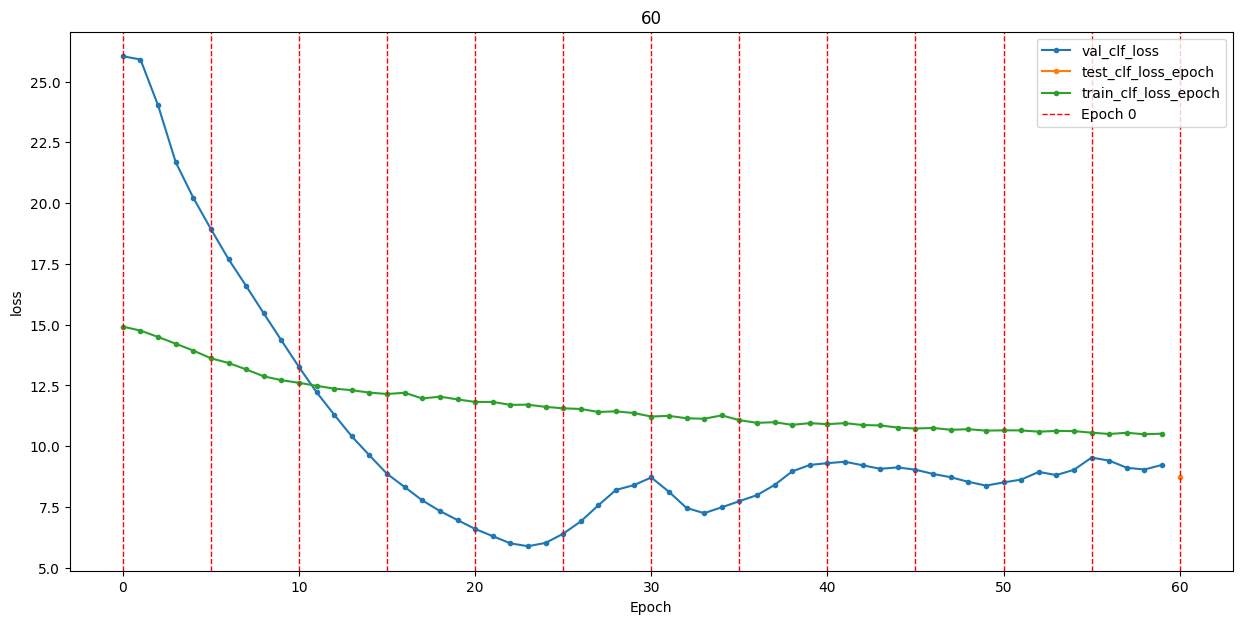

encoder and decoder structure: {'encoder': Sequential(
  (0): Sequential(
    (0): Linear(in_features=3737, out_features=3737, bias=True)
    (1): BatchNorm1d(3737, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
  )
  (1): Sequential(
    (0): Linear(in_features=3737, out_features=3737, bias=True)
    (1): BatchNorm1d(3737, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (2): Sequential(
    (0): Linear(in_features=3737, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (4): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(6

,time,pseudotime,trans_label
0,-1,-3.413869,-5.0
1,-1,-3.219765,-5.0
2,-1,-3.384326,-5.0
3,-1,-3.284833,-5.0
4,-1,-3.615200,-5.0
...,...,...,...
121,60,1.578337,5.0
122,60,0.942082,5.0
123,60,0.892572,5.0
124,60,4.662192,5.0


In [19]:
for fold in range(len(donor_list)):
    _result_df,_,_ = process_fold_toyDataset(fold, donor_list, adata, time_standard_type, config, save_path, train_epoch_num)

    kFold_test_result_df = pd.concat([kFold_test_result_df, _result_df], axis=0)
print("k-fold test final result:")
kFold_test_result_df

spearman correlation score: 0.932788291869457, p-value: 1.3573877555223933e-240.
kendalltau correlation score: 0.8013037001251352,p-value: 1.28783073906612e-148.
test result save at /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/tvae_results/embryoBeta_tvae_result.csv


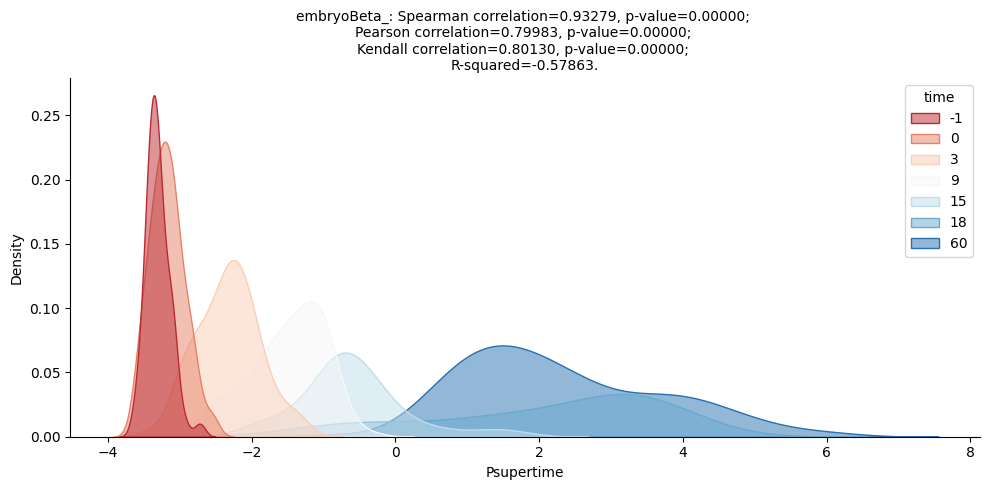

figure save at /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/tvae_results//embryoBeta__labelsOverPsupertime.png
figure save at /mnt/yijun/nfs_share/awa_project/awa_github/TemporalVAE-release-main/tvae_results//embryoBeta_labelsOverPsupertime.png


In [20]:
def corr(x1, x2):
    from scipy.stats import spearmanr, kendalltau
    sp_correlation, sp_p_value = spearmanr(x1, x2)
    ke_correlation, ke_p_value = kendalltau(x1, x2)
    print(f"spearman correlation score: {sp_correlation}, p-value: {sp_p_value}.")
    print(f"kendalltau correlation score: {ke_correlation},p-value: {ke_p_value}.")

corr(kFold_test_result_df["time"], kFold_test_result_df["pseudotime"])
kFold_test_result_df.to_csv(f'{os.getcwd()}/{method}_results/{dataset}_{method}_result.csv', index=True)
print(f"test result save at {os.getcwd()}/{method}_results/{dataset}_{method}_result.csv")

# f = tp.plot_grid_search(title="Grid Search")
# f.savefig(f"{os.getcwd()}/psupertime_results/gridSearch.png")
# f = tp.plot_model_perf((adata.X, adata.obs.time), figsize=(6, 5))
# f.savefig(f"{os.getcwd()}/psupertime_results/modelPred.png")
# f = tp.plot_identified_gene_coefficients(adata, n_top=20)
# f.savefig(f"{os.getcwd()}/psupertime_results/geneCoff.png")
from TemporalVAE.utils.utils_plot import plot_psupertime_density
save_path = f"{os.getcwd()}/{method}_results/"
plot_psupertime_density(kFold_test_result_df, save_path=save_path, label_key="time", psupertime_key="pseudotime", method=f"{dataset}_")
print(f"figure save at {save_path}/{dataset}_labelsOverPsupertime.png")